# Setting up Paths

In [6]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
#path to compasrepo which contains ther popsynth folder
# pathRepo = '/Users/floorbroekgaarden/Programs/COMPAS/popsynth/Papers/BroekgaardenEtAl/black_hole-neutron_star/Scripts'



pathPostProcessing = '/Users/floorbroekgaarden/Projects/BHNS_project/Scripts'




# Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import sys
import copy
#Quick fudge to make import from ../Scripts work
import sys
sys.path.append('/Users/floorbroekgaarden/Projects/BHNS_project/Scripts')
# sys.path.append(pathPostProcessing+'/2_CosmicIntegration')

# Custom Imports from COMPASrepo

In [8]:
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data
# import ClassEvents            as CE
# import ClassBayes             as CB
import coencodeVarious        as CV
from PostProcessingScripts import * 


# The cosmic integrator class

In [109]:
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 1000
Data = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat', COMPASbinaryFraction=0.6)

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data.COMPAS.mass1)

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[2.06203 9.0769  2.98903 ... 4.78319 4.4085  4.66631]


# The plot

In [ ]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]




rates    = []
totals   = []
for nrL, L in enumerate(labels):
    Data.MSSFR.Zprescription         = method[nrL]
    Data.MSSFR.SFRprescription       = SFRs[nrL]
    Data.MSSFR.logNormalPrescription = logNormal[nrL]
    Data.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data.MSSFR.ZMprescription        = MZs[nrL]
    Data.cosmologicalIntegration()
        
    
    Row        =np.sum(Data.PerSystemPerRedshift_ratesObserved, axis=0)
    rates.append(Row)
    totals.extend([np.sum(Row)])
    print(L, np.sum(Row))

In [ ]:
##### For each observation (column) we draw a chirpmass with probability gaussian

events     = CE.Observations() 
names, values, lowerErrors, upperErrors, survey =\
events.giveParameterAndError(parameter='Mchirp', types=['BBH'])  


draws = 5000
arraydraws = np.zeros(shape=(draws, len(names)))


Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(0,60,250)
centerx     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)
gaussians  = []

Bayes      = CB.BayesianLikelyhoodSingleObservation(datapoints = Data.COMPAS.mChirp)
for nre, event in enumerate(names):
    Bayes.setObservation(observation=values[nre], lowerError=lowerErrors[nre], \
                         upperError=upperErrors[nre], confidence=0.9)
    Bayes.calculatePDFposterior()
    pdf, bins = np.histogram(Bayes._x, bins=bins, weights=Bayes._PDFobservation)
    gaussians.append(pdf)
    
    sigma   = Bayes._sigmaSymmetric
    mu      = Bayes._symmetricMu
    s = np.random.normal(mu, sigma, draws)
    arraydraws[:,nre] = s

In [ ]:
###### Turn each PDF into CDF per model

chirpMasses     = Data.COMPAS.mChirp
indexSortMasses = np.argsort(chirpMasses)
sortedMasses    = chirpMasses[indexSortMasses]
CDFs            = []
for nrM, model in enumerate(labels):
    sortedRate  = rates[nrM][indexSortMasses]
    CDFs.append(np.cumsum(sortedRate)/float(np.sum(sortedRate)))
fig, axes = plt.subplots(1,1)
for cdf in CDFs:
    axes.plot(sortedMasses, cdf)
plt.show()

In [ ]:
def return10Masses(cdf, masses):
    #draw number between 0-1
    nrdraws = 10
    d = np.random.uniform(low=0.0, high=1.0, size=nrdraws)
    #find nearest value cdf
    indices = np.zeros(nrdraws, dtype=int)
    for nrd, draw in enumerate(d):
        difference   = np.abs(cdf-draw)
        minimum      = np.min(difference)
        indices[nrd] = int(np.where(difference == minimum)[0][0])
    indices = np.array(indices)
    return np.sort(masses[indices])

y10draws = np.cumsum(np.ones(10)/np.sum(np.ones(10)))
x10draws = []
counter  = 0
while counter < draws:
    masses = return10Masses(CDFs[0], sortedMasses)
    x10draws.append(masses)
    counter+=1
    
print(len(x10draws))

In [ ]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
# ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

# ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############
Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(1,7.5,100)
center     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(Mtot, bins=bins, weights = rate)
    rate       = np.divide(rate, dMtot)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
nameY = r'$\rm dP / dM_{chirp} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(bottom=-0.002, top=0.071)


##########
#
#########


    
# ax12.set_xlim(ax0.get_xlim())
# ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim(top=1.01)
# y = ax1.get_yticks()
# ax1.set_yticks(y[:-2])
# ax12.set_ylim(top=0.8)
# ax12.get_yaxis().set_visible(False)
# nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
# nameY = r'$\rm CDF $'
# ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
# ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassDistributionAtRedshiftObs.png', dpi=300, transparent=False)
plt.show()
# plt.close()

In [ ]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
# ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

# ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############

M1         = Data.COMPAS.mass1
M2         = Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MBH 

bins       = np.linspace(3,20,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm Mass BH\ \ [M_{\odot}] $'
nameY = r'$\rm dP / dM_{BH} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(bottom=-0.002, top=0.071)


##########
#
#########


    
# ax12.set_xlim(ax0.get_xlim())
# ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim(top=1.01)
# y = ax1.get_yticks()
# ax1.set_yticks(y[:-2])
# ax12.set_ylim(top=0.8)
# ax12.get_yaxis().set_visible(False)
# nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
# nameY = r'$\rm CDF $'
# ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
# ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassBHDistributionAtRedshiftObs.png', dpi=300, transparent=False)
plt.show()
# plt.close()

In [ ]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
# ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

# ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############

M1         = Data.COMPAS.mass1
M2         = Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MNS 

bins       = np.linspace(1,3,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm Mass NS\ \ [M_{\odot}] $'
nameY = r'$\rm dP / dM_{NS} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(bottom=-0.002, top=0.091)


##########
#
#########


    
# ax12.set_xlim(ax0.get_xlim())
# ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim(top=1.01)
# y = ax1.get_yticks()
# ax1.set_yticks(y[:-2])
# ax12.set_ylim(top=0.8)
# ax12.get_yaxis().set_visible(False)
# nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
# nameY = r'$\rm CDF $'
# ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
# ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassNSDistributionAtRedshiftObs.png', dpi=300, transparent=False)
plt.show()
# plt.close()

# 1. mass ratio distribution 

In [4]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]




In [5]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
modelname = 'Fiducial'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data_model1 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model1.COMPAS.mass1)
print(len(Data_model1.COMPAS.mass1))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()


KeyboardInterrupt: 

In [ ]:
rates_model1    = []
totals_model1   = []
for nrL, L in enumerate(labels):
    Data_model1.MSSFR.Zprescription         = method[nrL]
    Data_model1.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model1.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model1.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model1.MSSFR.ZMprescription        = MZs[nrL]
    Data_model1.cosmologicalIntegration()
    weightSTROOPWAFEL = Data_model1.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model1.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model1.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model1.append(Row)
    totals_model1.extend([np.sum(Row)])
    print(L, np.sum(Row))

NameError: name 'Data' is not defined

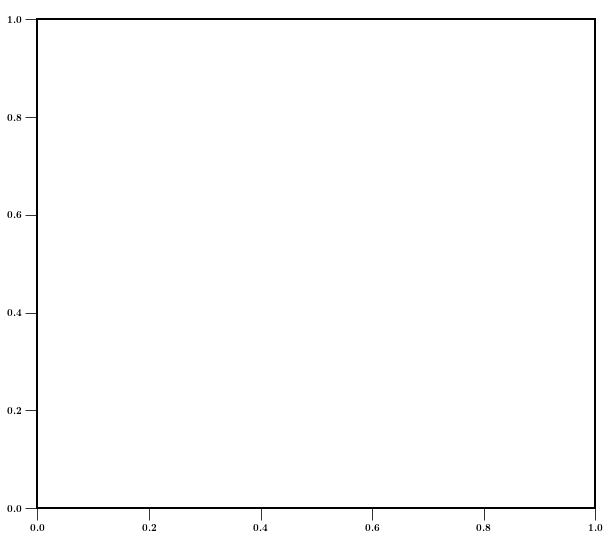

In [12]:
fig , ax0       = plt.subplots(1,1,figsize=(10,9))

############
#  Top panel with MSSFR
############

M1         = Data.COMPAS.mass1
M2         = Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MBH / MNS

print MNS

bins       = np.linspace(1,13.5,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm q = M_{BH} / M_{NS} $'
nameY = r'$\rm p(q)   $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
topp = 0.06
ax0.set_ylim(bottom=0, top=topp)
ax0.set_xlim(left=0)

## FILL PLOT WHERE BH-NS produces EM counterpart
xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
yy_disrupt_0spin = [0, topp]   
xx_BHspin_0_5 = [0,7.1] 
labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.6,hatch='/')
ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.3,hatch='.')
ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
ax0.add_artist(leg2)

plt.tight_layout()
plt.grid()



# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./qDistributionAtRedshiftObs_weighted.png', dpi=300, transparent=False)
plt.show()
# plt.close()

In [ ]:
print var_x

In [ ]:
from matplotlib.legend import Legend

modelname = 'alpha0_1'

# Different model

In [ ]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/alpha0_1/'
modelname = 'alpha0_1'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data_model2 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model2.COMPAS.mass1)
print(len(Data_model2.COMPAS.mass1))

In [ ]:
rates_model2    = []
totals_model2   = []
for nrL, L in enumerate(labels):
    Data_model2.MSSFR.Zprescription         = method[nrL]
    Data_model2.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model2.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model2.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model2.MSSFR.ZMprescription        = MZs[nrL]
    Data_model2.cosmologicalIntegration()
        
    weightSTROOPWAFEL = Data_model2.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model2.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight

    
#     Row        =np.sum(Data_model2.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model2.append(Row)
    totals_model2.extend([np.sum(Row)])
    print(L, np.sum(Row))

In [ ]:
fig , ax0       = plt.subplots(1,1,figsize=(10,9))

############
#  Top panel with MSSFR
############

M1         = Data_model2.COMPAS.mass1
M2         = Data_model2.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MBH / MNS

print MNS

bins       = np.linspace(1,13.5,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates_model2[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals_model2[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm q = M_{BH} / M_{NS} $'
nameY = r'$\rm p(q)   $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
topp = 0.06
ax0.set_ylim(bottom=0, top=topp)
ax0.set_xlim(left=0)

## FILL PLOT WHERE BH-NS produces EM counterpart
xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
yy_disrupt_0spin = [0, topp]   
xx_BHspin_0_5 = [0,7.1] 
labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.6,hatch='/')
ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.3,hatch='.')
ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
ax0.add_artist(leg2)

plt.tight_layout()
plt.grid()



# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./qDistributionAtRedshiftObs'+'_model_'+ modelname + '.png', dpi=300, transparent=False)
plt.show()
# plt.close()




# MODEL 2: ALPHA = 10 

In [ ]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/alpha_10/'
modelname = 'alpha_10'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data_model3 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model3.COMPAS.mass1)
print(len(Data_model3.COMPAS.mass1))

In [ ]:
rates_model3    = []
totals_model3   = []
for nrL, L in enumerate(labels):
    Data_model3.MSSFR.Zprescription         = method[nrL]
    Data_model3.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model3.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model3.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model3.MSSFR.ZMprescription        = MZs[nrL]
    Data_model3.cosmologicalIntegration()
        
    weightSTROOPWAFEL = Data_model3.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model3.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight

    
#     Row        =np.sum(Data_model3.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model3.append(Row)
    totals_model3.extend([np.sum(Row)])
    print(L, np.sum(Row))

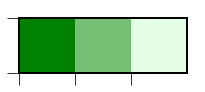

In [99]:
snscolor = sns.palplot(sns.light_palette("green",3, reverse=True))
snscolor = sns.color_palette(sns.light_palette("green",3 , reverse=True))

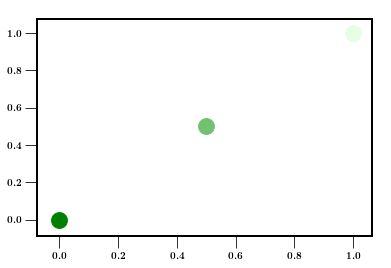

In [100]:
for xx_ind, xx in enumerate(np.linspace(0,1,3)):
    plt.scatter(xx,xx, c=snscolor[xx_ind], s=250)
    
    
    

In [103]:
xx = np.linspace(0,1,8)
print(xx[4:7])
print(xx[2])

[0.57142857 0.71428571 0.85714286]
0.2857142857142857


# PLOT COMBINED 

In [17]:
from matplotlib.legend import Legend

modelname = 'alpha0_1'

import seaborn as sns;

sns.color_palette("husl", 8)
# ...    _ = plt.plot(np.c_[np.zeros(8), np.arange(8)].T)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

In [50]:
# TOTAL MASS 

In [ ]:
# Plot individual masses

# CHIRP MASS

In [ ]:
.tc

# BBH  COMBINED

In [9]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]





# FIDUCIAL

In [10]:
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
modelname = 'Fiducial'




#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 1000
TYPE ='BBH'
Data_model1_BBH = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP', COMPASbinaryFraction=0.6)

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model1_BBH.COMPAS.mass1)




rates_model1_BBH    = []
totals_model1_BBH   = []
for nrL, L in enumerate(labels):
    Data_model1_BBH.MSSFR.Zprescription         = method[nrL]
    Data_model1_BBH.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model1_BBH.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model1_BBH.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model1_BBH.MSSFR.ZMprescription        = MZs[nrL]
    Data_model1_BBH.cosmologicalIntegration()
    weightSTROOPWAFEL = Data_model1_BBH.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model1_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model1_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model1_BBH.append(Row)
    totals_model1_BBH.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[21.2069  19.5982  14.5595  ...  6.97008  7.22899  7.43115]
('Preferred model', 211.9648011154216)
('Barrett et al. (2018) MSSFR', 2655.7801101333894)
('Furlong et al. (2015) Single', 4369.8934858555085)
('Ma et al. (2015)', 174.81871373462423)


# ALPHA =0.1 MODEL 2 

In [11]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/alpha0_1/'
modelname = 'alpha0_1'



#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 1000
TYPE ='BBH'
Data_model2_BBH = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP', COMPASbinaryFraction=0.6)

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model2_BBH.COMPAS.mass1)




rates_model2_BBH    = []
totals_model2_BBH   = []
for nrL, L in enumerate(labels):
    Data_model2_BBH.MSSFR.Zprescription         = method[nrL]
    Data_model2_BBH.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model2_BBH.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model2_BBH.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model2_BBH.MSSFR.ZMprescription        = MZs[nrL]
    Data_model2_BBH.cosmologicalIntegration()
    weightSTROOPWAFEL = Data_model2_BBH.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model2_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model2_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model2_BBH.append(Row)
    totals_model2_BBH.extend([np.sum(Row)])
    print(L, np.sum(Row))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[25.5051  24.4408  36.0009  ...  7.52356  7.53006  7.52837]
('Preferred model', 163.6549036871768)
('Barrett et al. (2018) MSSFR', 1831.767533722552)
('Furlong et al. (2015) Single', 3033.6798575098583)
('Ma et al. (2015)', 130.48206232053437)


# ALPHA =10 MODEL 3

In [12]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/alpha_10/'
modelname = 'alpha_10'




#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 1000
TYPE ='BBH'
Data_model3_BBH = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP', COMPASbinaryFraction=0.6)

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model3_BBH.COMPAS.mass1)




rates_model3_BBH    = []
totals_model3_BBH   = []
for nrL, L in enumerate(labels):
    Data_model3_BBH.MSSFR.Zprescription         = method[nrL]
    Data_model3_BBH.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model3_BBH.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model3_BBH.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model3_BBH.MSSFR.ZMprescription        = MZs[nrL]
    Data_model3_BBH.cosmologicalIntegration()
    weightSTROOPWAFEL = Data_model3_BBH.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model3_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model3_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model3_BBH.append(Row)
    totals_model3_BBH.extend([np.sum(Row)])
    print(L, np.sum(Row))




weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[24.4408  21.323   36.0009  ...  7.49146  7.52112  7.53674]
('Preferred model', 163.59862514946076)
('Barrett et al. (2018) MSSFR', 1780.9755659760458)
('Furlong et al. (2015) Single', 3137.3465433369333)
('Ma et al. (2015)', 120.8893925939319)


In [13]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
modelname = 'Fiducial'




#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 1000
TYPE ='BBH'
Data_model4_BBH = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=TYPE,\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=True, Cosmology='WMAP', COMPASbinaryFraction=0.6)

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model4_BBH.COMPAS.mass1)




rates_model4_BBH    = []
totals_model4_BBH   = []
for nrL, L in enumerate(labels):
    Data_model4_BBH.MSSFR.Zprescription         = method[nrL]
    Data_model4_BBH.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model4_BBH.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model4_BBH.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model4_BBH.MSSFR.ZMprescription        = MZs[nrL]
    Data_model4_BBH.cosmologicalIntegration()
    weightSTROOPWAFEL = Data_model4_BBH.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model4_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model4_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model4_BBH.append(Row)
    totals_model4_BBH.extend([np.sum(Row)])
    print(L, np.sum(Row))





weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[21.2069  19.5982  14.5595  ...  3.07269  4.66946  5.41234]
('Preferred model', 436.01922568006887)
('Barrett et al. (2018) MSSFR', 3749.7446506323454)
('Furlong et al. (2015) Single', 5350.952723778981)
('Ma et al. (2015)', 588.9202247653822)


In [14]:
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method): # and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

        
        

def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest








In [15]:
def plotdistribution(axe, var, nrbins, modelnameslist, rateslist, totalslist, Datalist,  xvarrange, xlabel, ylabel, xlim, ylim, indplot):
    """ plot distribution of xvar for array of metallicities 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """    
    labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


    
    # set kde  range of parameter
    # xx_boot is the x points for which we will use a kde to calculate the y-value of the distribution
    resKDE =1000 # just nr of interpolation points for kde function (this is not the bandwith)

    
    xq_GW190412 = np.linspace(0.21, 0.41, 100)
    
    yLow=np.zeros_like(xq_GW190412)
    yTop=np.ones_like(xq_GW190412)*10
    axe.fill_between(xq_GW190412, yLow, yTop, facecolor='gray', alpha=0.6)#,\
#                           label=)


    x_beta = np.linspace(0,1, 100)
    for ind_beta, beta in enumerate([0,1, 2.7]):
        
        y_beta = x_beta**beta
        
        if indplot==0:
            y_beta = (y_beta / np.sum(y_beta))*100 # normalize to 1
            axe.plot(x_beta, y_beta, lw=5, c='k')  
            axe.text(0.2,y_beta[30] , s=r'$\beta=$%s'%beta, fontsize=fs-2,\
             rotation=0, verticalalignment='bottom')
        elif indplot==1:
            y_beta = (y_beta / np.sum(y_beta)) # normalize to 1
            axe.plot(x_beta, np.cumsum(y_beta), lw=5, c='k')  
            axe.text(0.2,np.cumsum(y_beta)[30] , s=r'$\beta=$%s'%beta, fontsize=fs-2,\
             rotation=0, verticalalignment='bottom')            



    if indplot==0:
        ytext = 4.5
    elif indplot==1:
        ytext = 0.9
    axe.text(0.25, ytext, s='GW190412', fontsize=fs-2,\
             rotation=0, verticalalignment='top')

    
    
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]


        if var=='tc':
            xvar = Data.COMPAS.tc
        elif var=='q':
            
            M1=Data.COMPAS.mass1
            M2=Data.COMPAS.mass2
            MBH1, MBH2 = obtainM1BHandM2BHassymetric(M1,M2)
            xvar = MBH2/MBH1
        elif var=='qprimaryZAMS':
            
            M1=Data.COMPAS.mass1
            M2=Data.COMPAS.mass2
            xvar = M2/M1           
        elif var=='mchirp':
            xvar = Data.COMPAS.mChirp
        elif var=='m1':
            xvar = Data.COMPAS.mass1
        elif var=='m2':
            xvar = Data.COMPAS.mass2
        elif var=='a':
            xvar = Data.COMPAS.separationDCOFormation
        elif var=='mtot':
            xvar = Data.COMPAS.mass1+Data.COMPAS.mass2
#         elif var==:
#             xvar = Data.COMPAS.
        else:
            print('Error: xvar option does not exist')
            
        
        # if xvarrange is specified use that, otherwise base it on xvar range
        if xvarrange:
            xx_boot = np.linspace(xvarrange[0], xvarrange[1], resKDE)
        else:
            xx_boot = np.linspace(min(xvar)*0.8,max(xvar)*1.2, resKDE)



        for nrL, L in enumerate(labels):
            if (indplot==0)&(nrL==0):
                LABEL=model
                print(nrL, 'nrL')
            else:
                LABEL=None            
            
            rate       = rates[nrL]
#             print(len(rate))
#             print(len(xvar))
#             print(model, L, 'model and label')

            if indplot==0:
     
                KDE = gaussian_kde(xvar, weights=rate, bw_method = nrbins)
                y_boot = KDE(xx_boot) #* np.sum(rate)
            
                axe.plot(xx_boot, (y_boot), c=modelcolors[ind_m], linewidth=5, label=LABEL,\
                        linestyle=linestyles[nrL])                       
# #             LABEL=None
            
#             rate, _    = np.histogram(var_x, bins=bins, weights = rate)
#             rate       = np.divide(rate, dvar_x)
#             rate       = rate / np.sum(rate)
# #             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
# #             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
#             if nrL==0:
#                 label = None
#             else:
#                 label = None
#             ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)


    


#         # I want to plot a kde for each metallcity in ZofInterest
#         for nrZ, Z in enumerate(ZOfInterest):

#             # only plot the label if indplot=0
#             if indplot==0:
#                 LABEL = r'$Z_{\rm{i}} = %s$'%Z
#             else:
#                 LABEL = None 


#             ind        = np.where(Data.metallicityGrid == Z)[0]
#             # Corresponding Mass Evolved per metallicity simulation
#             MsunEvolved= Data.totalMassEvolvedPerZ[ind]
# #             boolZ      = Data.metallicitySystems == Z

#         m = xvar[boolZ]
#         w     = Data.weight[boolZ]


#         KDE = gaussian_kde(m, weights=w, bw_method = nrbins)
#         # y value of the kde distribution
#         y_boot = KDE(xx_boot) * np.sum(w) / MsunEvolved # normalize to total weight to real rate



    
             ### PLOT CDF on right axes ###
            if indplot==1:
            # plot cdf:
                axe.hist(xvar, density=True, bins=len(xvar), cumulative=True, label=None,
                     histtype='step', alpha=1, color=modelcolors[ind_m], linewidth=3,\
                         linestyle=linestyles[nrL], zorder=10, weights=rate)    

        ### PLOT CDF on right axes ###
   
    
    ###########

    
    if xlim:
        axe.set_xlim(xlim[0], xlim[1])
    if ylim:
        axe.set_ylim(ylim[0], ylim[1])

    axe == CV.layoutAxes(axe, nameX=xlabel, nameY=ylabel)

    
    if indplot==0: 
        handles, labels = axe.get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    axe.grid(True)
    
    return handles, labels

###################




    

In [16]:
cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1_BBH, Data_model2_BBH, Data_model3_BBH, Data_model4_BBH]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha_{CE}=0.1$', r'$(2): \ \alpha_{CE}=10$', r'$(3): \ $ Optimistic']
rateslist = [rates_model1_BBH, rates_model2_BBH, rates_model3_BBH, rates_model4_BBH]
totalslist = [totals_model1_BBH, totals_model2_BBH, totals_model3_BBH, totals_model4_BBH]



In [82]:
# f, ax= plt.subplots(ncols=2,nrows=3,figsize=(20,23), 
#                   gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2,2]})






# varname ='q'
# Nbins=0.1

# handles, labels = plotdistribution(axe=ax[0,0], var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
#                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
#                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=None, indplot=0)   



# # # LEGEND
# lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
#          bbox_to_anchor=(.8, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




# plt.tight_layout()
# plt.subplots_adjust(wspace=0.34, hspace=0.2)
# plt.savefig('./BBH_characteristics_ModelandMSSFR.png', dpi=100, transparent=False,\
#            bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.show()
# plt.close()

(0, 'nrL')
(0, 'nrL')
(0, 'nrL')
(0, 'nrL')


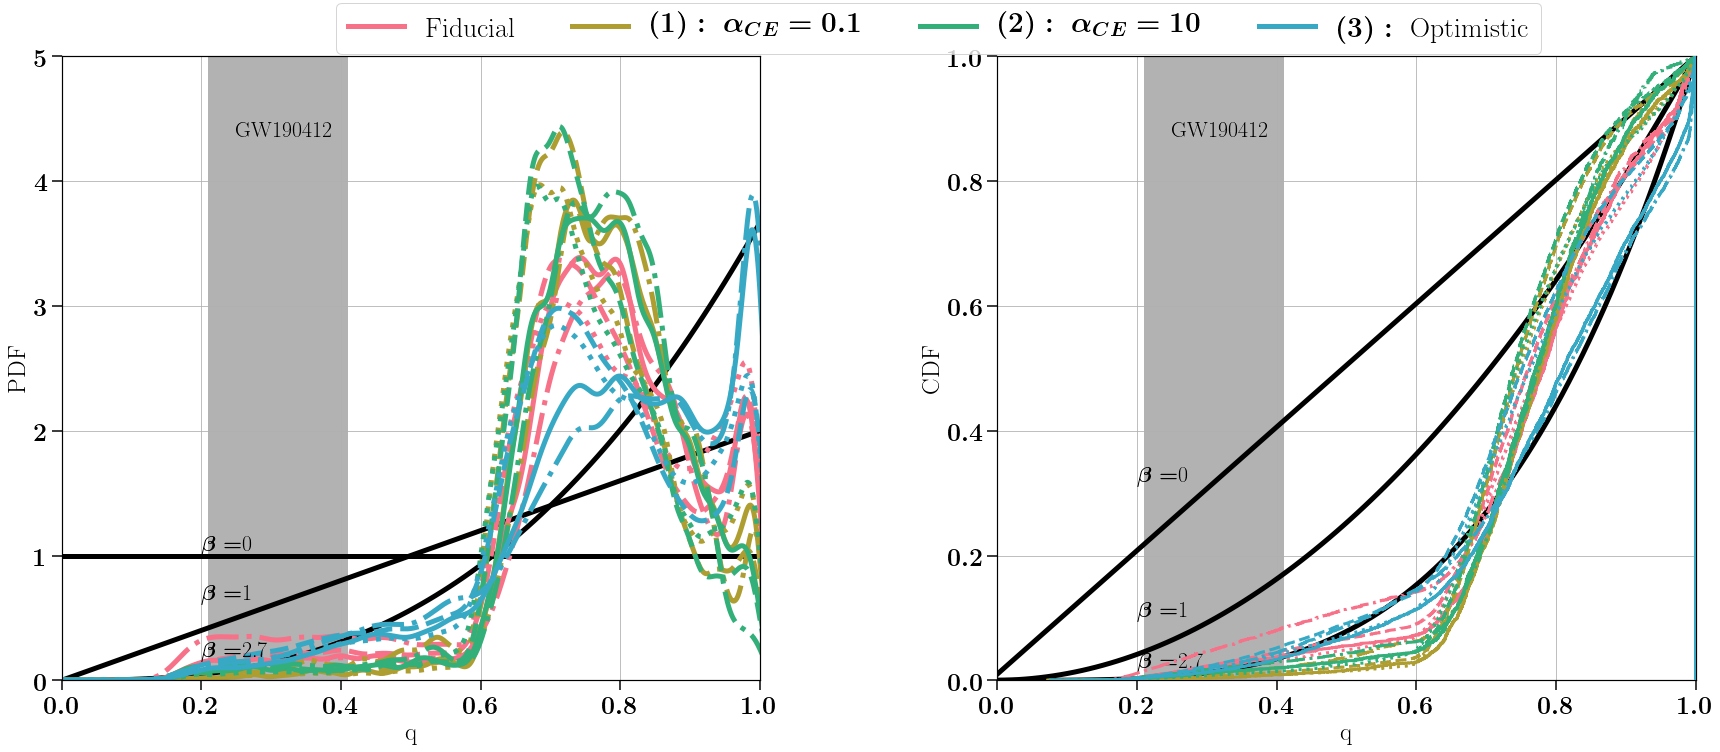

In [17]:
f, ax= plt.subplots(ncols=2,nrows=1,figsize=(24,10), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2]})






varname ='q'
Nbins=0.1

handles, labels = plotdistribution(axe=ax[0], var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
                       rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
                       xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   

_,_ = plotdistribution(axe=ax[1], var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
                       rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
                       xvarrange=[0,1.5], xlabel='q', ylabel='CDF', xlim=[0,1], ylim=[0,1], indplot=1)   




# # LEGEND
lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
         bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./BBH_characteristics_ModelandMSSFR_PDF_CDF_2panel.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

(0, 'nrL')
(0, 'nrL')
(0, 'nrL')
(0, 'nrL')


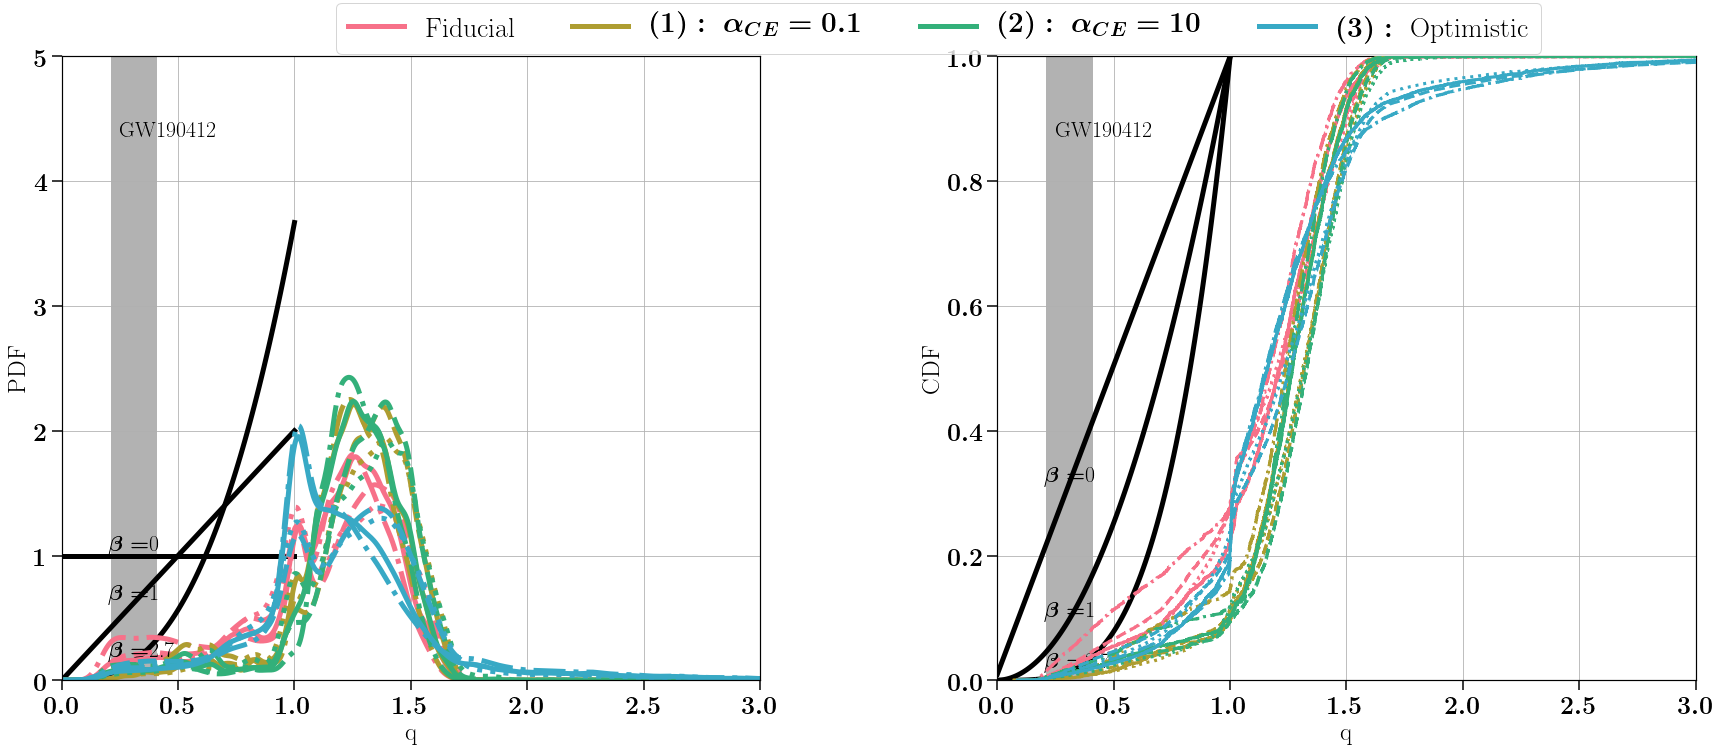

In [105]:
f, ax= plt.subplots(ncols=2,nrows=1,figsize=(24,10), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2]})






varname ='qprimaryZAMS'
Nbins=0.1

handles, labels = plotdistribution(axe=ax[0], var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
                       rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
                       xvarrange=[0,4], xlabel='q', ylabel='PDF', xlim=[0,3], ylim=[0,5], indplot=0)   

_,_ = plotdistribution(axe=ax[1], var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
                       rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
                       xvarrange=[0,4], xlabel='q', ylabel='CDF', xlim=[0,3], ylim=[0,1], indplot=1)   




# # LEGEND
lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
         bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./BBH_characteristics_ModelandMSSFR_PDF_CDF_2panel_qprimaryZAMS.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

In [84]:
def plot2Ddistribution(axe, var, weight, nrbins,  rateslist, totalslist,  labellist, xlimlist, indplot):
    """ plot distribution of xvar for array of metallicities 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """    
    labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']



    

    
    
    Nparam = len(var)

    
    
    for jj, param_x in enumerate(var):
#         print( 'ii = ', ii)
        
        for ii, param_y in enumerate(var):
#             print('jj = ', jj)
            
            
            if ii==jj:
                axe[ii,jj].hist(param_x, bins=nrbins, color='b', linewidth=5,\
                                weights=weight, histtype='step')
                ylabel='PDF'
                
                
            elif jj>ii:
                ax[ii,jj].set_axis_off()
                
            # 2D HISTOGRAM
            else:
                print('ii,jj=', ii, jj)
                ylabel=labellist[ii]
                
                ax[ii,jj].hist2d(param_x, param_y, bins=nrbins, weights=weight, normed=True)
                
                # axes & labels 
                if xlimlist[ii]:
                    axe[ii,jj].set_ylim(xlimlist[ii])
            
            
            
            
            
            
            # FOR ALL SUB PLOTS 
            xlabel = labellist[jj]
            axe[ii,jj] == CV.layoutAxes(axe[ii,jj], nameX=xlabel, nameY=ylabel)
            axe[ii,jj].grid(True)
            
            if xlimlist[ii]:
                
                axe[ii,jj].set_xlim(xlimlist[ii])    
    
    
#     for ii, param_x in enumerate(var):
#         print( 'ii = ', ii)
        
#         for jj, param_y in enumerate(var):
#             print('jj = ', jj)
            
            
#             if ii==jj:
#                 axe[ii,jj].hist(param_x, bins=nrbins, color='b', linewidth=5,\
#                                 weights=weight, histtype='step')
#                 ylabel='PDF'
                
                
#             elif jj>ii:
#                 ax[ii,jj].set_axis_off()
                
#             # 2D HISTOGRAM
#             else:
#                 ylabel=labellist[jj]
                
#                 ax[ii,jj].hist2d(param_x, param_y, bins=nrbins, weights=weight, normed=True)
                
#                 # axes & labels 
#                 if xlimlist[jj]:
#                     axe[ii,jj].set_ylim(xlimlist[jj])
            
            
            
            

        



   
    

    
    if indplot==0: 
        handles, labels = axe[ii,jj].get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    
    
    return handles, labels

###################




    

('ii,jj=', 1, 0)


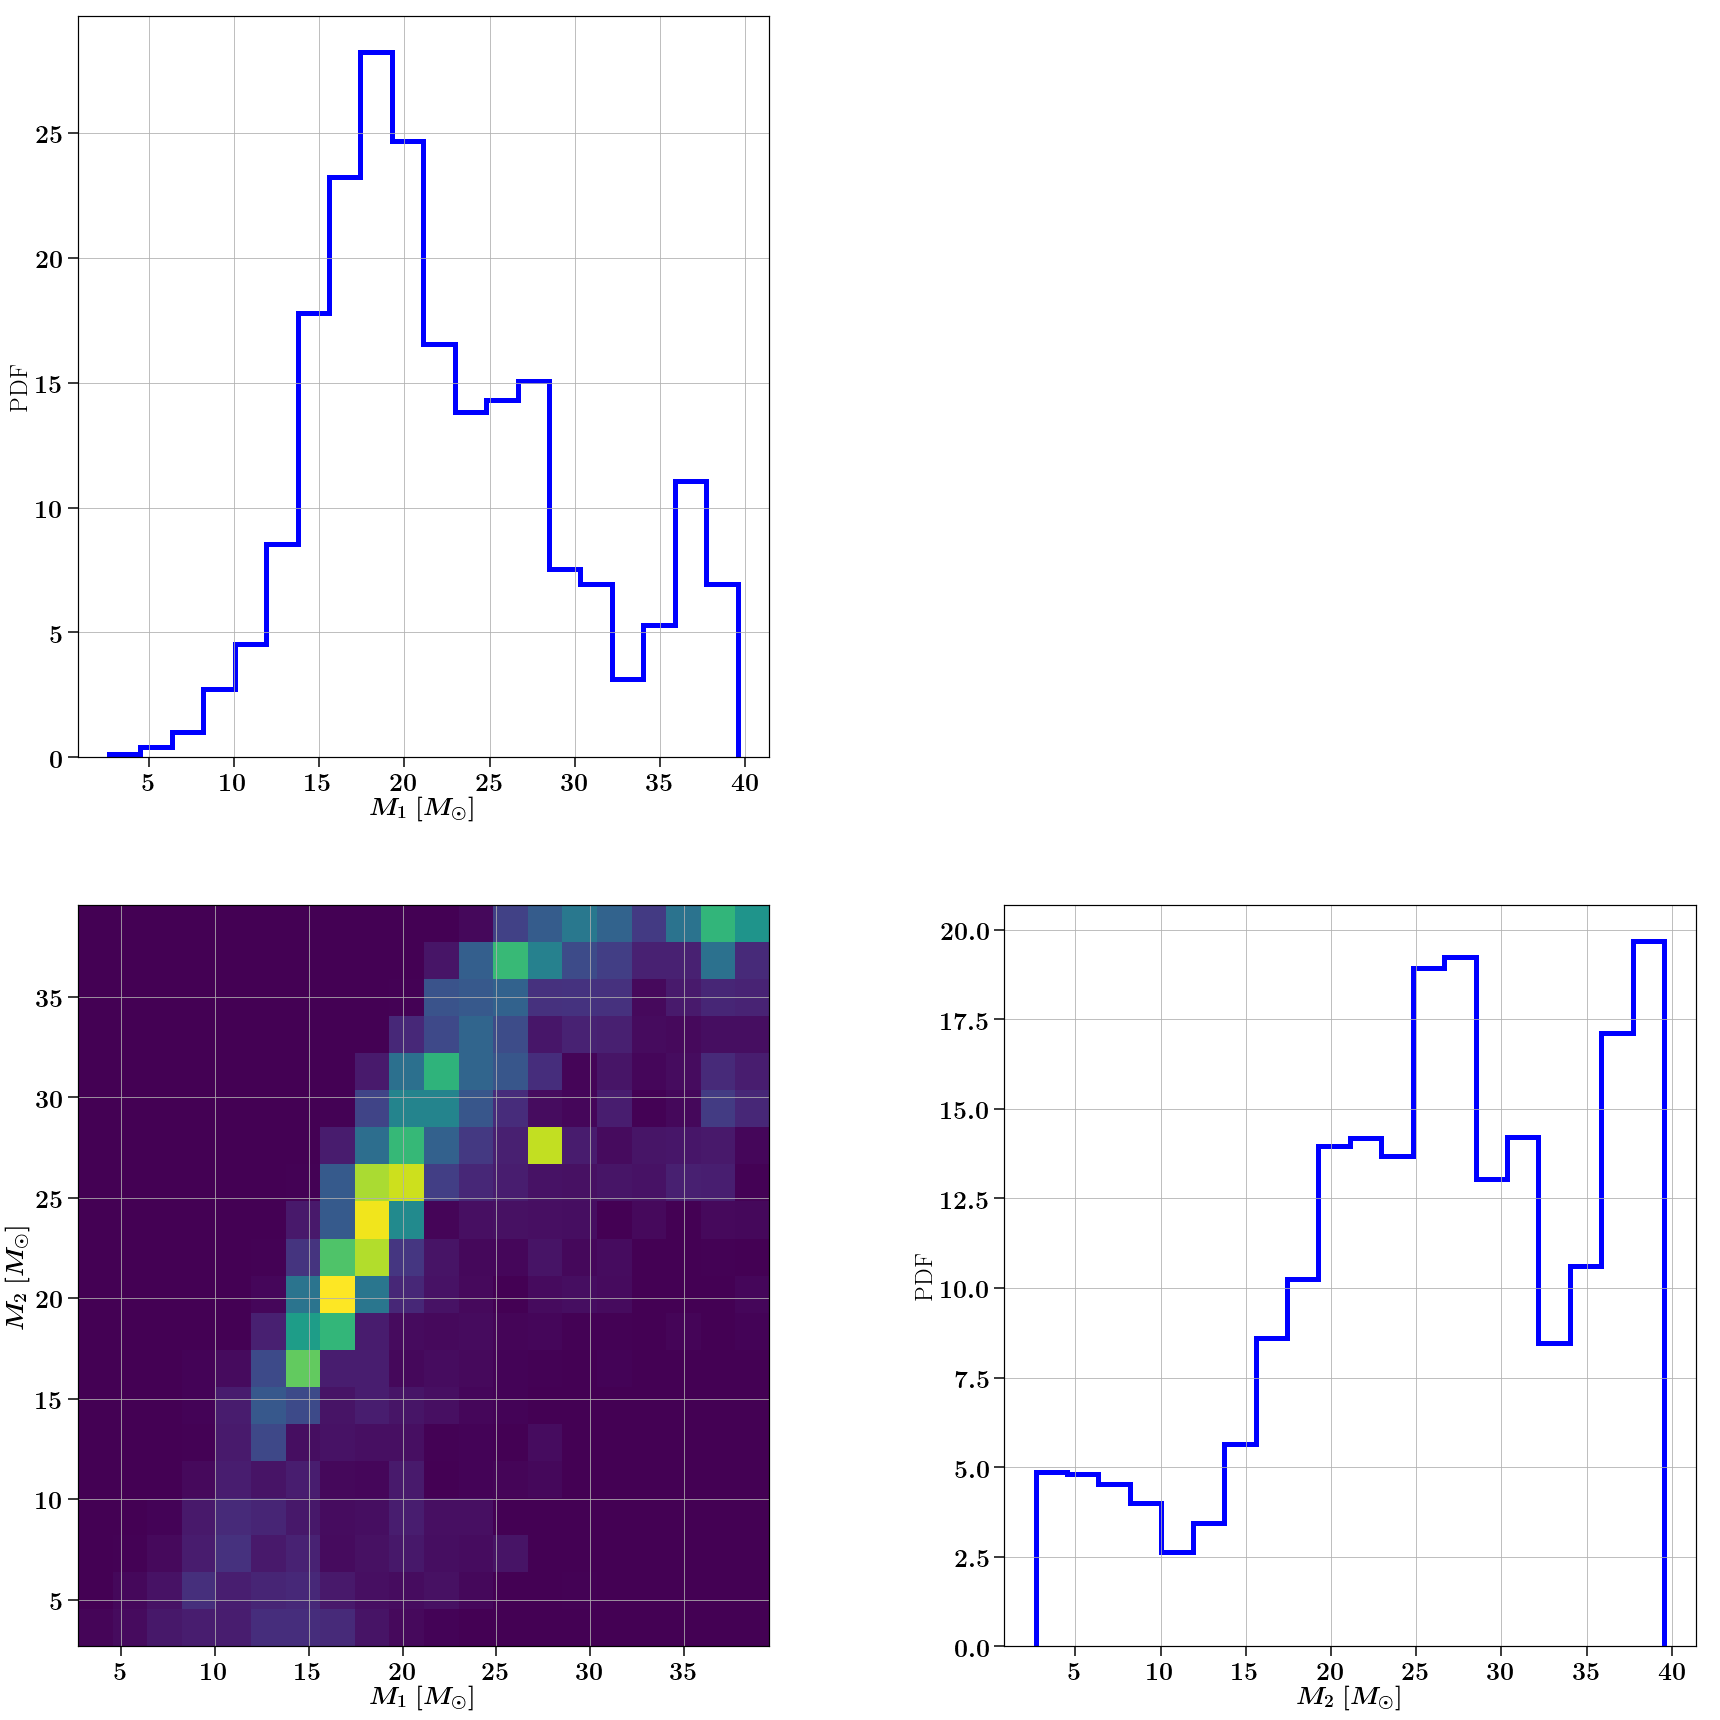

In [85]:


                    
Nbins = 20 
Data = Data_model1_BBH
var = [Data.COMPAS.mass1, Data.COMPAS.mass2]

labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


weights = rates_model1_BBH[0]


handles, labels =  plot2Ddistribution(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                      rateslist=rates_model1_BBH, totalslist=totals_model1_BBH,\
                                      labellist=labellist,\
                                      xlimlist=[None,None], indplot=0)





# plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
#                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
#                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




# # # # LEGEND
# # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
# #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./BBH_TrianglePlot.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

('ii,jj=', 1, 0)


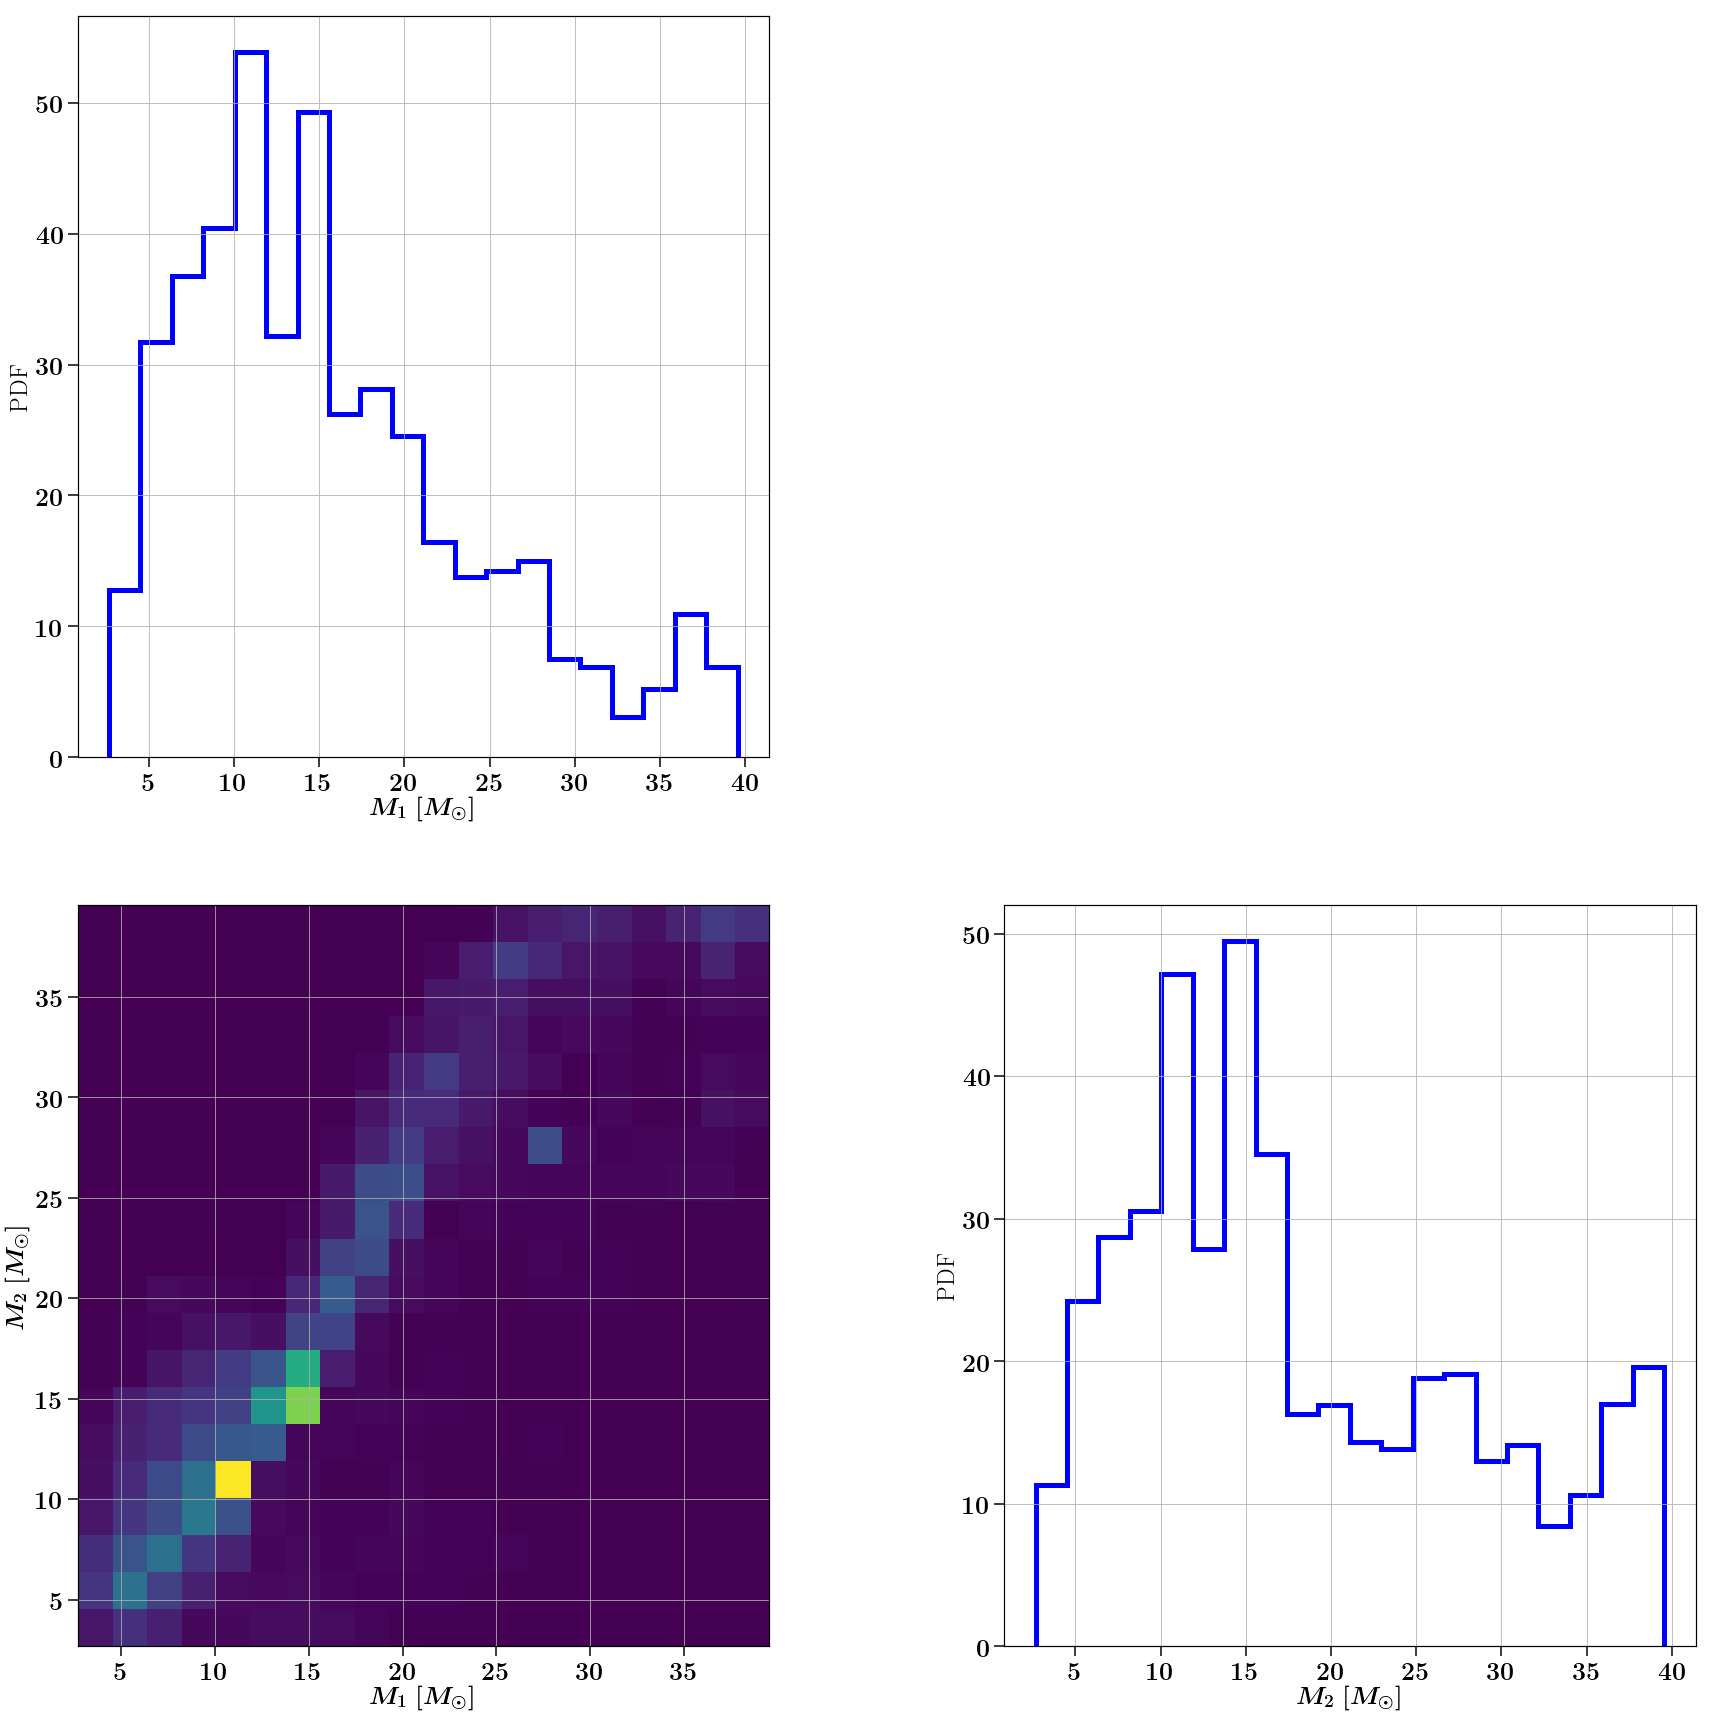

In [86]:


                    
Nbins = 20 
Data = Data_model4_BBH
var = [Data.COMPAS.mass1, Data.COMPAS.mass2]

labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


weights = rates_model4_BBH[0]


handles, labels =  plot2Ddistribution(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                      rateslist=rates_model1_BBH, totalslist=totals_model1_BBH,\
                                      labellist=labellist,\
                                      xlimlist=[None,None], indplot=0)





# plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
#                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
#                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




# # # # LEGEND
# # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
# #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./BBH_TrianglePlot_optimistic.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

In [80]:
def plotscatterdistribution(axe, var, weight, nrbins,  rateslist, totalslist,  labellist, xlimlist, indplot):
    """ plot distribution of xvar for array of metallicities 
    input:
    
    axe = the axis to plot it on
    xvar= the array of data that you want to plot the kde of
    bw_method = bandwith method of the kernel density function you want to use (see class gaussian_kde())
    xvarrange, the x-axis range to use for the kde [should be typically slightly larger than the range of xvar]
    xlabel, ylabel = x and y labels of the plot
    xlim, ylim = xlim and ylim of the plot axis 
    indplot = something I use to hack the legend labels (I only want to plot the legends for some subplots)
    you can just put indplot=0 or indplot=1 to get labels or no labels resp. 
    
    """    
    labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']



    

    
    
    Nparam = len(var)
    
    for jj, param_x in enumerate(var):
#         print( 'ii = ', ii)
        
        for ii, param_y in enumerate(var):
#             print('jj = ', jj)
            
            
            if ii==jj:
                axe[ii,jj].hist(param_x, bins=nrbins, color='b', linewidth=5,\
                                weights=weight, histtype='step')
                ylabel='PDF'
                
                
            elif jj>ii:
                ax[ii,jj].set_axis_off()
                
            # 2D HISTOGRAM
            else:
                print('ii,jj=', ii, jj)
                ylabel=labellist[ii]
                
                ax[ii,jj].scatter(param_x, param_y, s=weight*50)
                
                # axes & labels 
                if xlimlist[ii]:
                    axe[ii,jj].set_ylim(xlimlist[ii])
            
            
            
            
            
            
            # FOR ALL SUB PLOTS 
            xlabel = labellist[jj]
            axe[ii,jj] == CV.layoutAxes(axe[ii,jj], nameX=xlabel, nameY=ylabel)
            axe[ii,jj].grid(True)
            
            if xlimlist[ii]:
                
                axe[ii,jj].set_xlim(xlimlist[ii])

            
        



   
    

    
    if indplot==0: 
        handles, labels = axe[ii,jj].get_legend_handles_labels()
    else:
        handles, labels = None, None
        
    
    
    return handles, labels

###################




    

('ii,jj=', 1, 0)


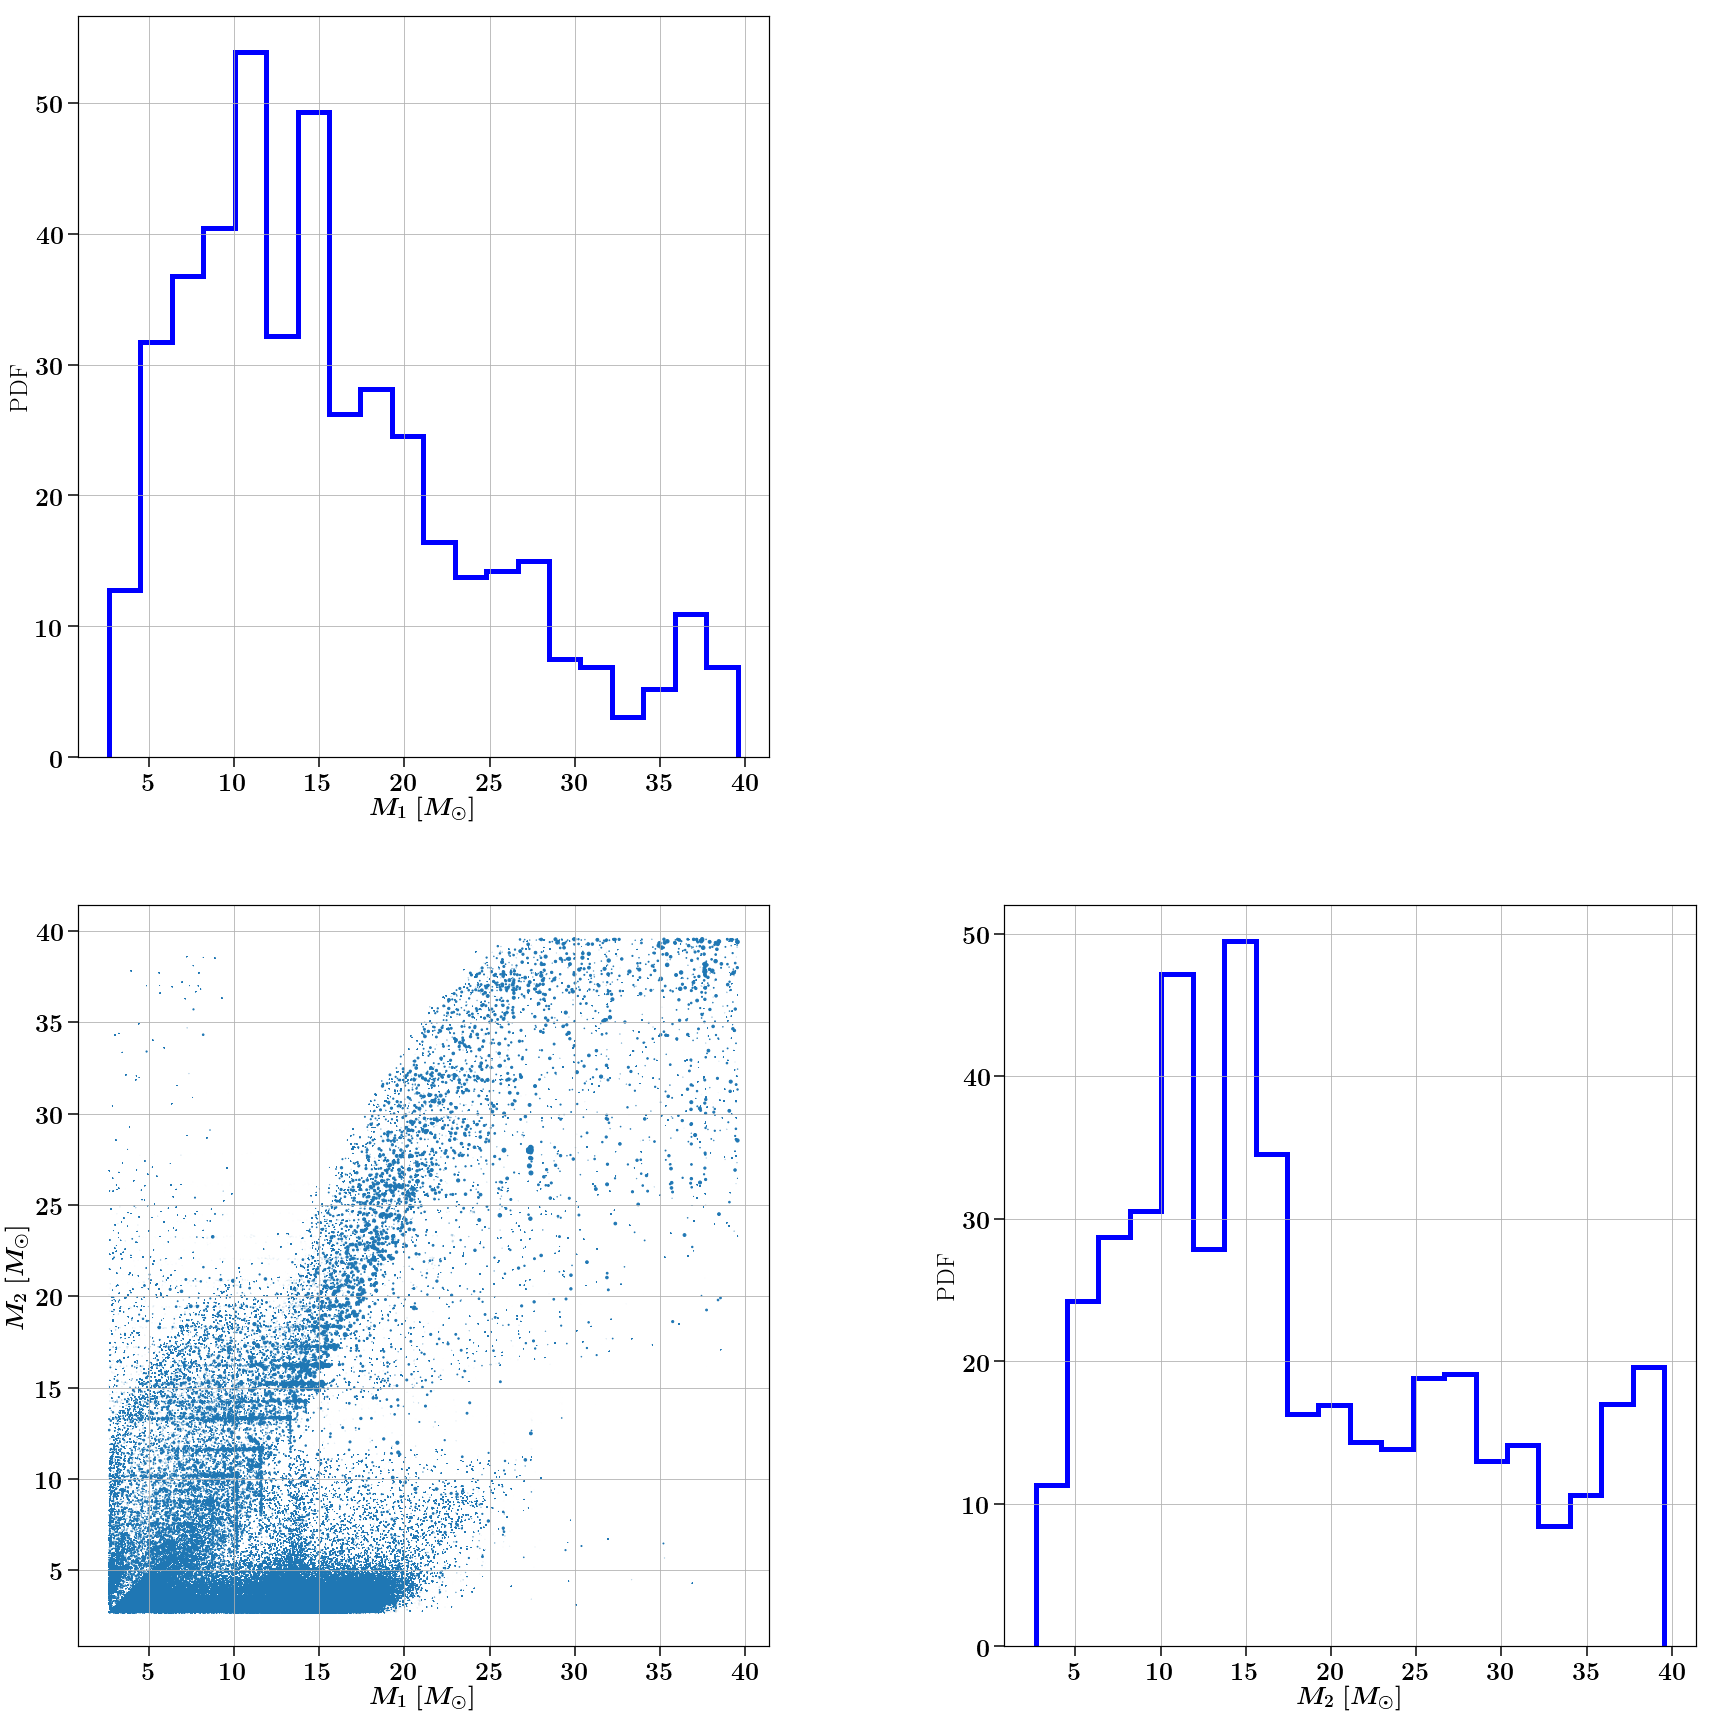

In [81]:


                    
Nbins = 20 
Data = Data_model4_BBH
var = [Data.COMPAS.mass1, Data.COMPAS.mass2]

labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


weights = rates_model4_BBH[0]


handles, labels =  plotscatterdistribution(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                      rateslist=rates_model1_BBH, totalslist=totals_model1_BBH,\
                                      labellist=labellist,\
                                      xlimlist=[None,None], indplot=0)





# plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
#                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
#                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




# # # # LEGEND
# # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
# #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./BBH_TrianglePlot_optimistic_scatter.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

('ii,jj=', 1, 0)


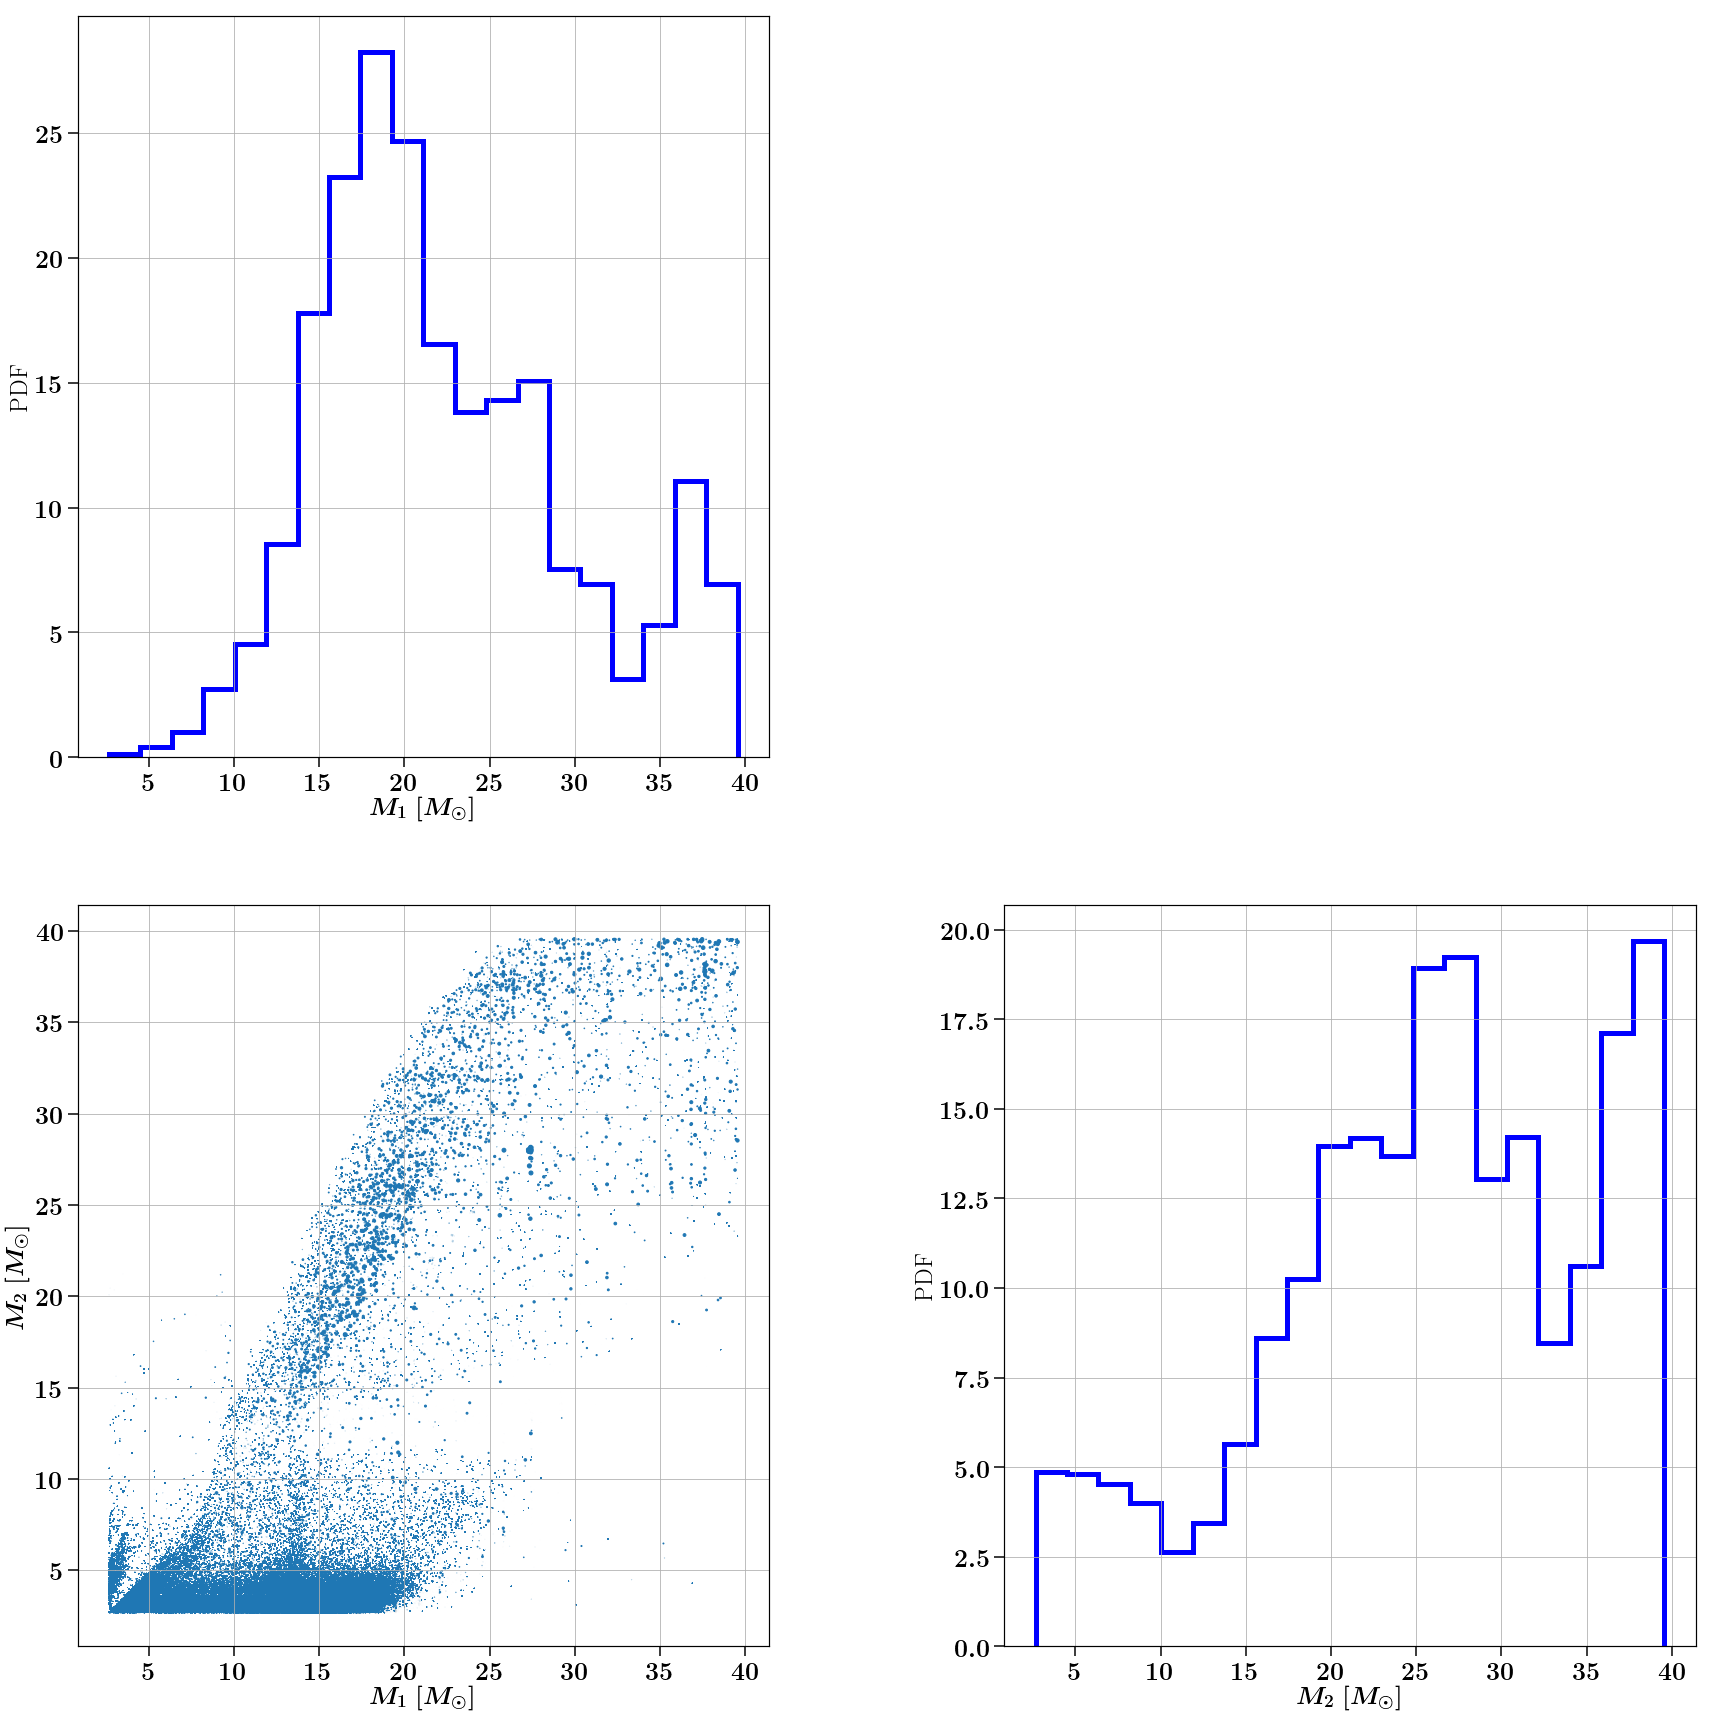

In [87]:


                    
Nbins = 20 
Data = Data_model1_BBH
var = [Data.COMPAS.mass1, Data.COMPAS.mass2]

labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                  gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


weights = rates_model1_BBH[0]


handles, labels =  plotscatterdistribution(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                      rateslist=rates_model1_BBH, totalslist=totals_model1_BBH,\
                                      labellist=labellist,\
                                      xlimlist=[None,None], indplot=0)





# plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
#                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
#                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




# # # # LEGEND
# # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
# #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




plt.tight_layout()
plt.subplots_adjust(wspace=0.34, hspace=0.2)
plt.savefig('./BBH_TrianglePlot_scatter.png', dpi=100, transparent=False,\
           bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# MSSFR VARIATIONS:

In [88]:
rates_model1    = []
totals_model1   = []


method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']



rates_model1    = []
totals_model1   = []
labelslist = []

GSMFs = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']
MZs   = [ 'Langer et al. (2006)'      , 'Langer et al. +offset (2006)', 'Ma et al. (2015)']
SFRs  = ['Madau et al. (2014)'         ,'Strolger et al. (2004)',     'Madau et al. (2017)']


# Neijssel:
         
Data_model4_BBH.MSSFR.Zprescription         = 'logNormal' 
Data_model4_BBH.MSSFR.SFRprescription       = 'Neijssel et al. (2019)'
Data_model4_BBH.MSSFR.logNormalPrescription = 'Neijssel Phenomenological'
Data_model4_BBH.MSSFR.GSMFprescription      = None
Data_model4_BBH.MSSFR.ZMprescription        = None
Data_model4_BBH.cosmologicalIntegration()
weightSTROOPWAFEL = Data_model4_BBH.COMPAS.weight # //floor weight
Row        =  np.sum(Data_model4_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model4_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
rates_model1.append(Row)
totals_model1.extend([np.sum(Row)])
labelslist.append('Neijssel 2019')
for ind_GSMF, GSMF in enumerate(GSMFs):
         for ind_MZ, MZ in enumerate(MZs):
             for ind_SFR, SFR in enumerate(SFRs):
                 
                Data_model4_BBH.MSSFR.Zprescription         = 'MZ_GSMF'
                Data_model4_BBH.MSSFR.SFRprescription       = SFR
#                 Data_model4_BBH.MSSFR.logNormalPrescription = logNormal[nrL]
                Data_model4_BBH.MSSFR.GSMFprescription      = GSMF
                Data_model4_BBH.MSSFR.ZMprescription        = MZ
                Data_model4_BBH.cosmologicalIntegration()
                weightSTROOPWAFEL = Data_model4_BBH.COMPAS.weight # //floor weight
                Row        =  np.sum(Data_model4_BBH.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
            #     Row        =np.sum(Data_model4_BBH.PerSystemPerRedshift_ratesObserved, axis=0)
                rates_model4_BBH.append(Row)
                totals_model4_BBH.extend([np.sum(Row)])
         
                labelslist.append(SFR + r'$\_+\_' + GSMF + r'$\_+\_' + MZ )
                
         

In [ ]:
/Users/floorbroekgaarden/Projects/BHNS_project/PlottingScripts/4_MSSFR_observed/imagesBBH

('at model =', 0)
('ii,jj=', 1, 0)


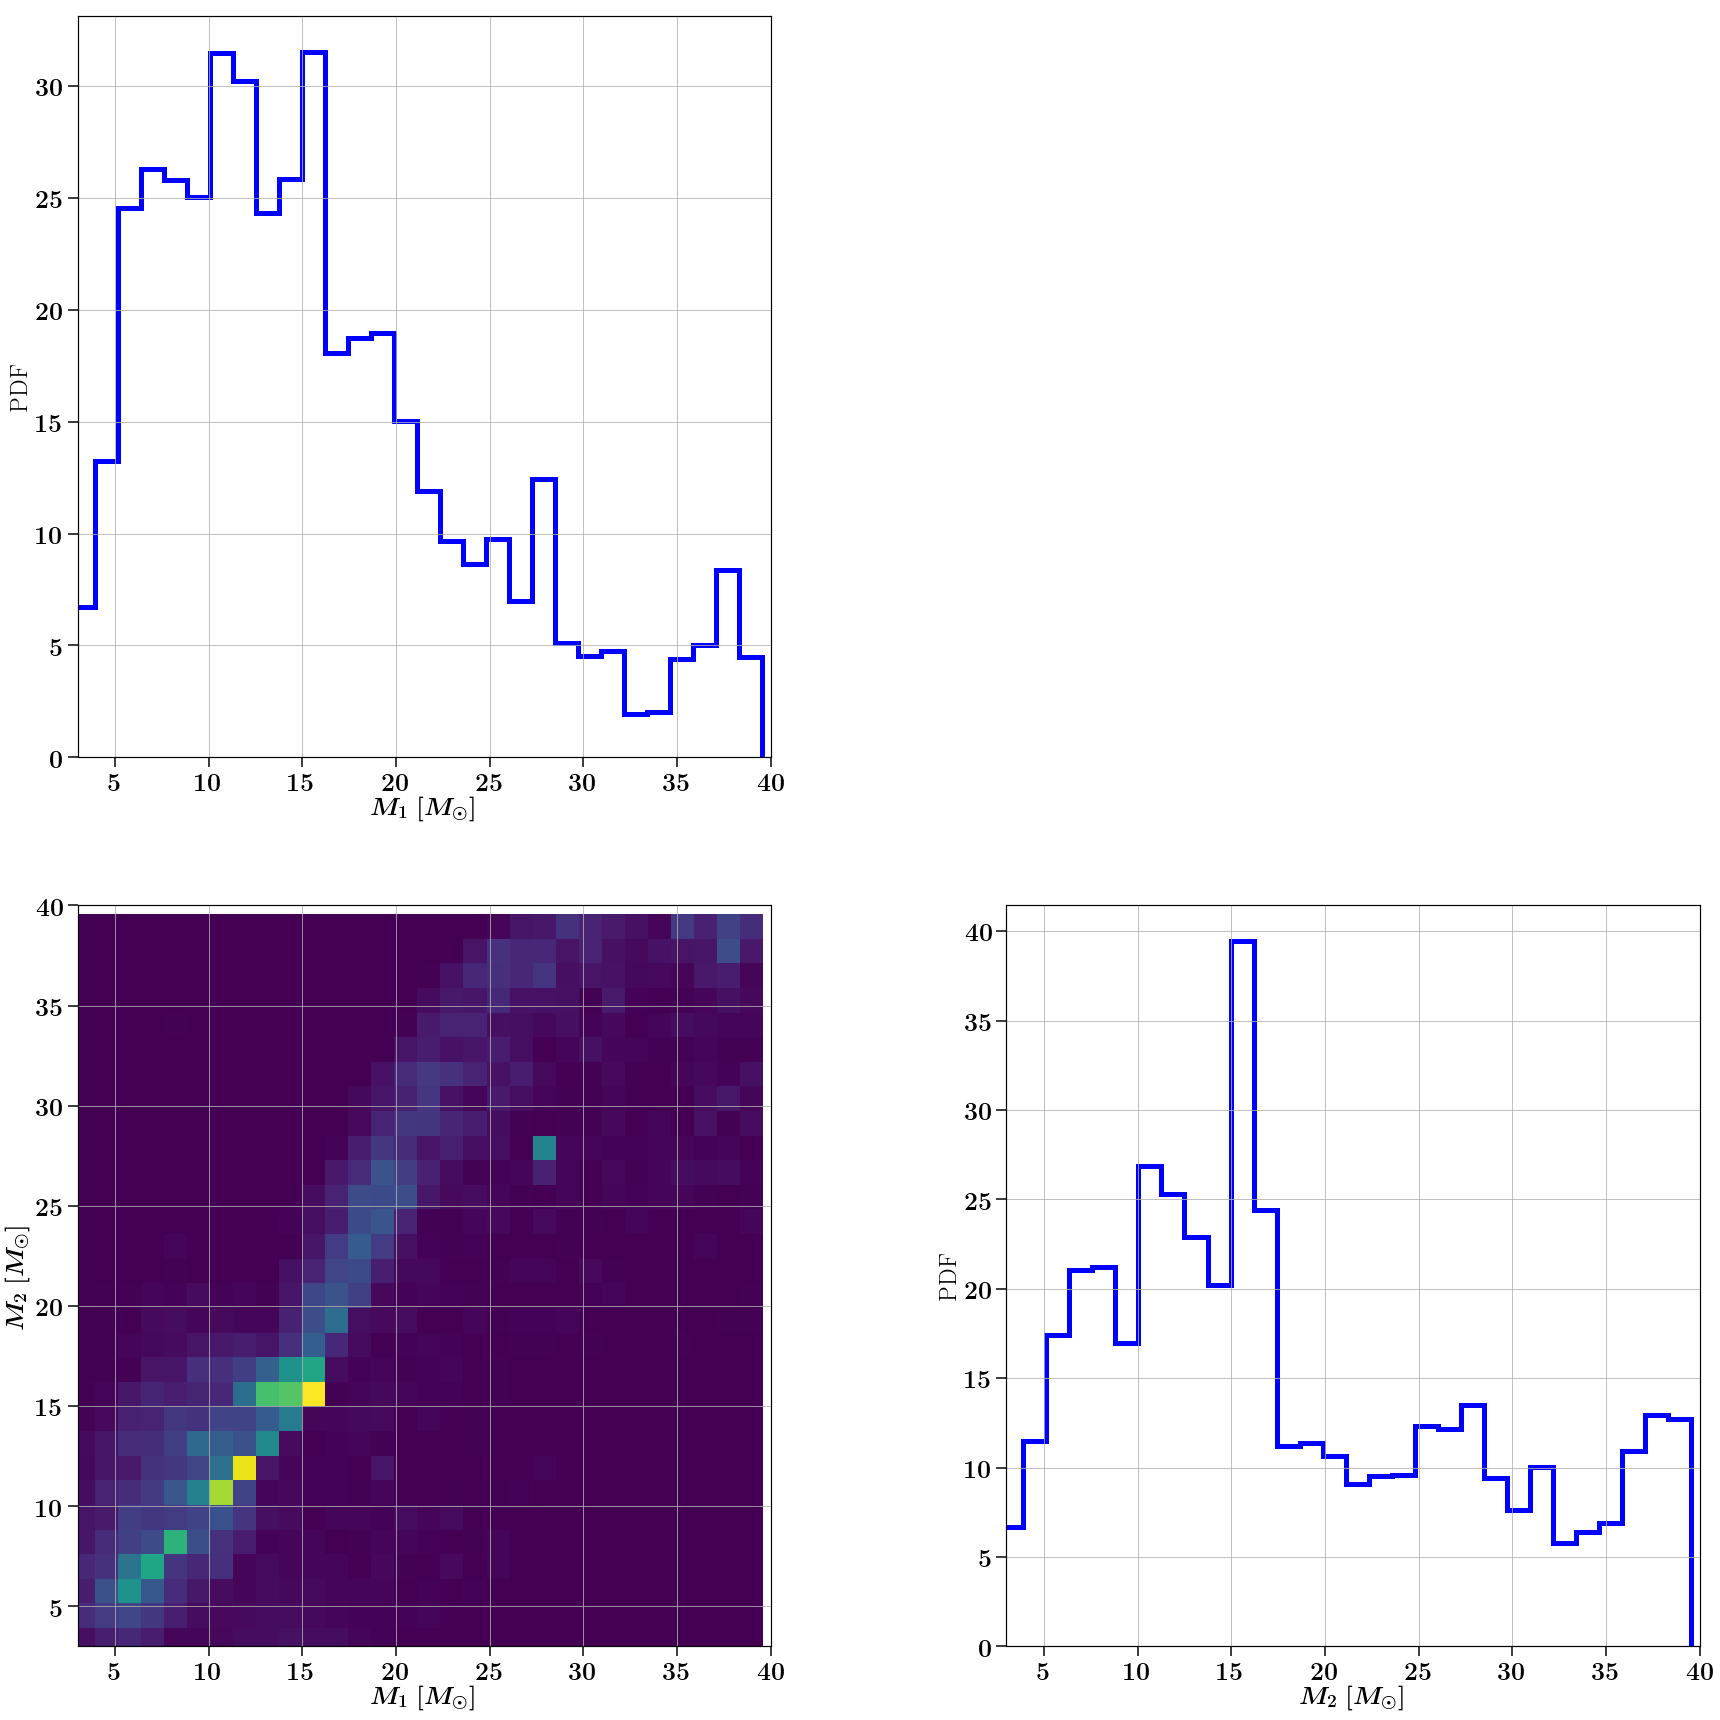

('at model =', 1)
('ii,jj=', 1, 0)


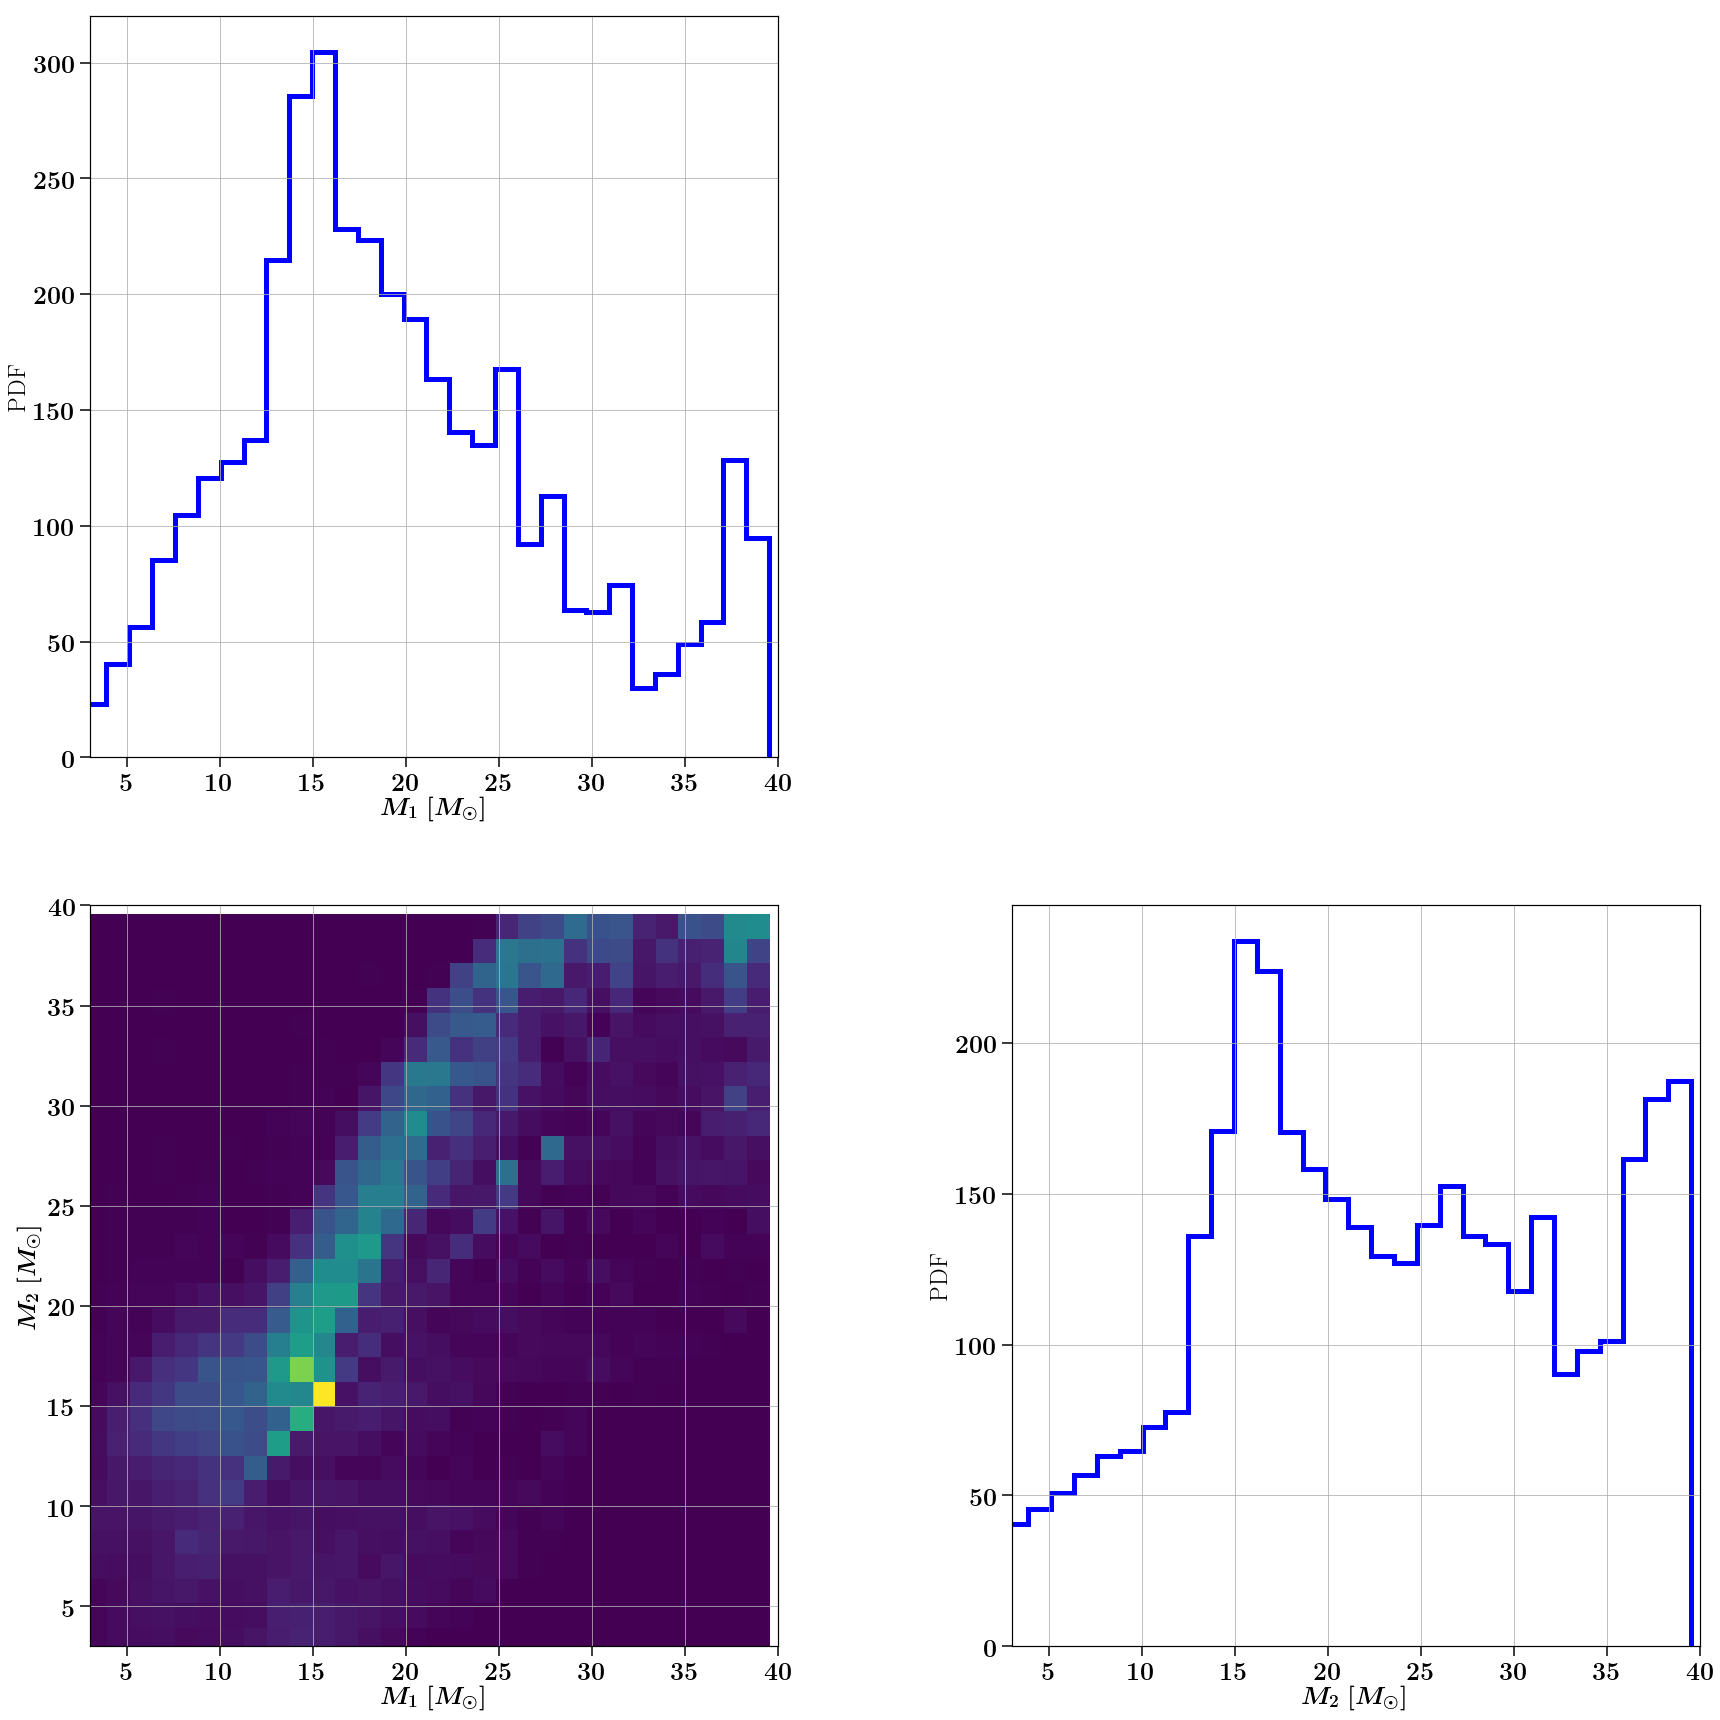

('at model =', 2)
('ii,jj=', 1, 0)


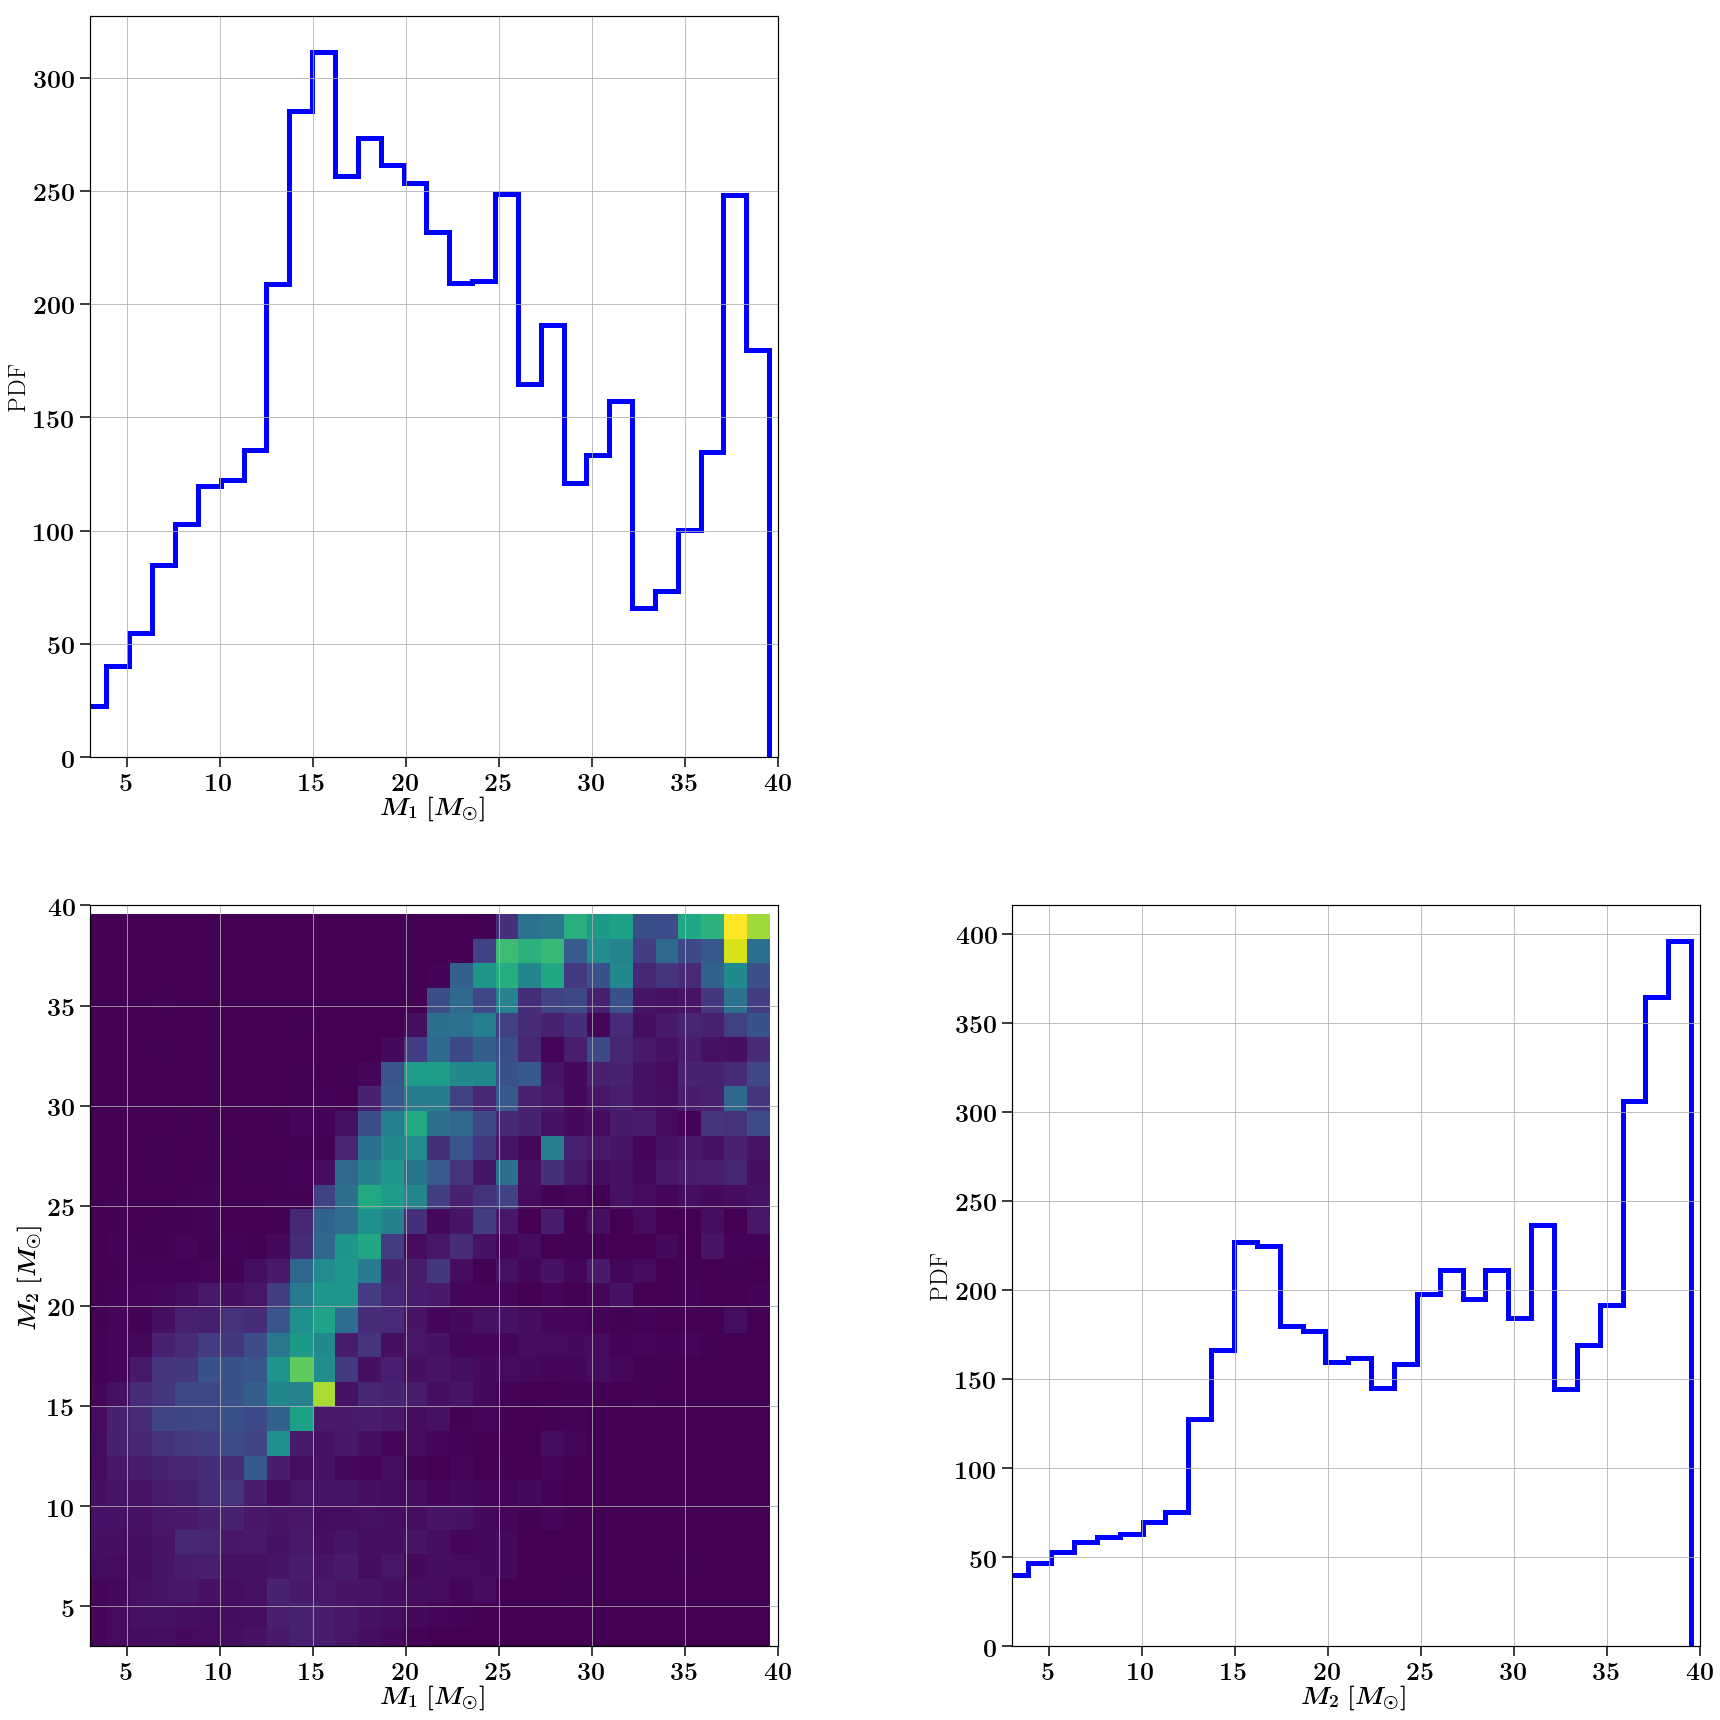

('at model =', 3)
('ii,jj=', 1, 0)


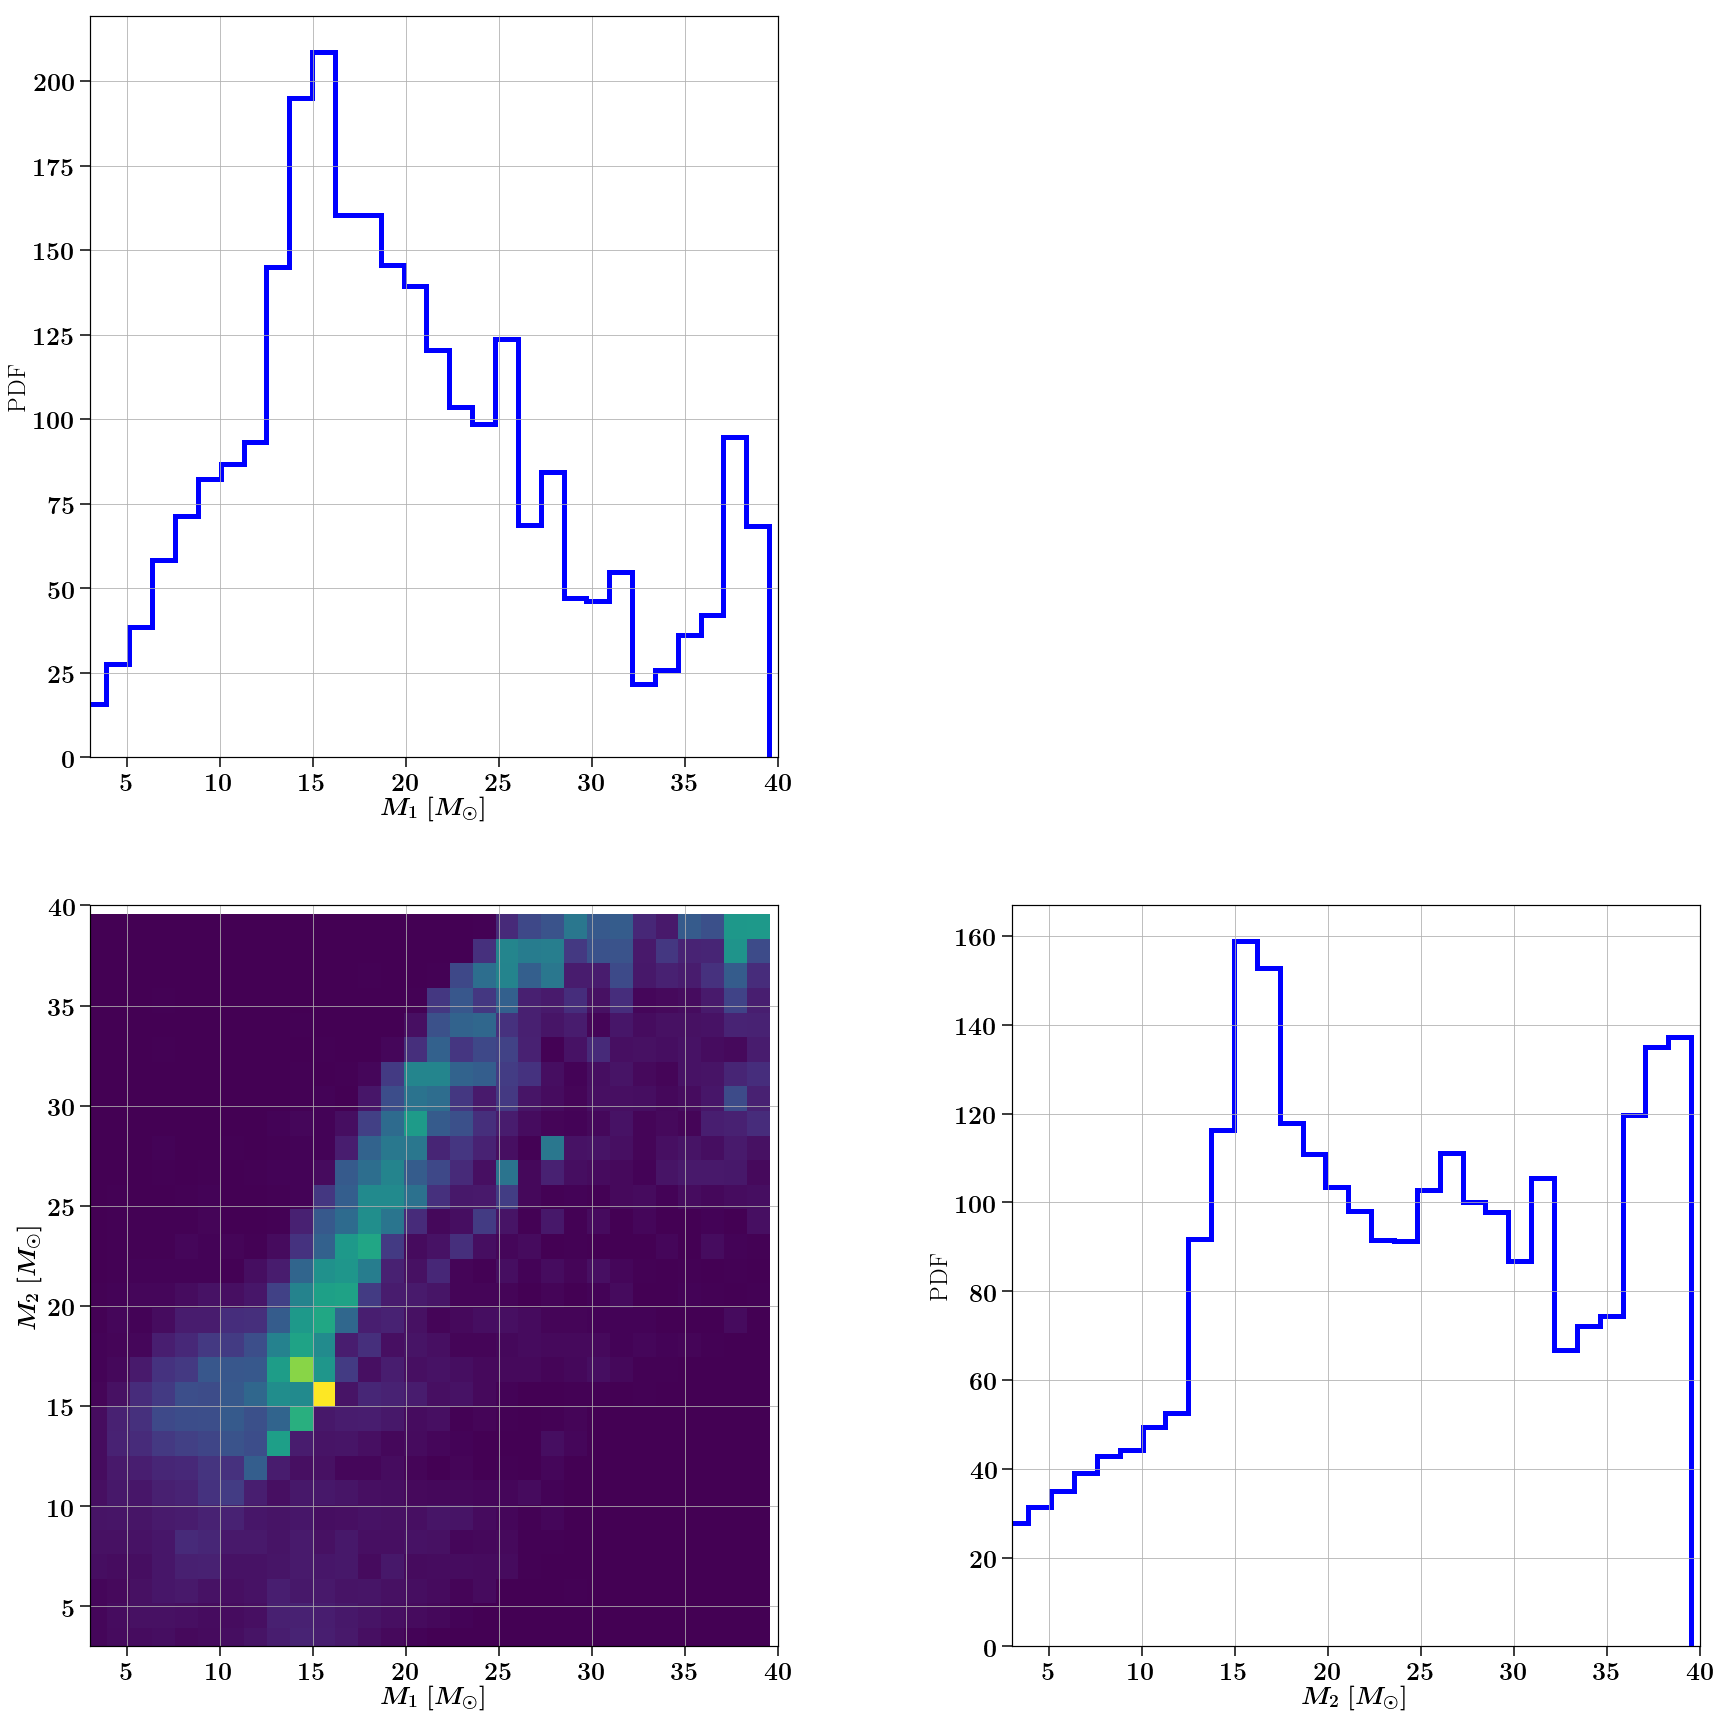

('at model =', 4)
('ii,jj=', 1, 0)


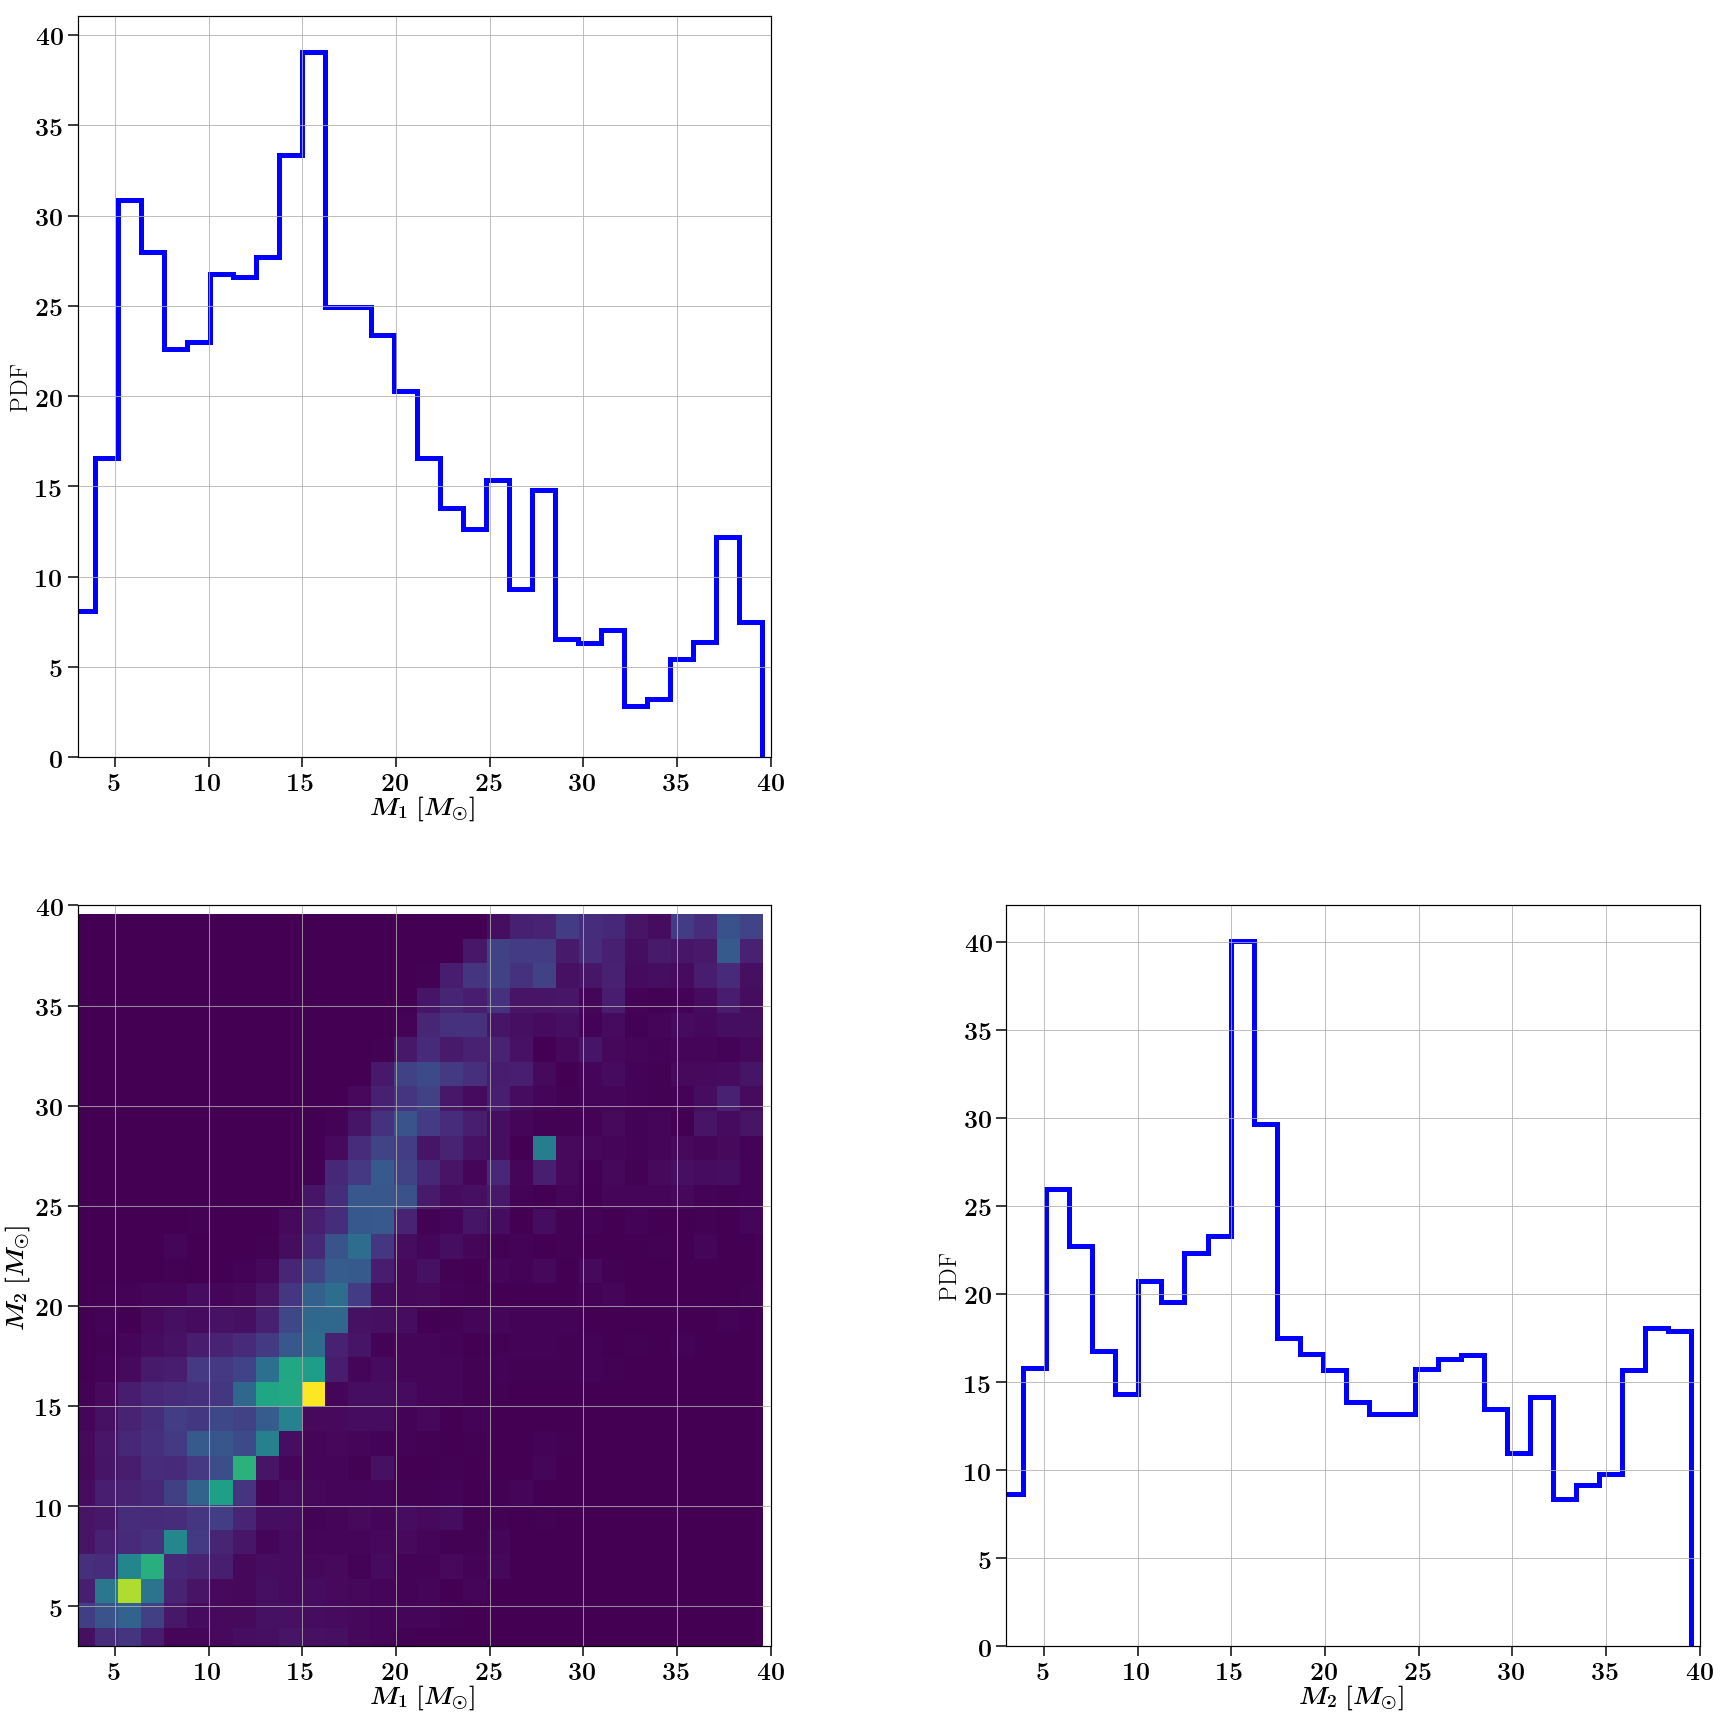

('at model =', 5)
('ii,jj=', 1, 0)


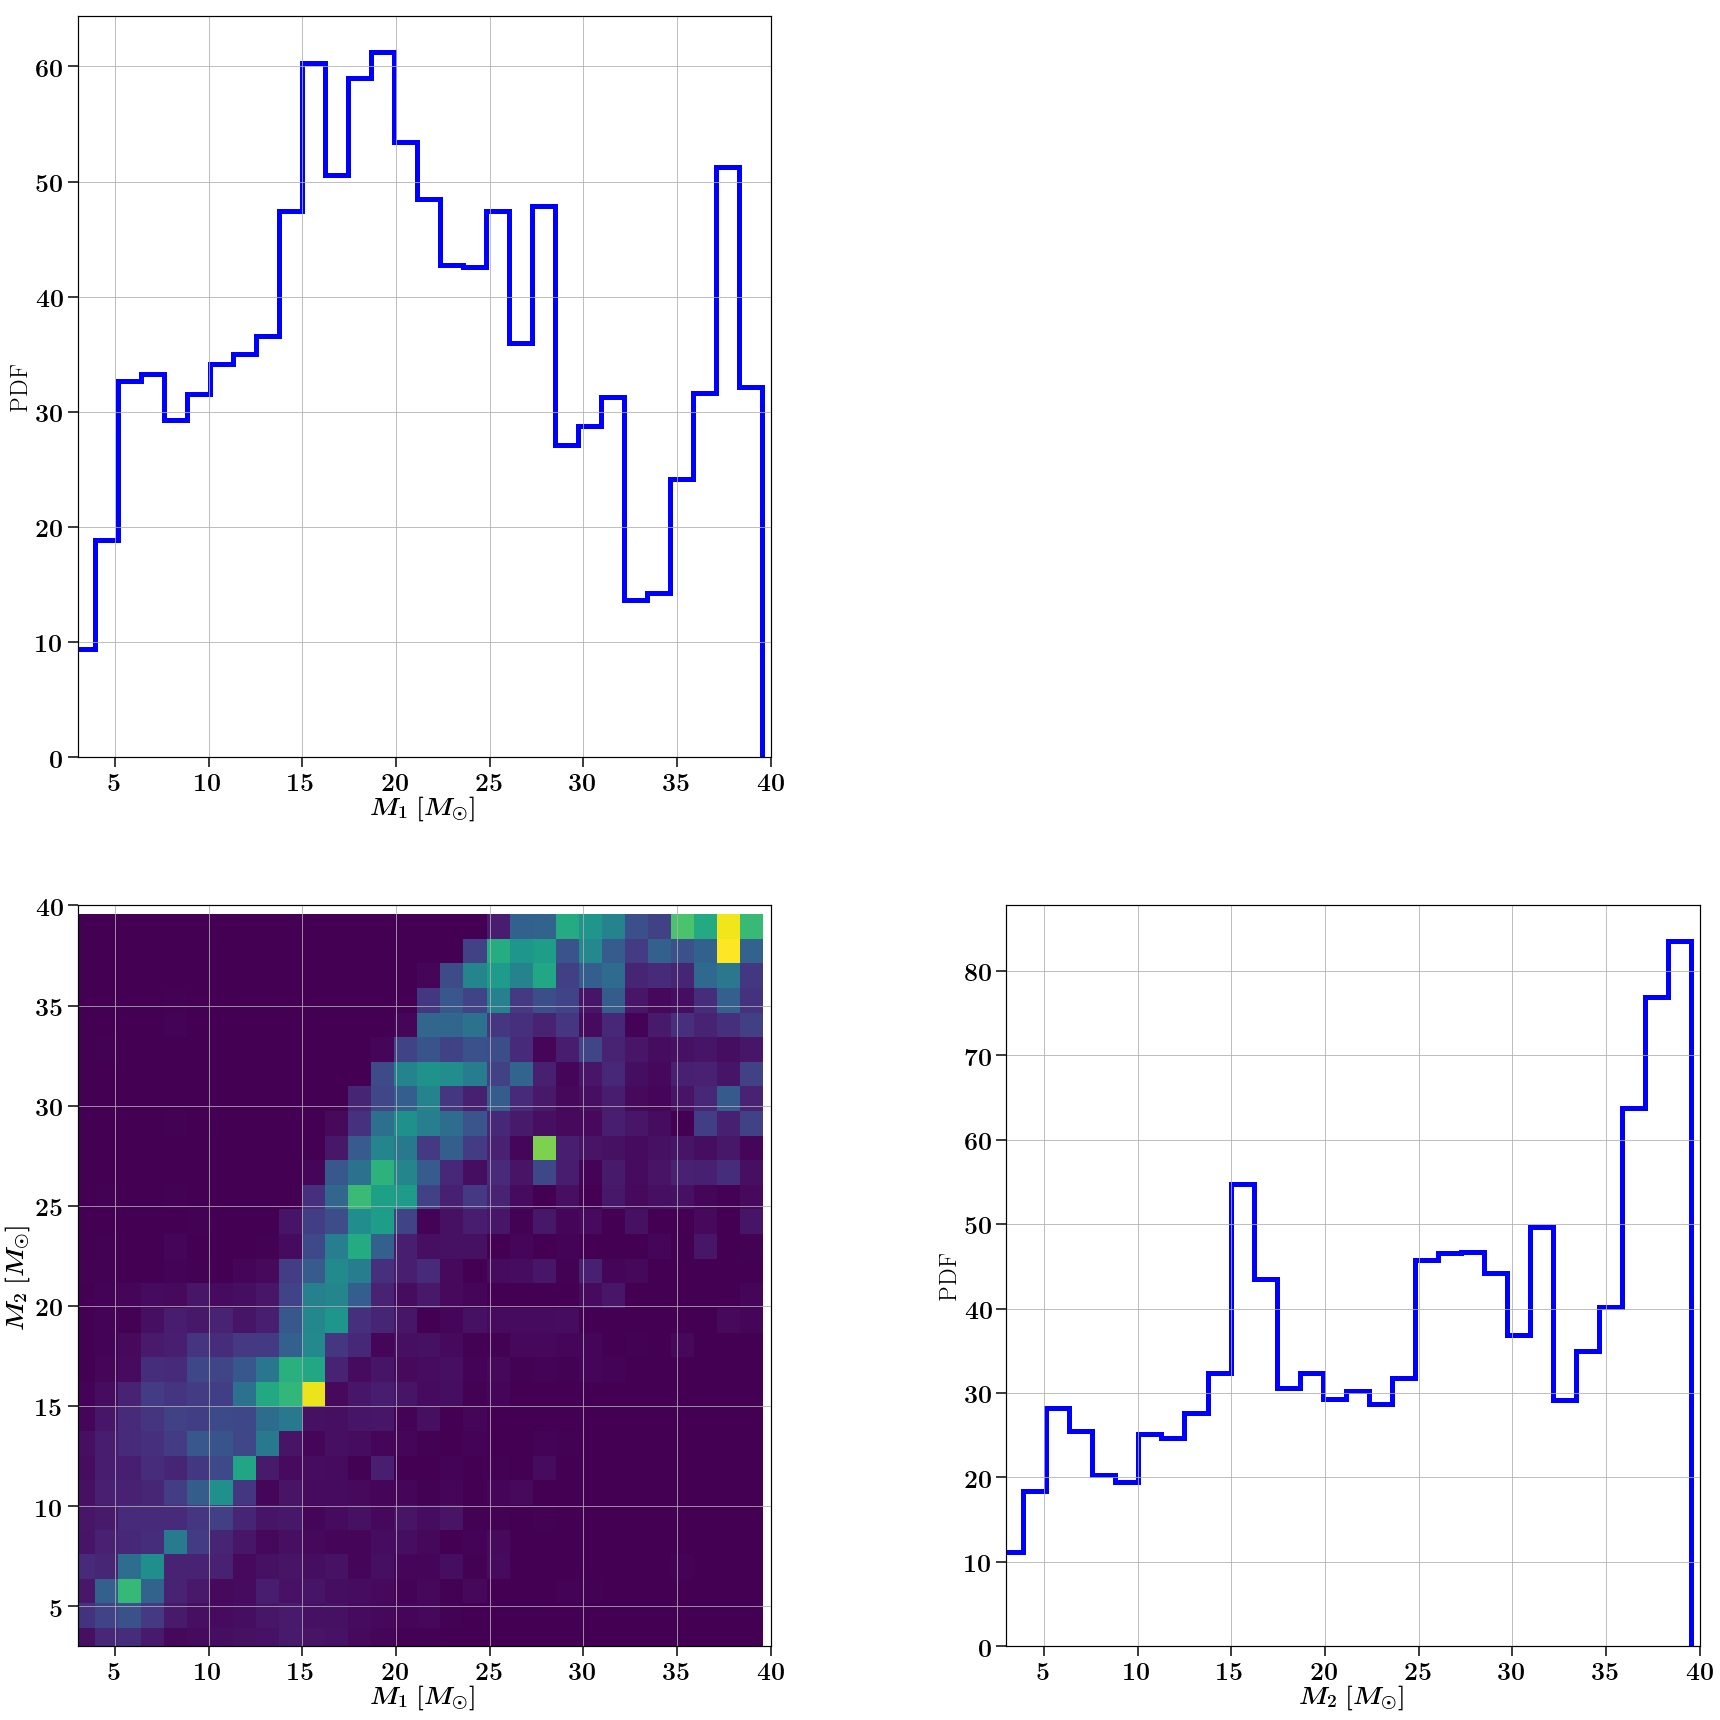

('at model =', 6)
('ii,jj=', 1, 0)


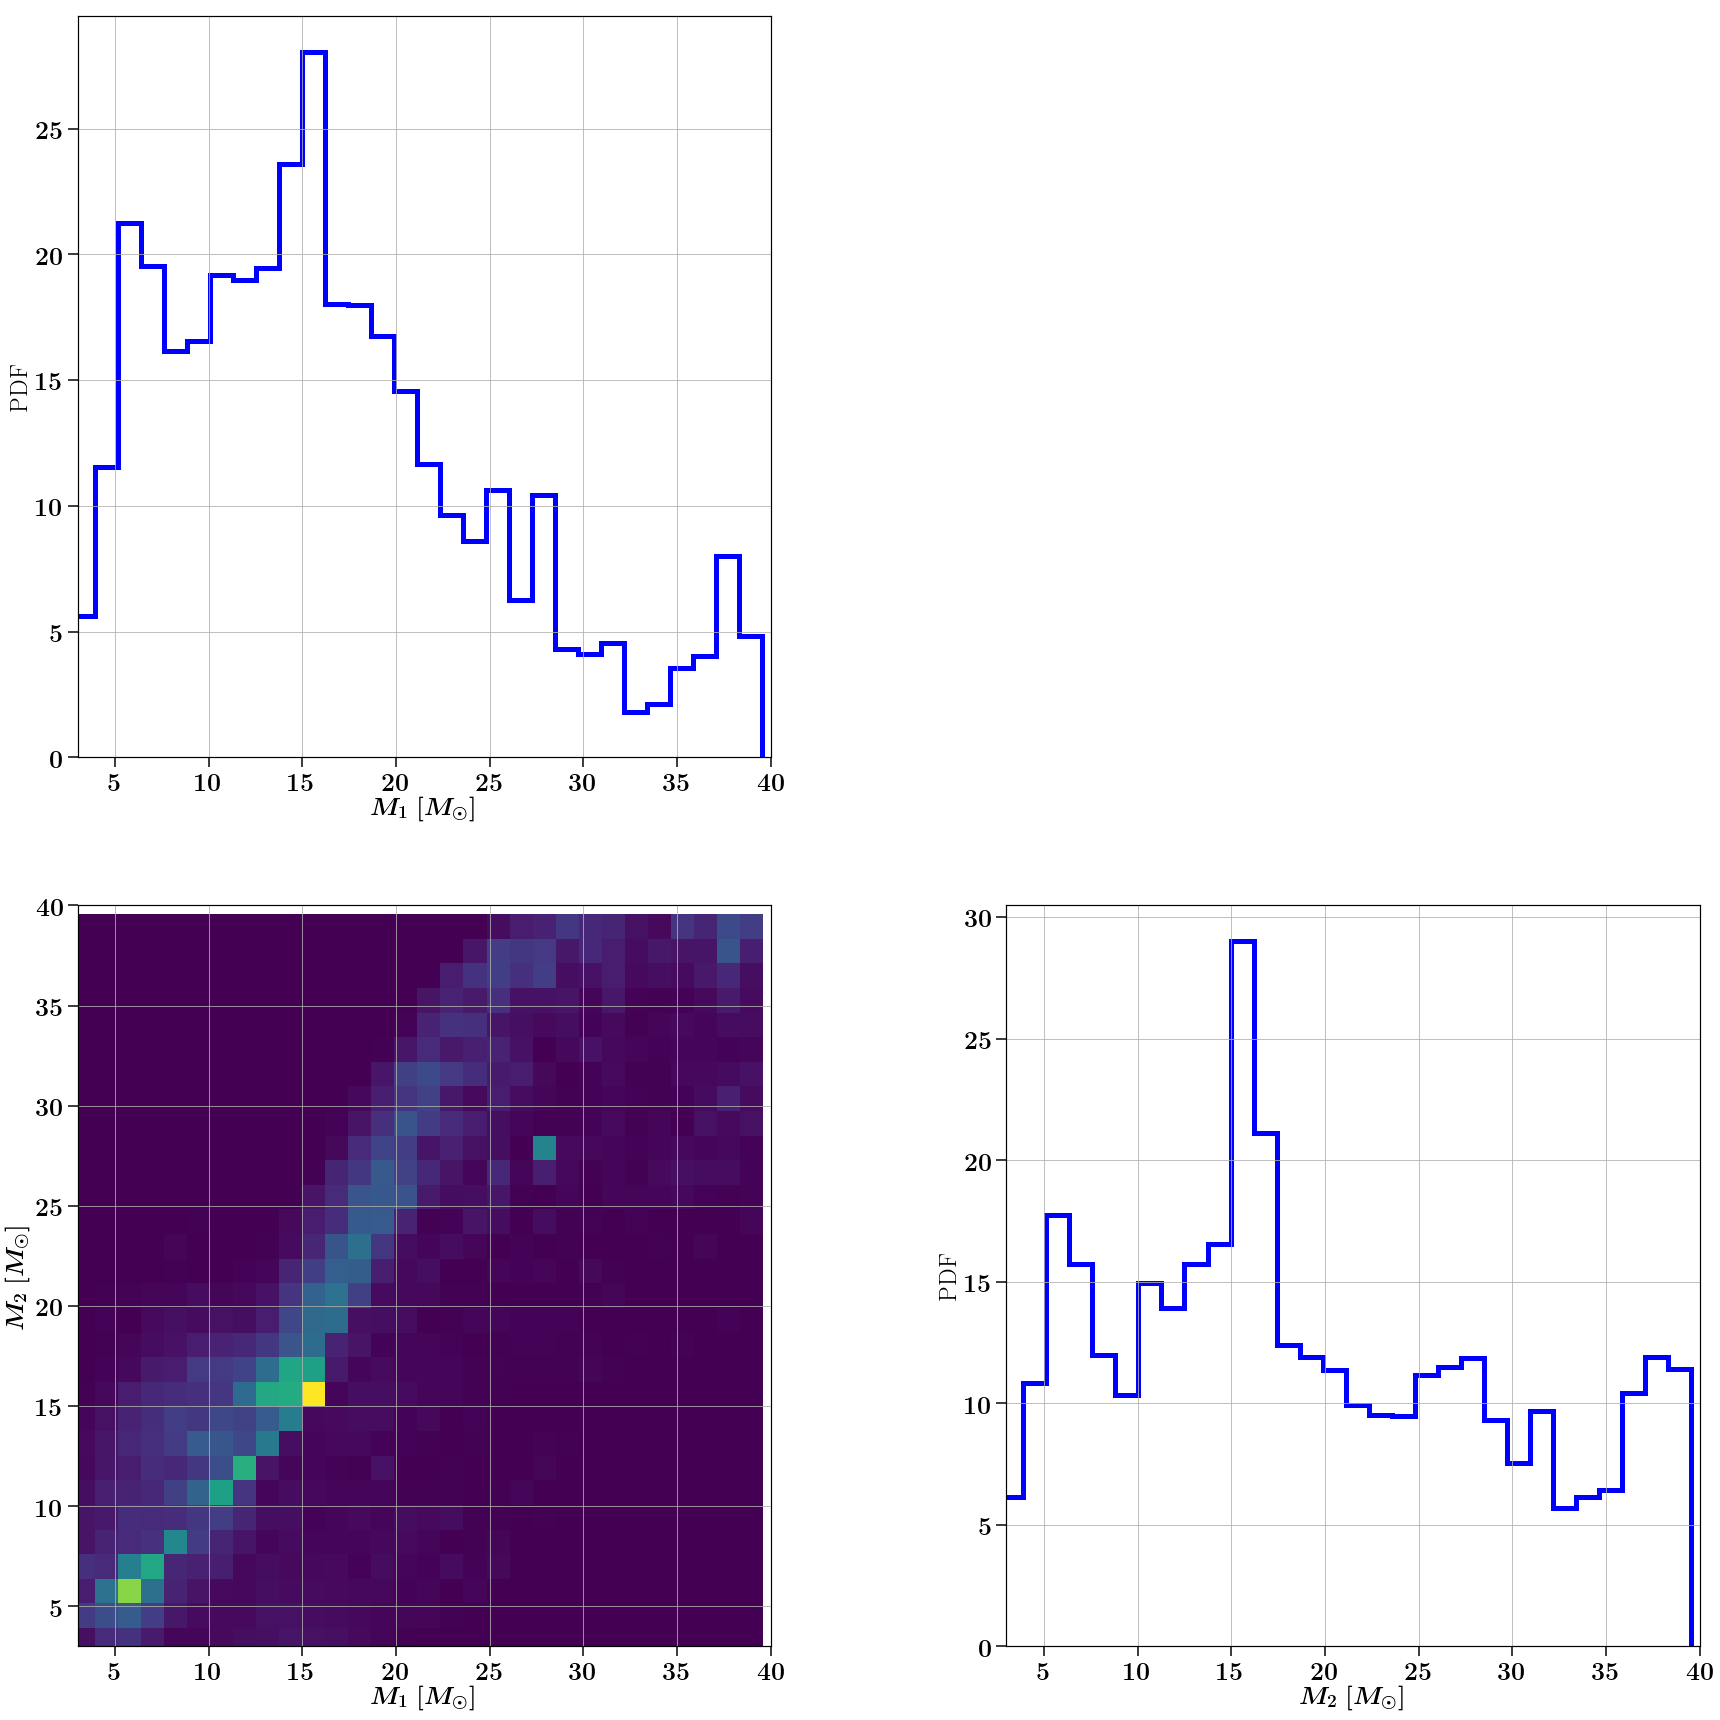

('at model =', 7)
('ii,jj=', 1, 0)


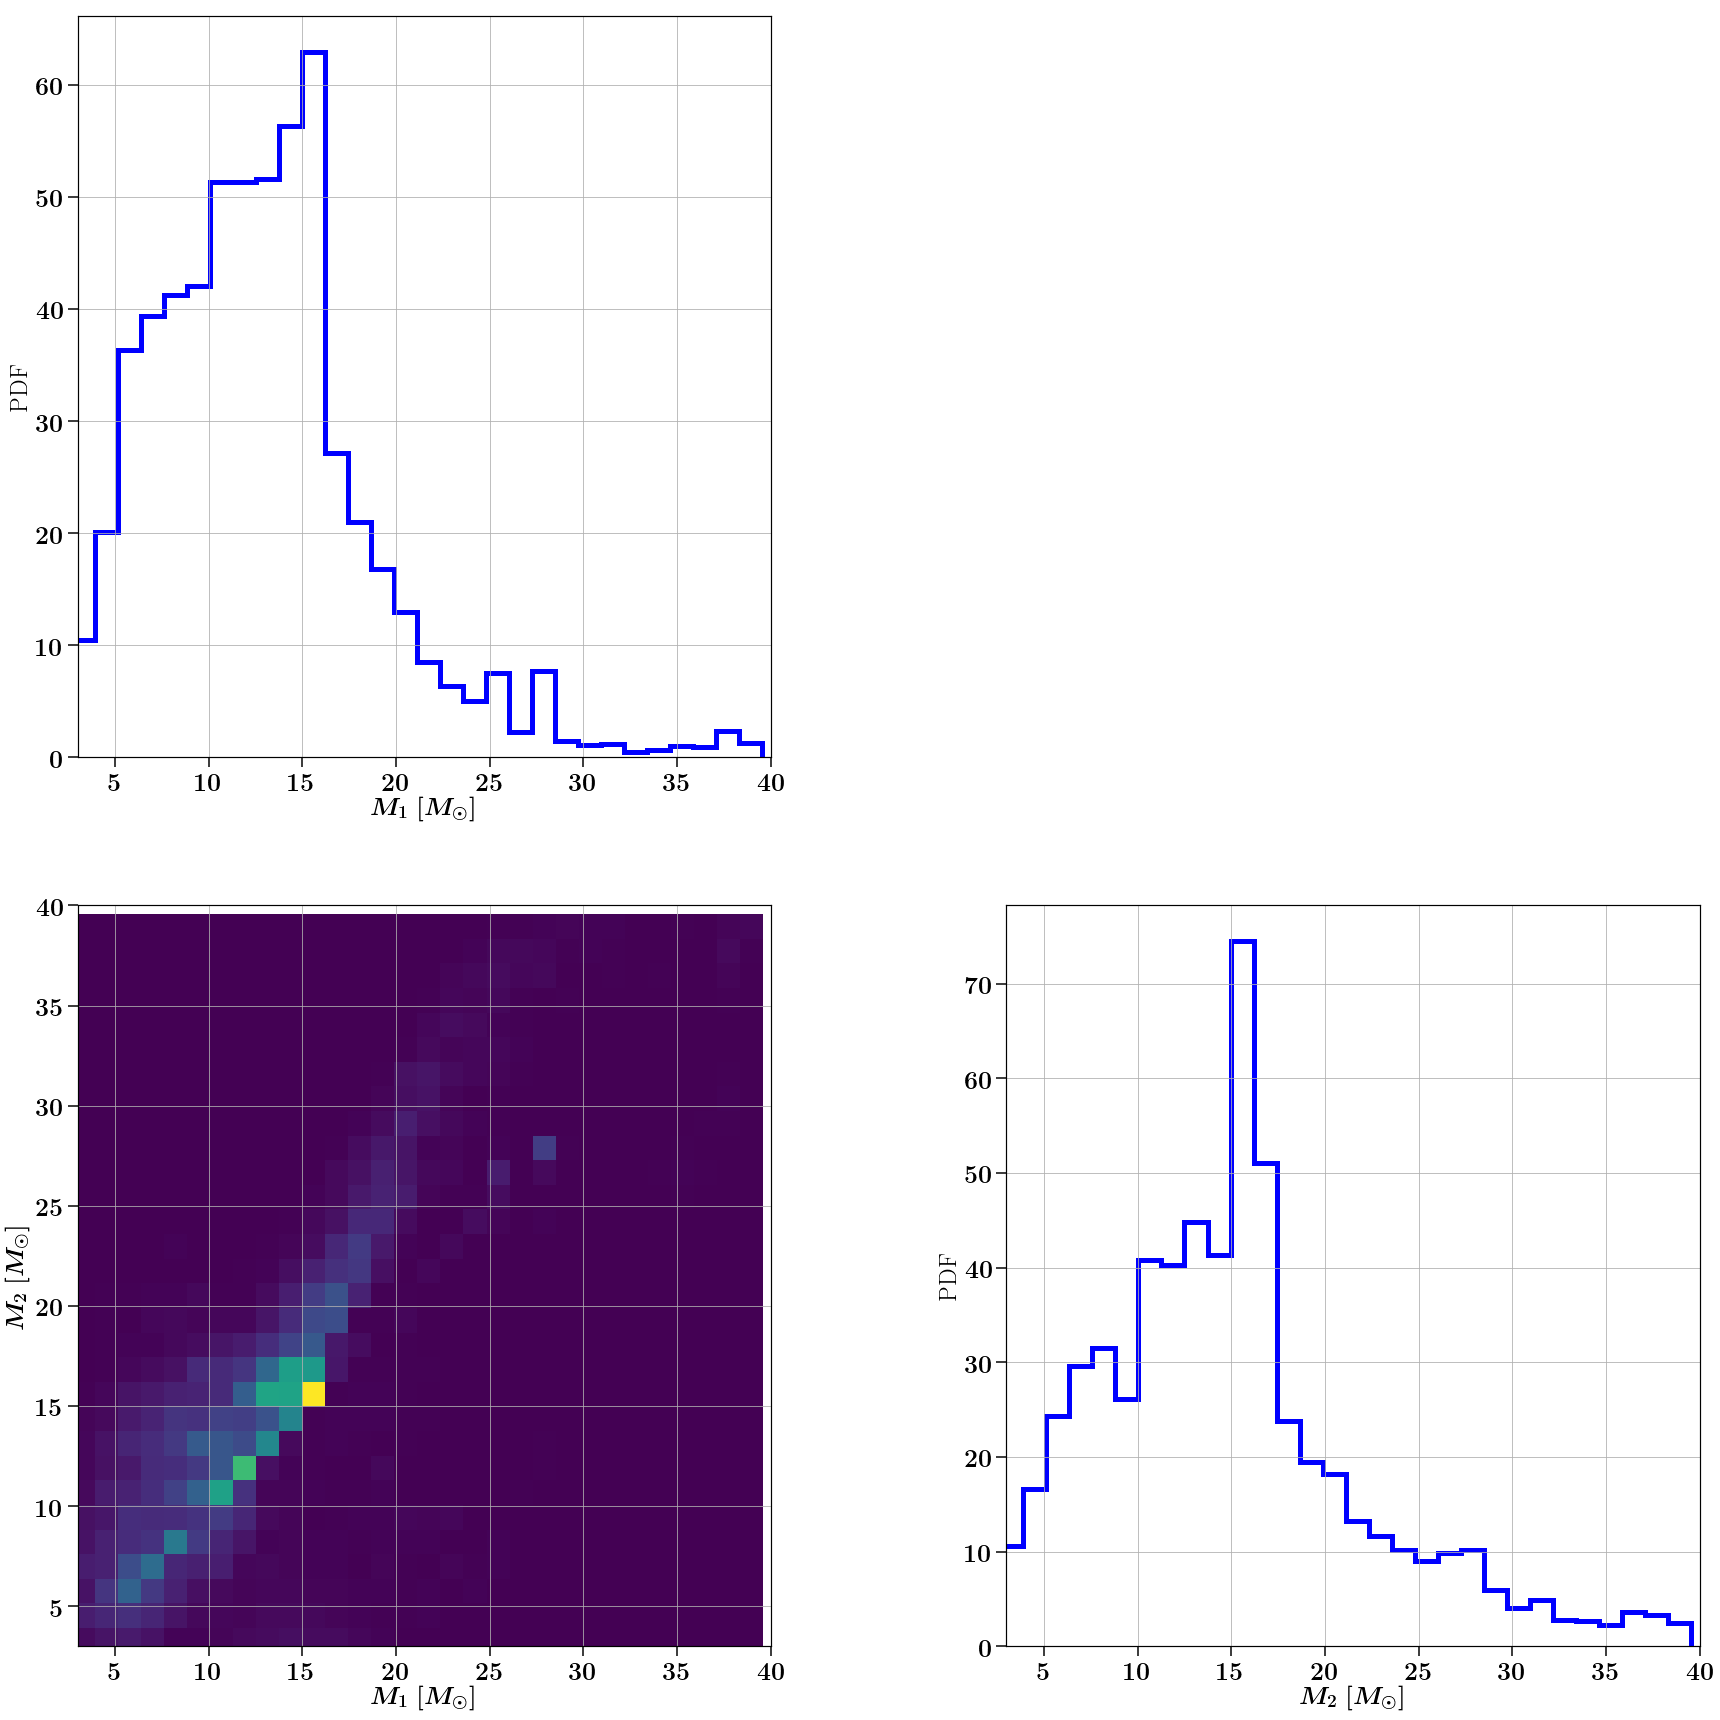

('at model =', 8)
('ii,jj=', 1, 0)


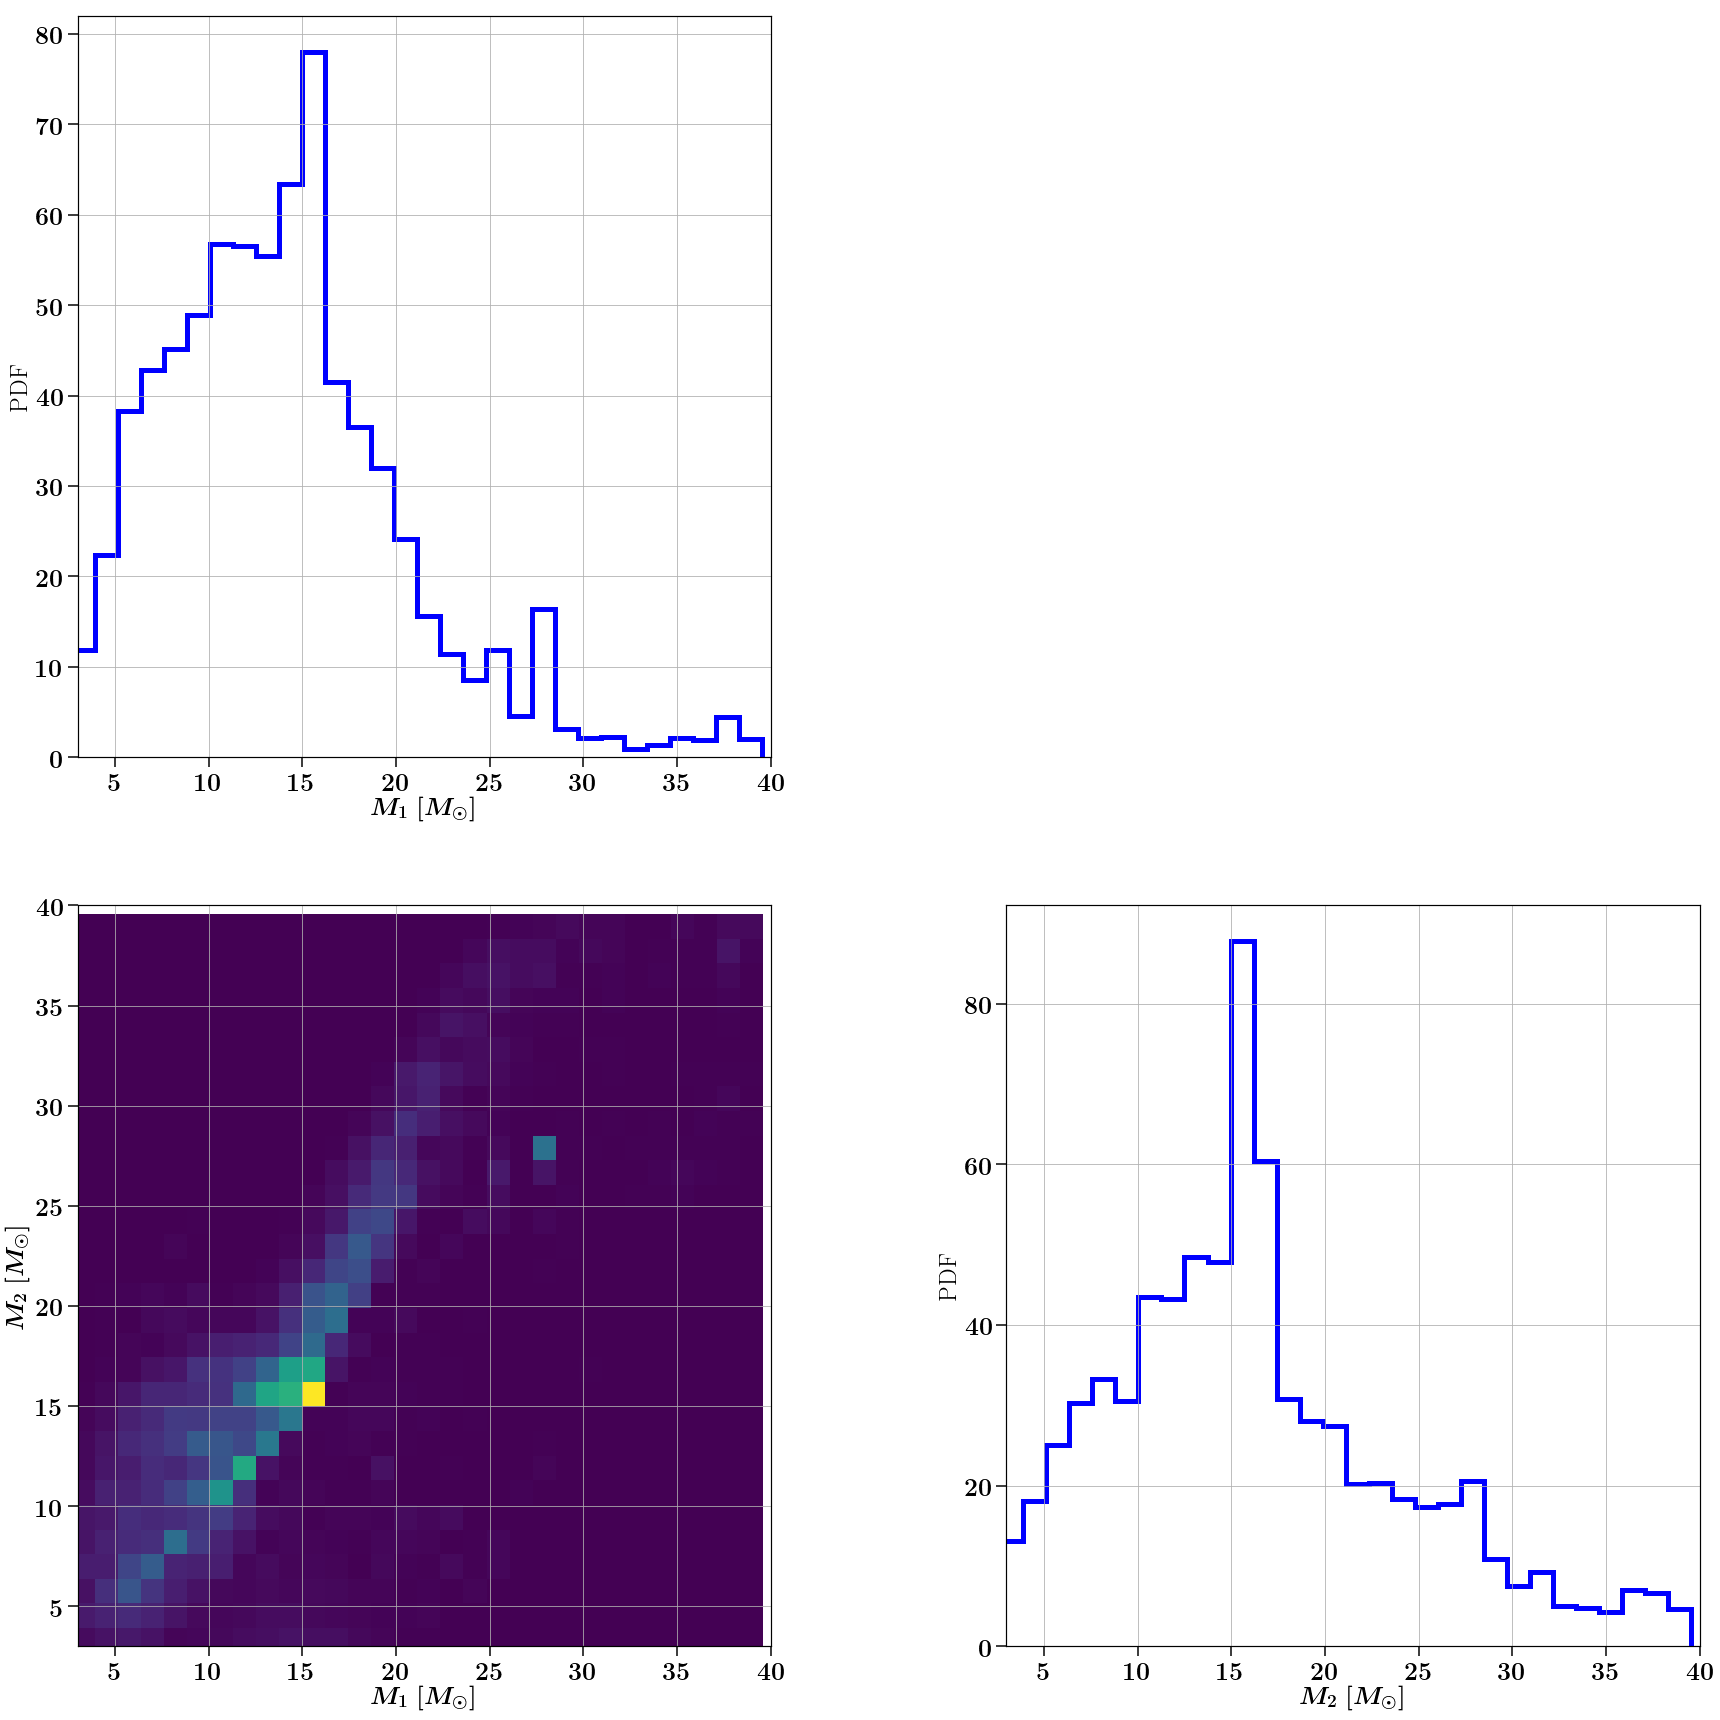

('at model =', 9)
('ii,jj=', 1, 0)


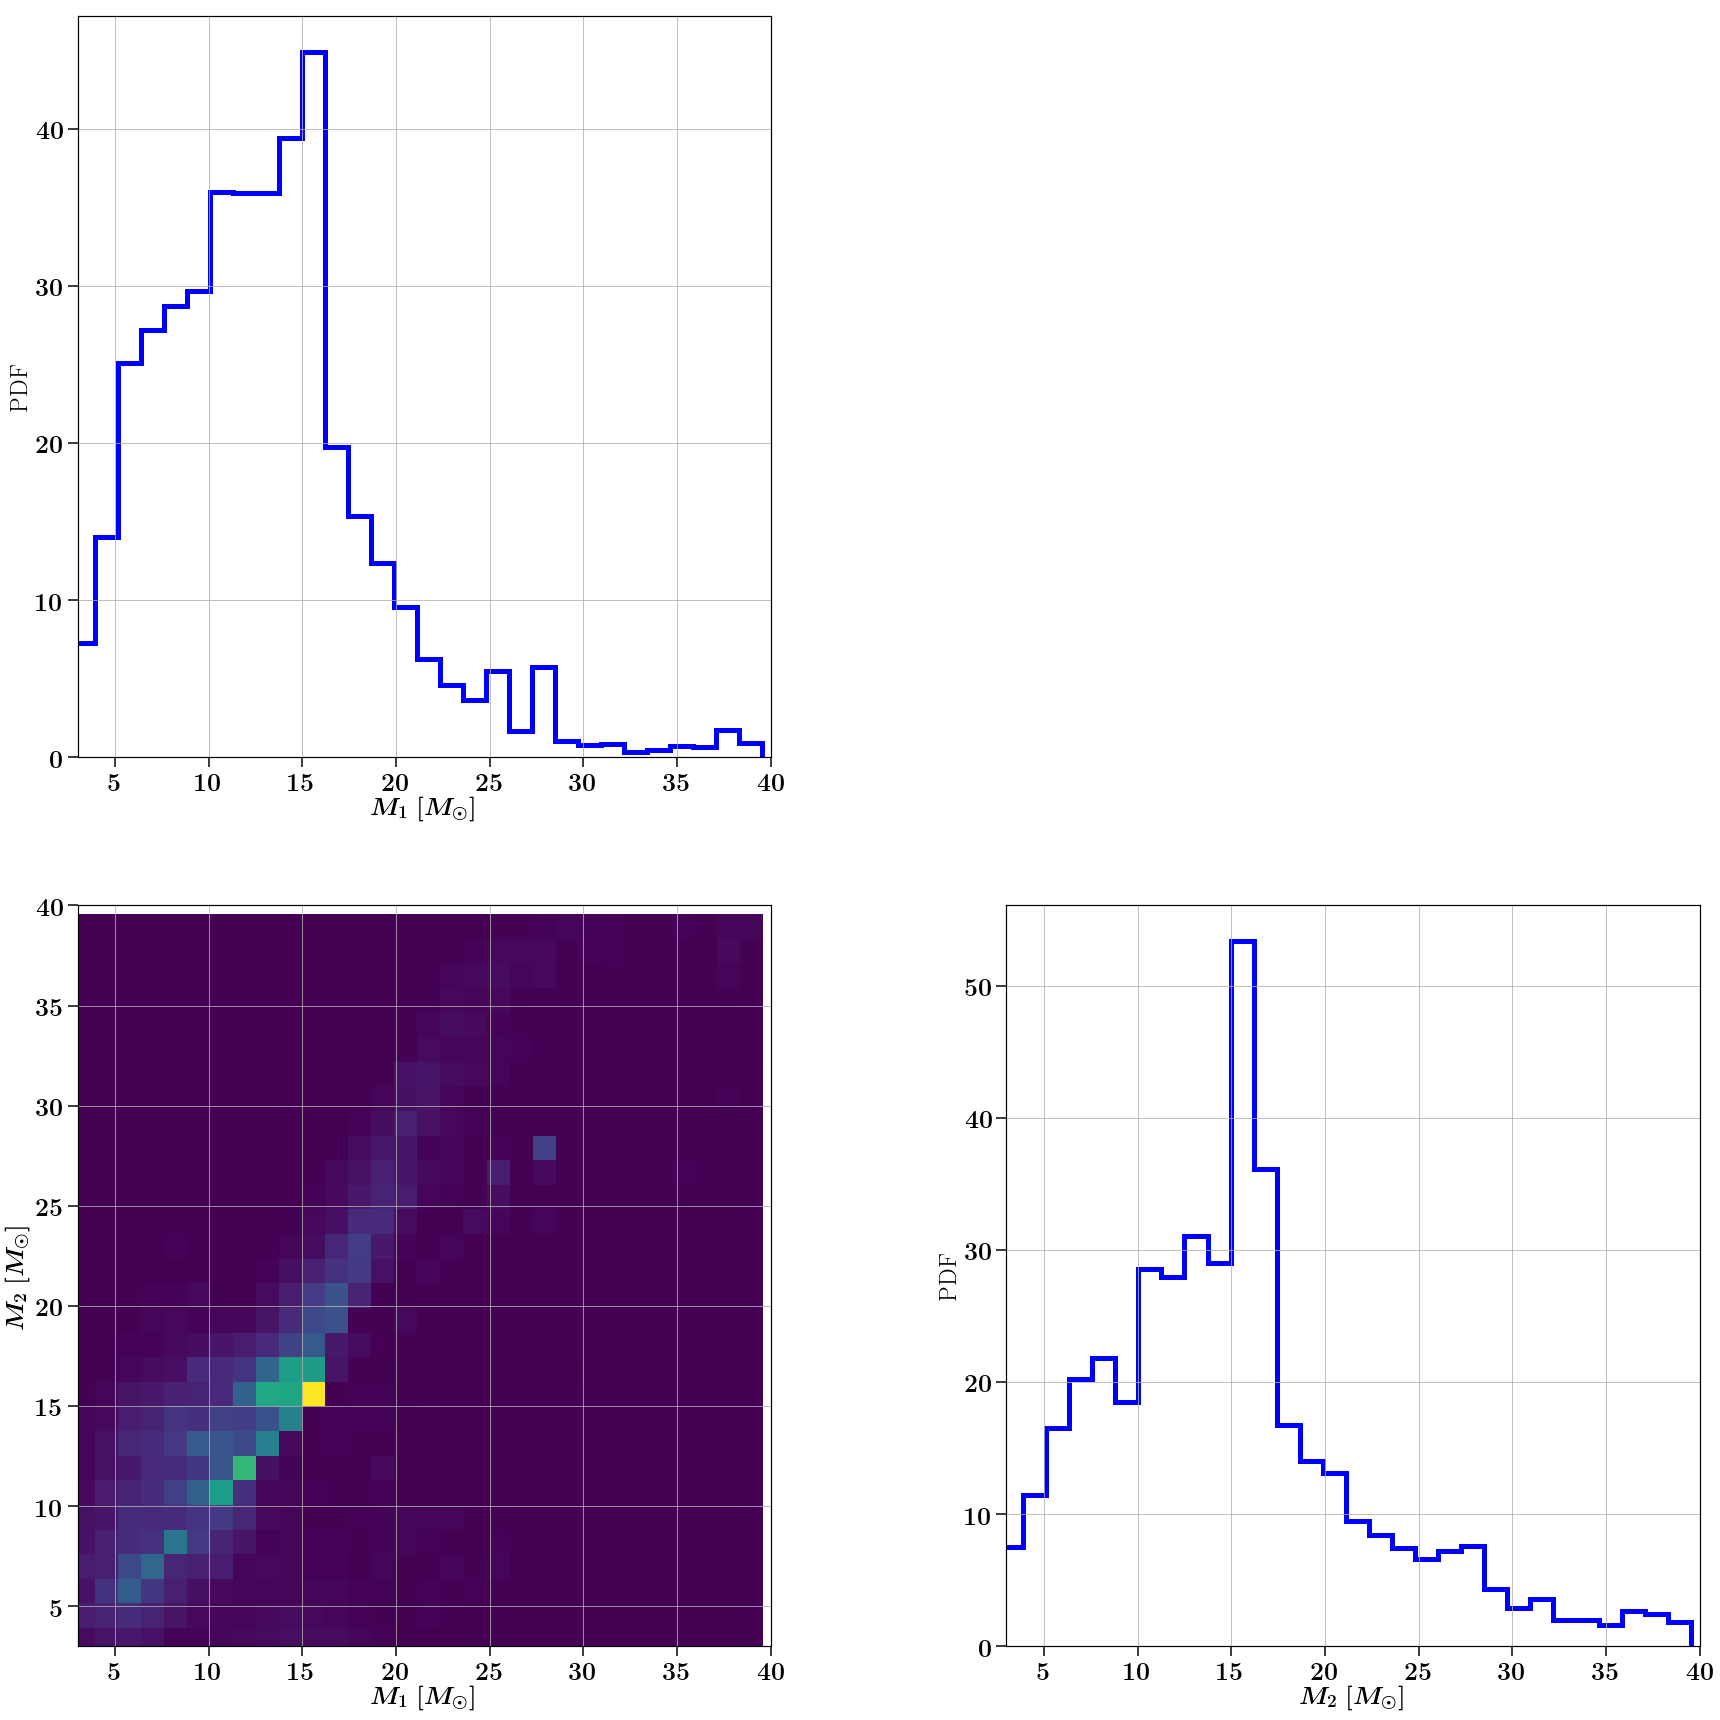

('at model =', 10)
('ii,jj=', 1, 0)


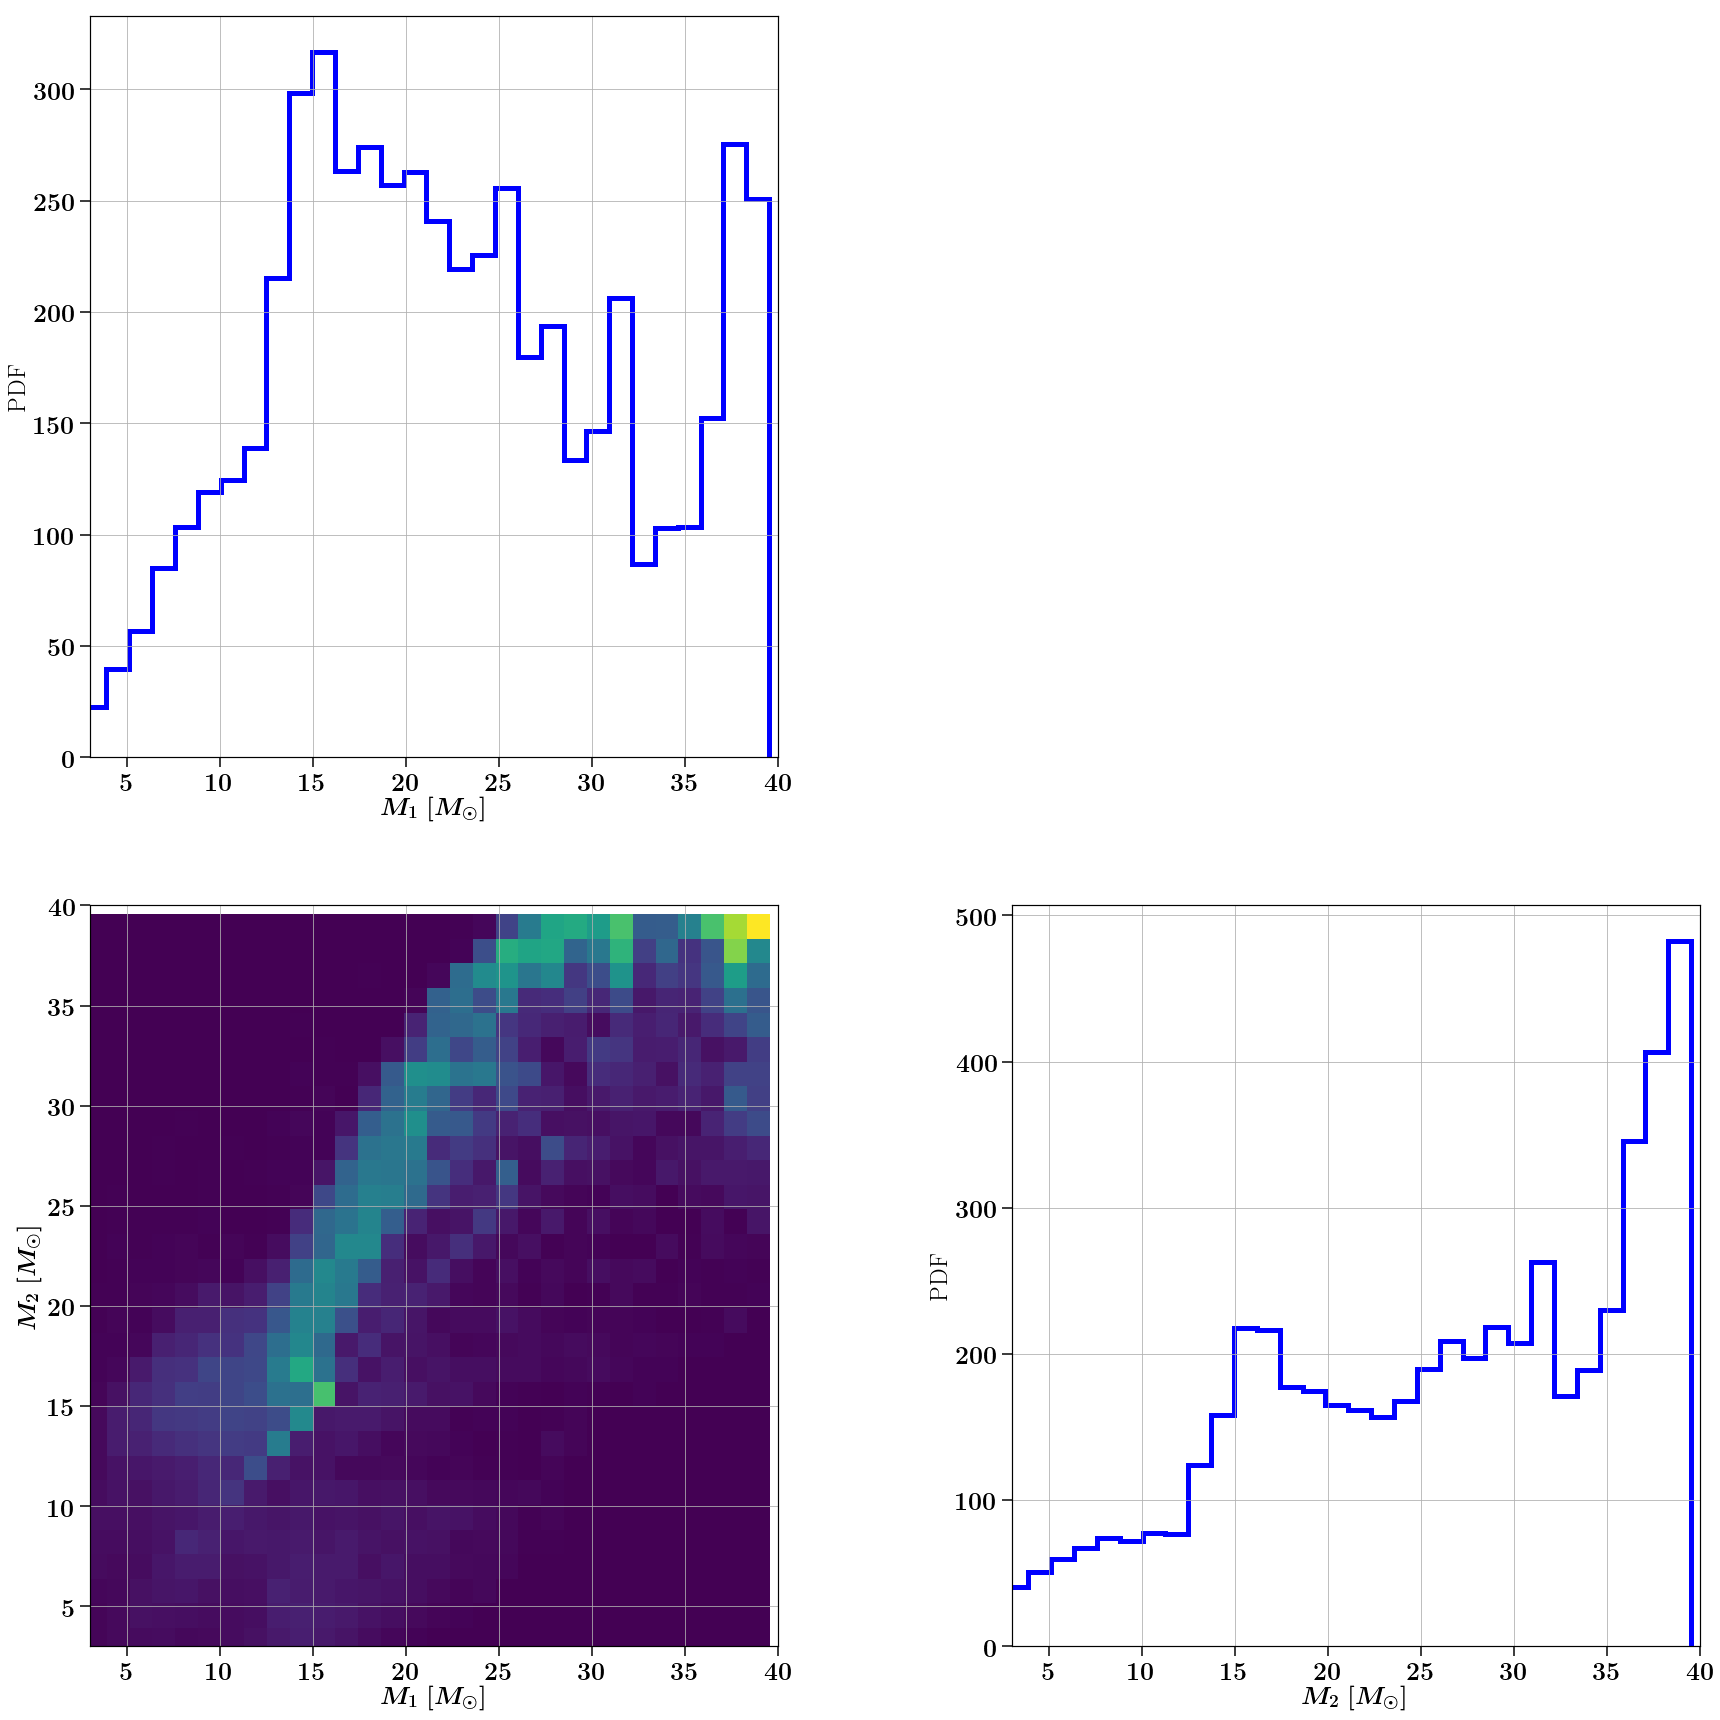

('at model =', 11)
('ii,jj=', 1, 0)


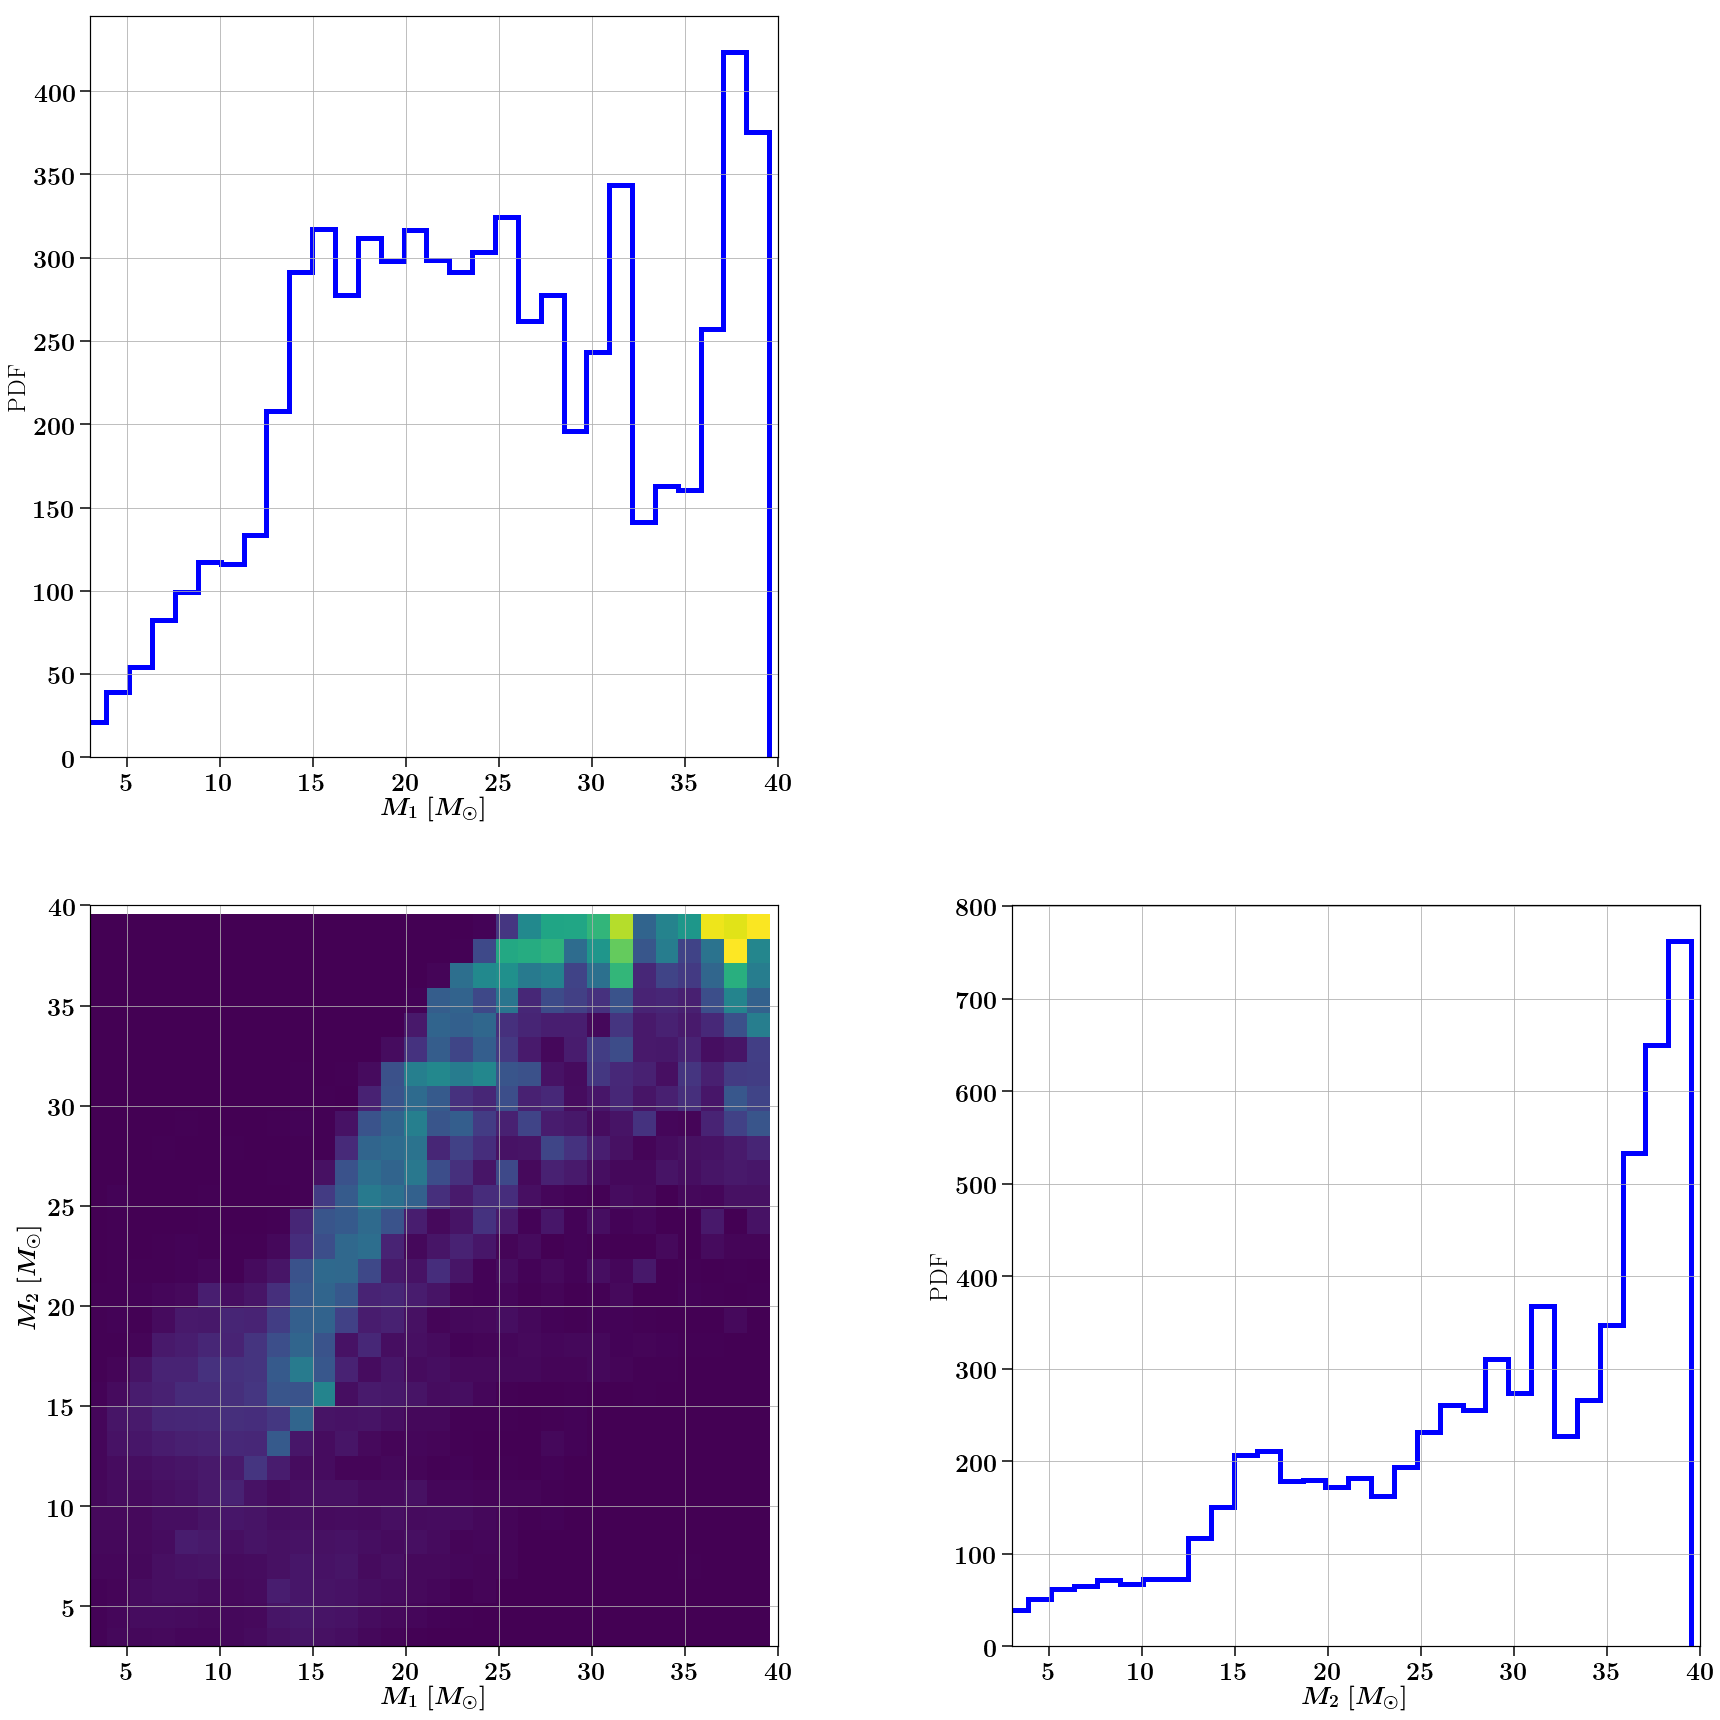

('at model =', 12)
('ii,jj=', 1, 0)


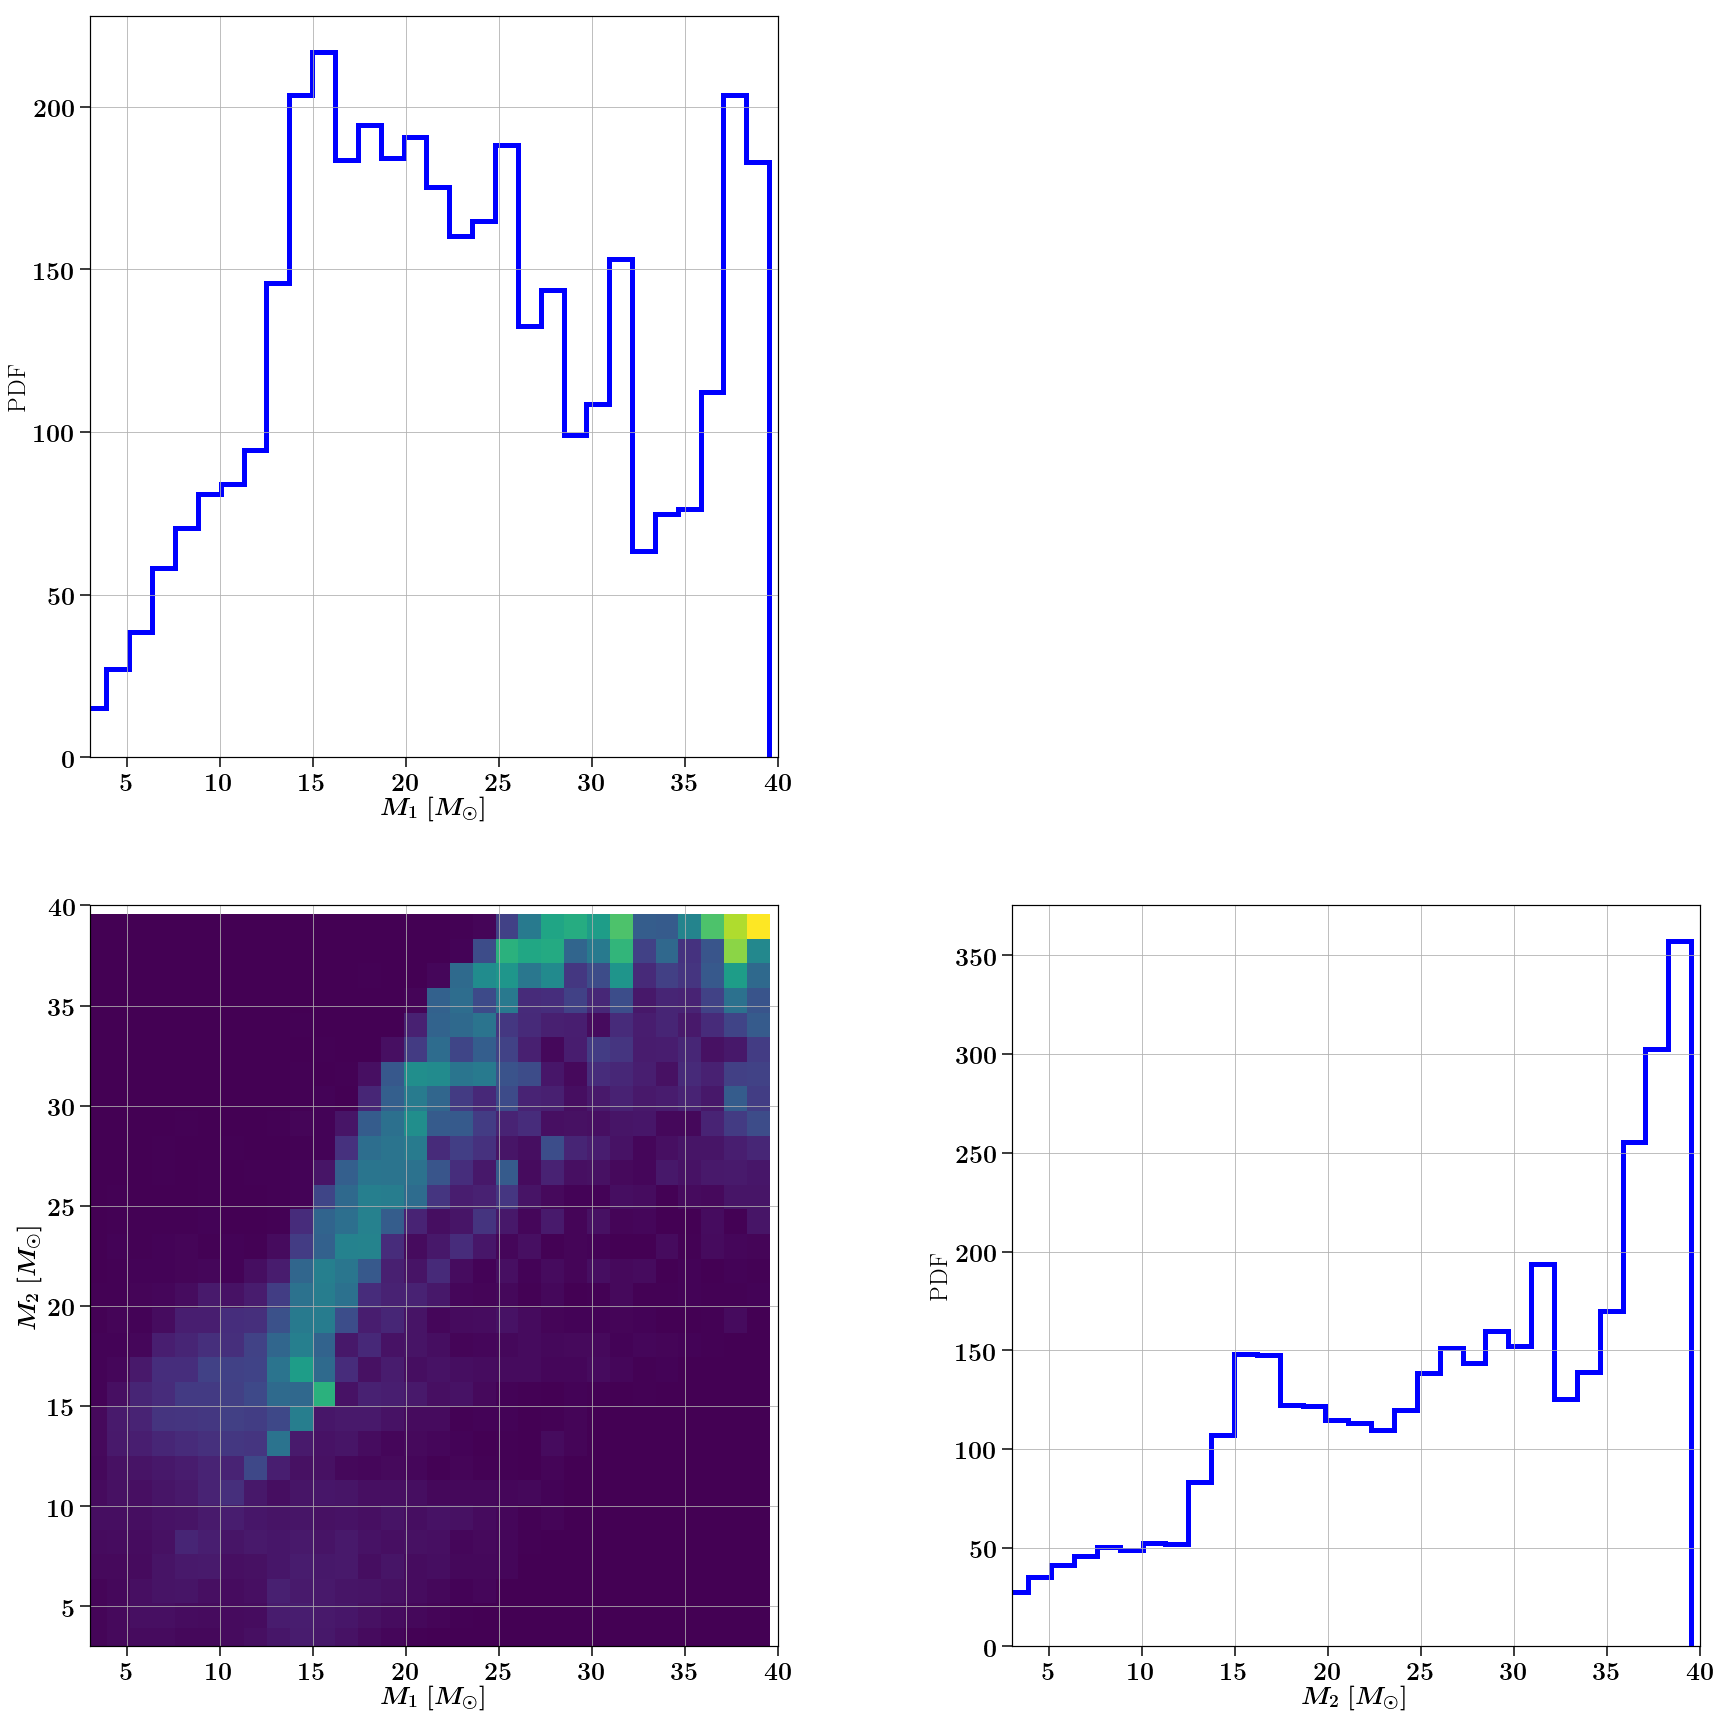

('at model =', 13)
('ii,jj=', 1, 0)


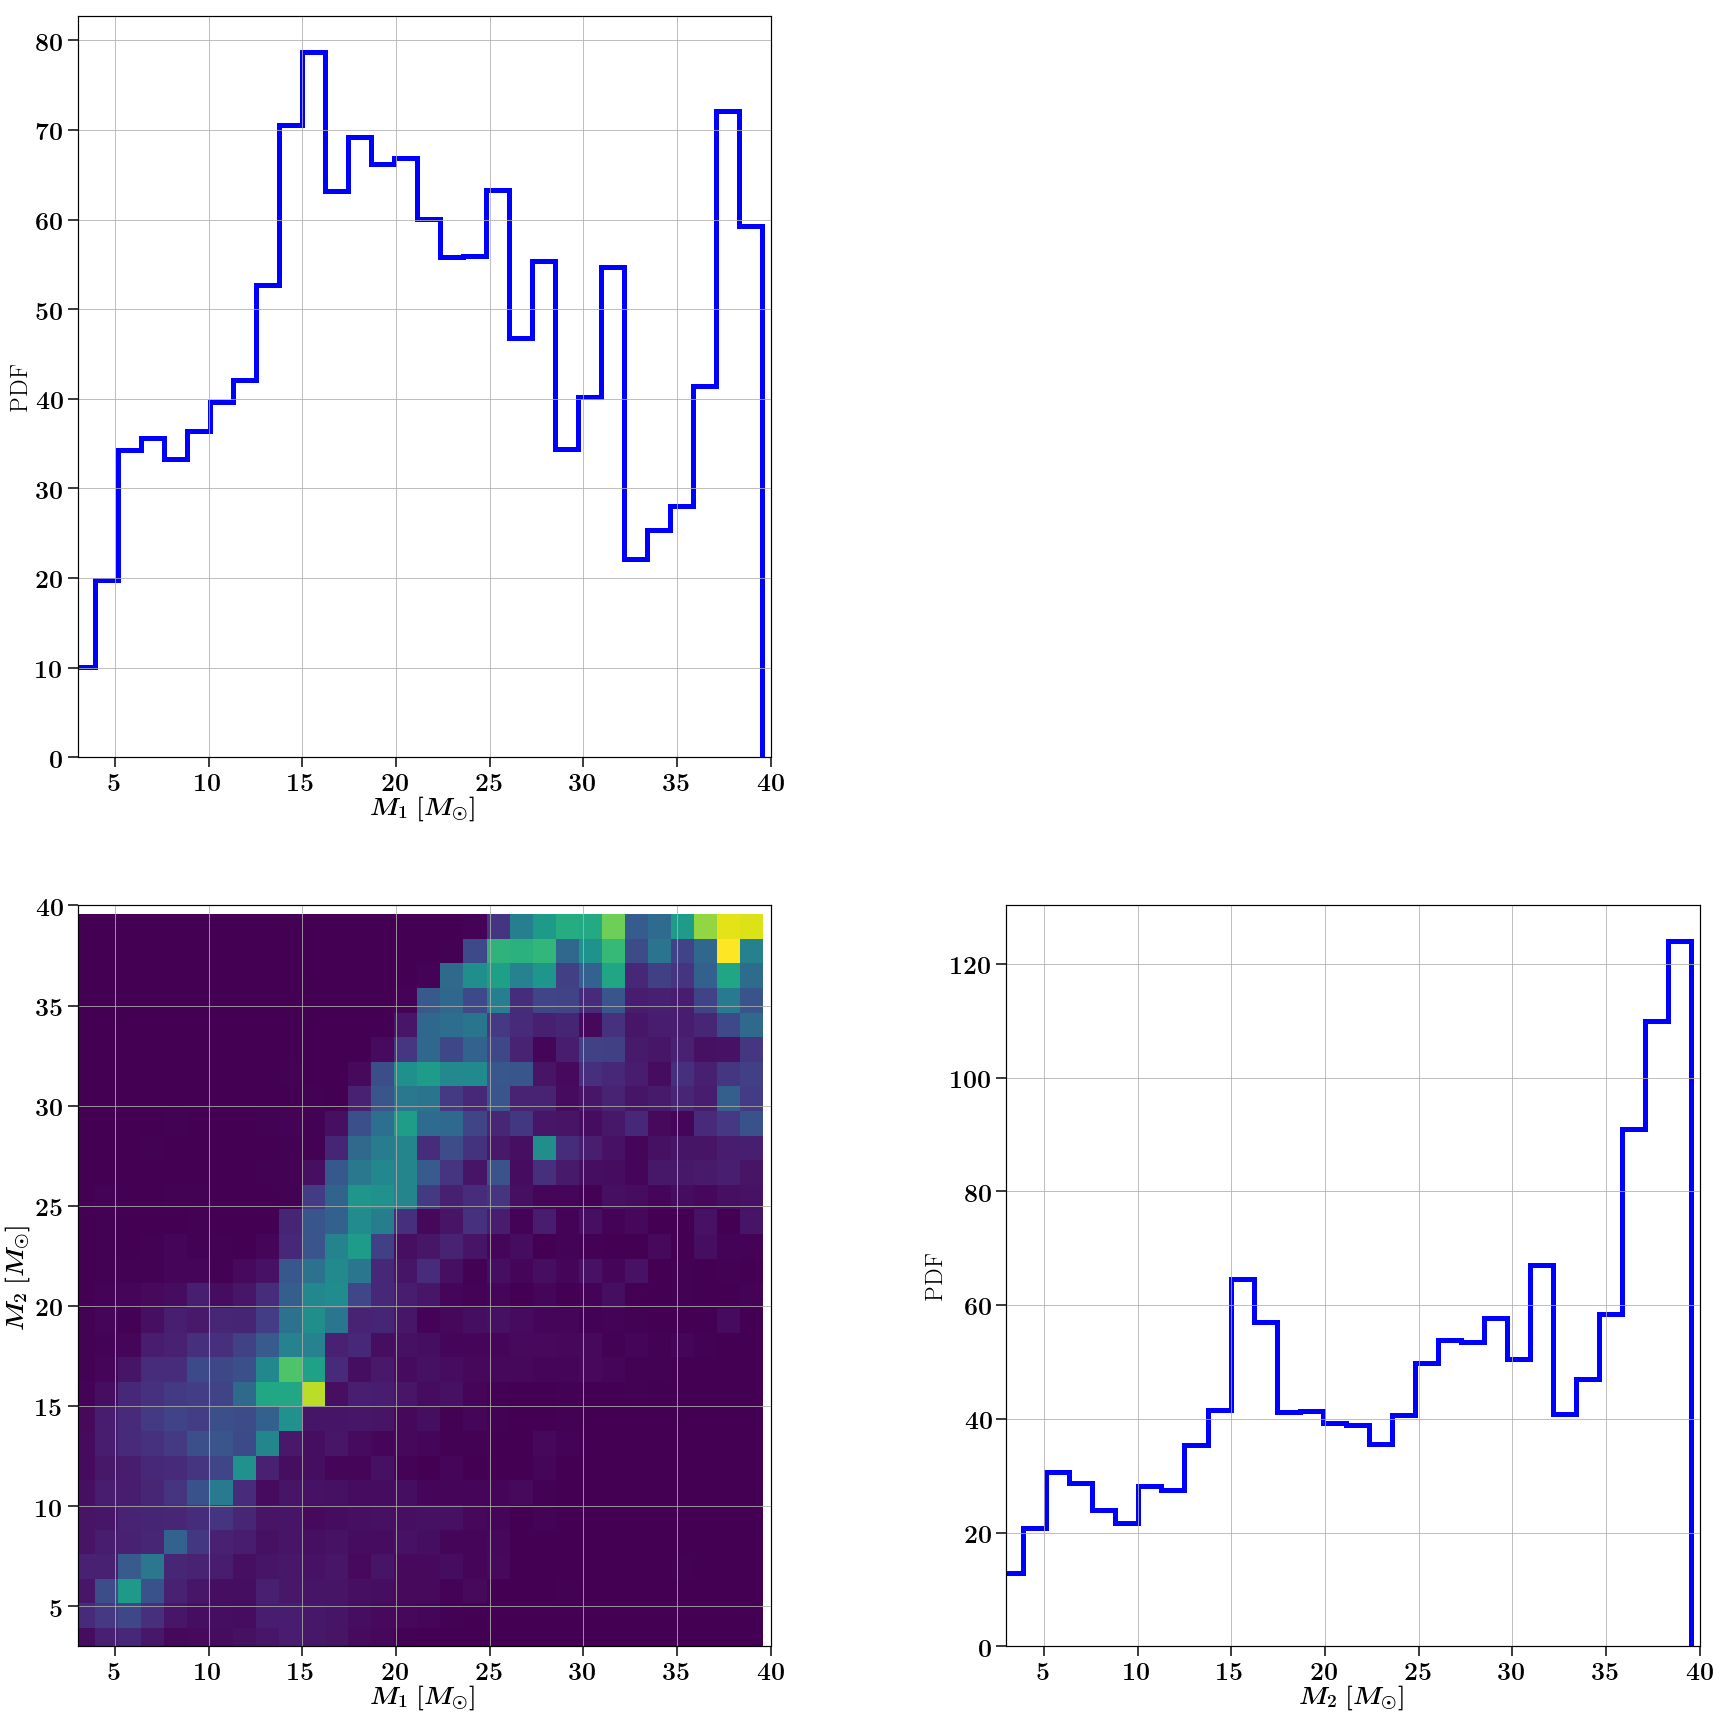

('at model =', 14)
('ii,jj=', 1, 0)


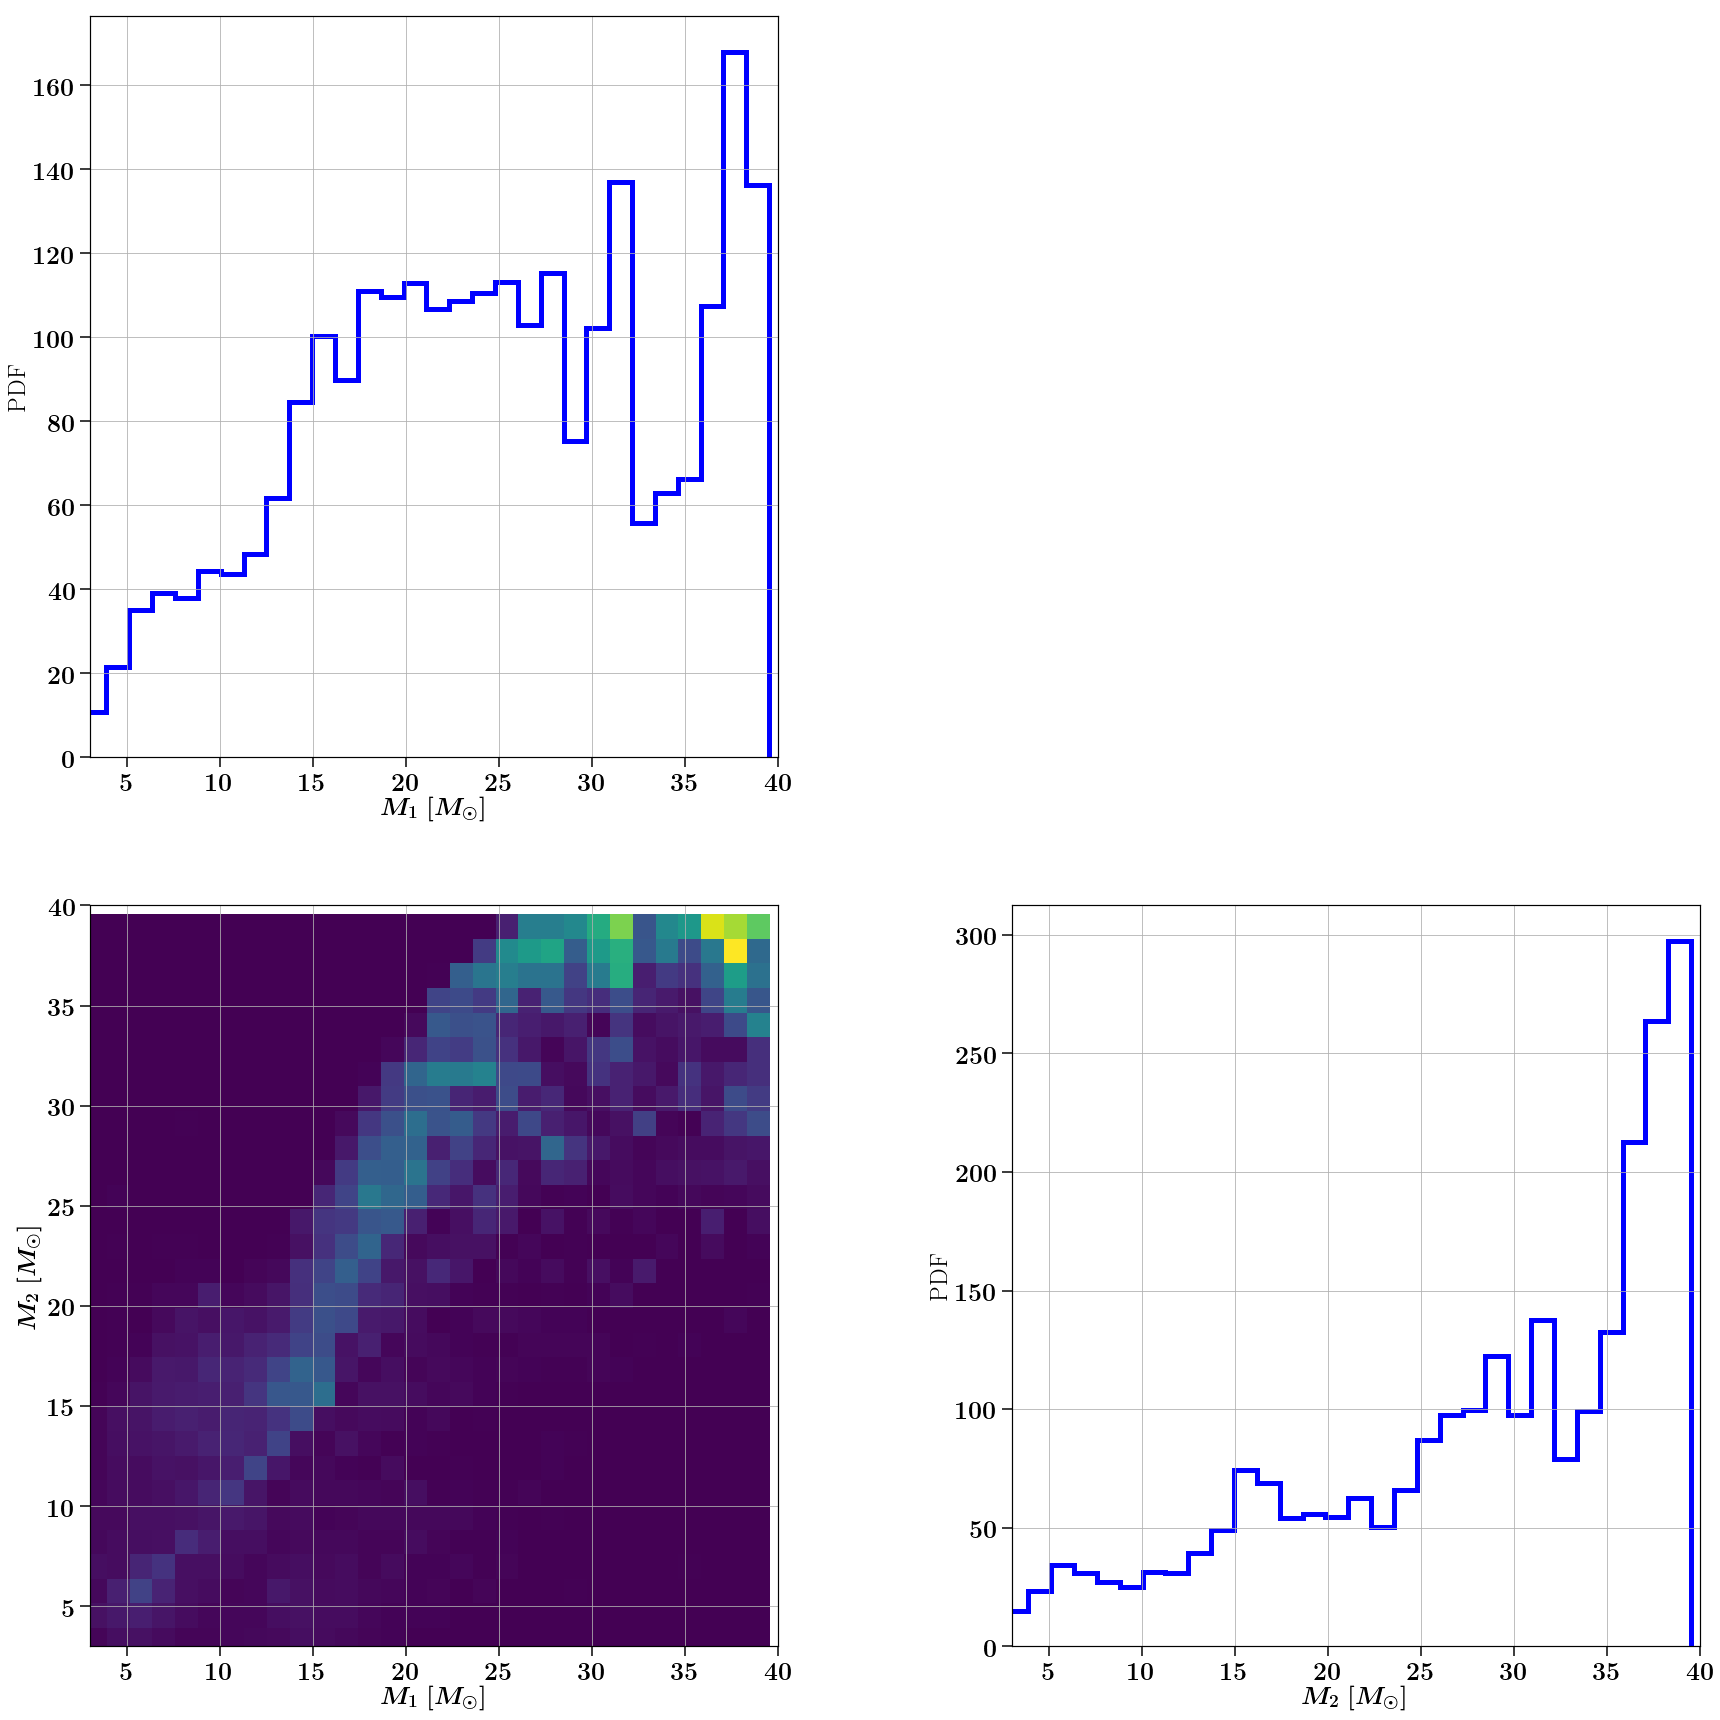

('at model =', 15)
('ii,jj=', 1, 0)


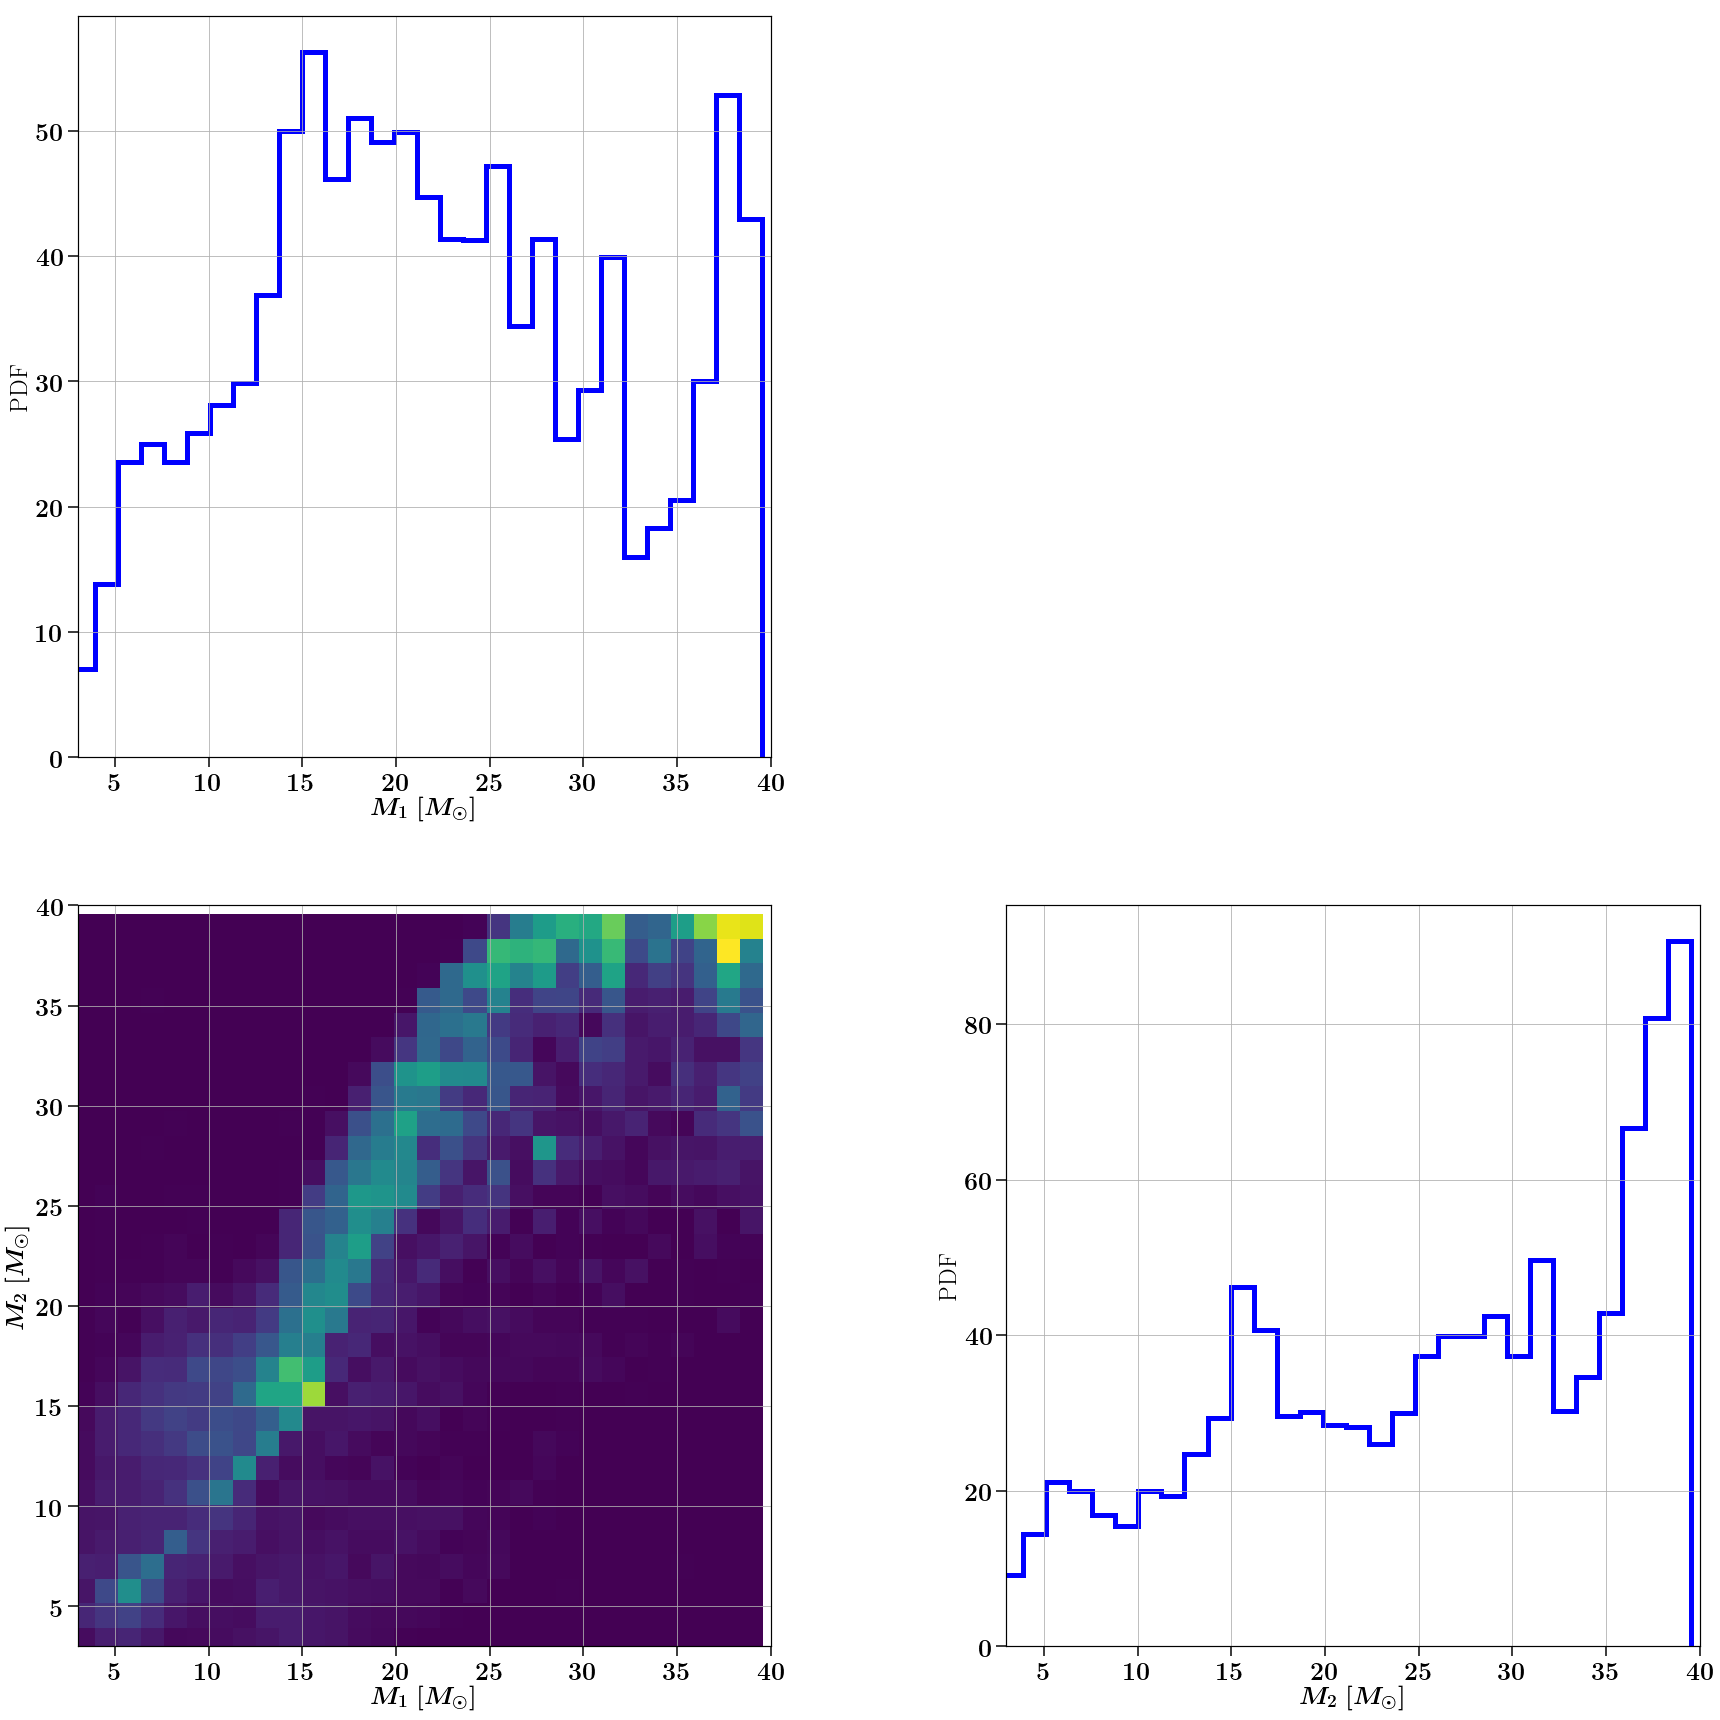

('at model =', 16)
('ii,jj=', 1, 0)


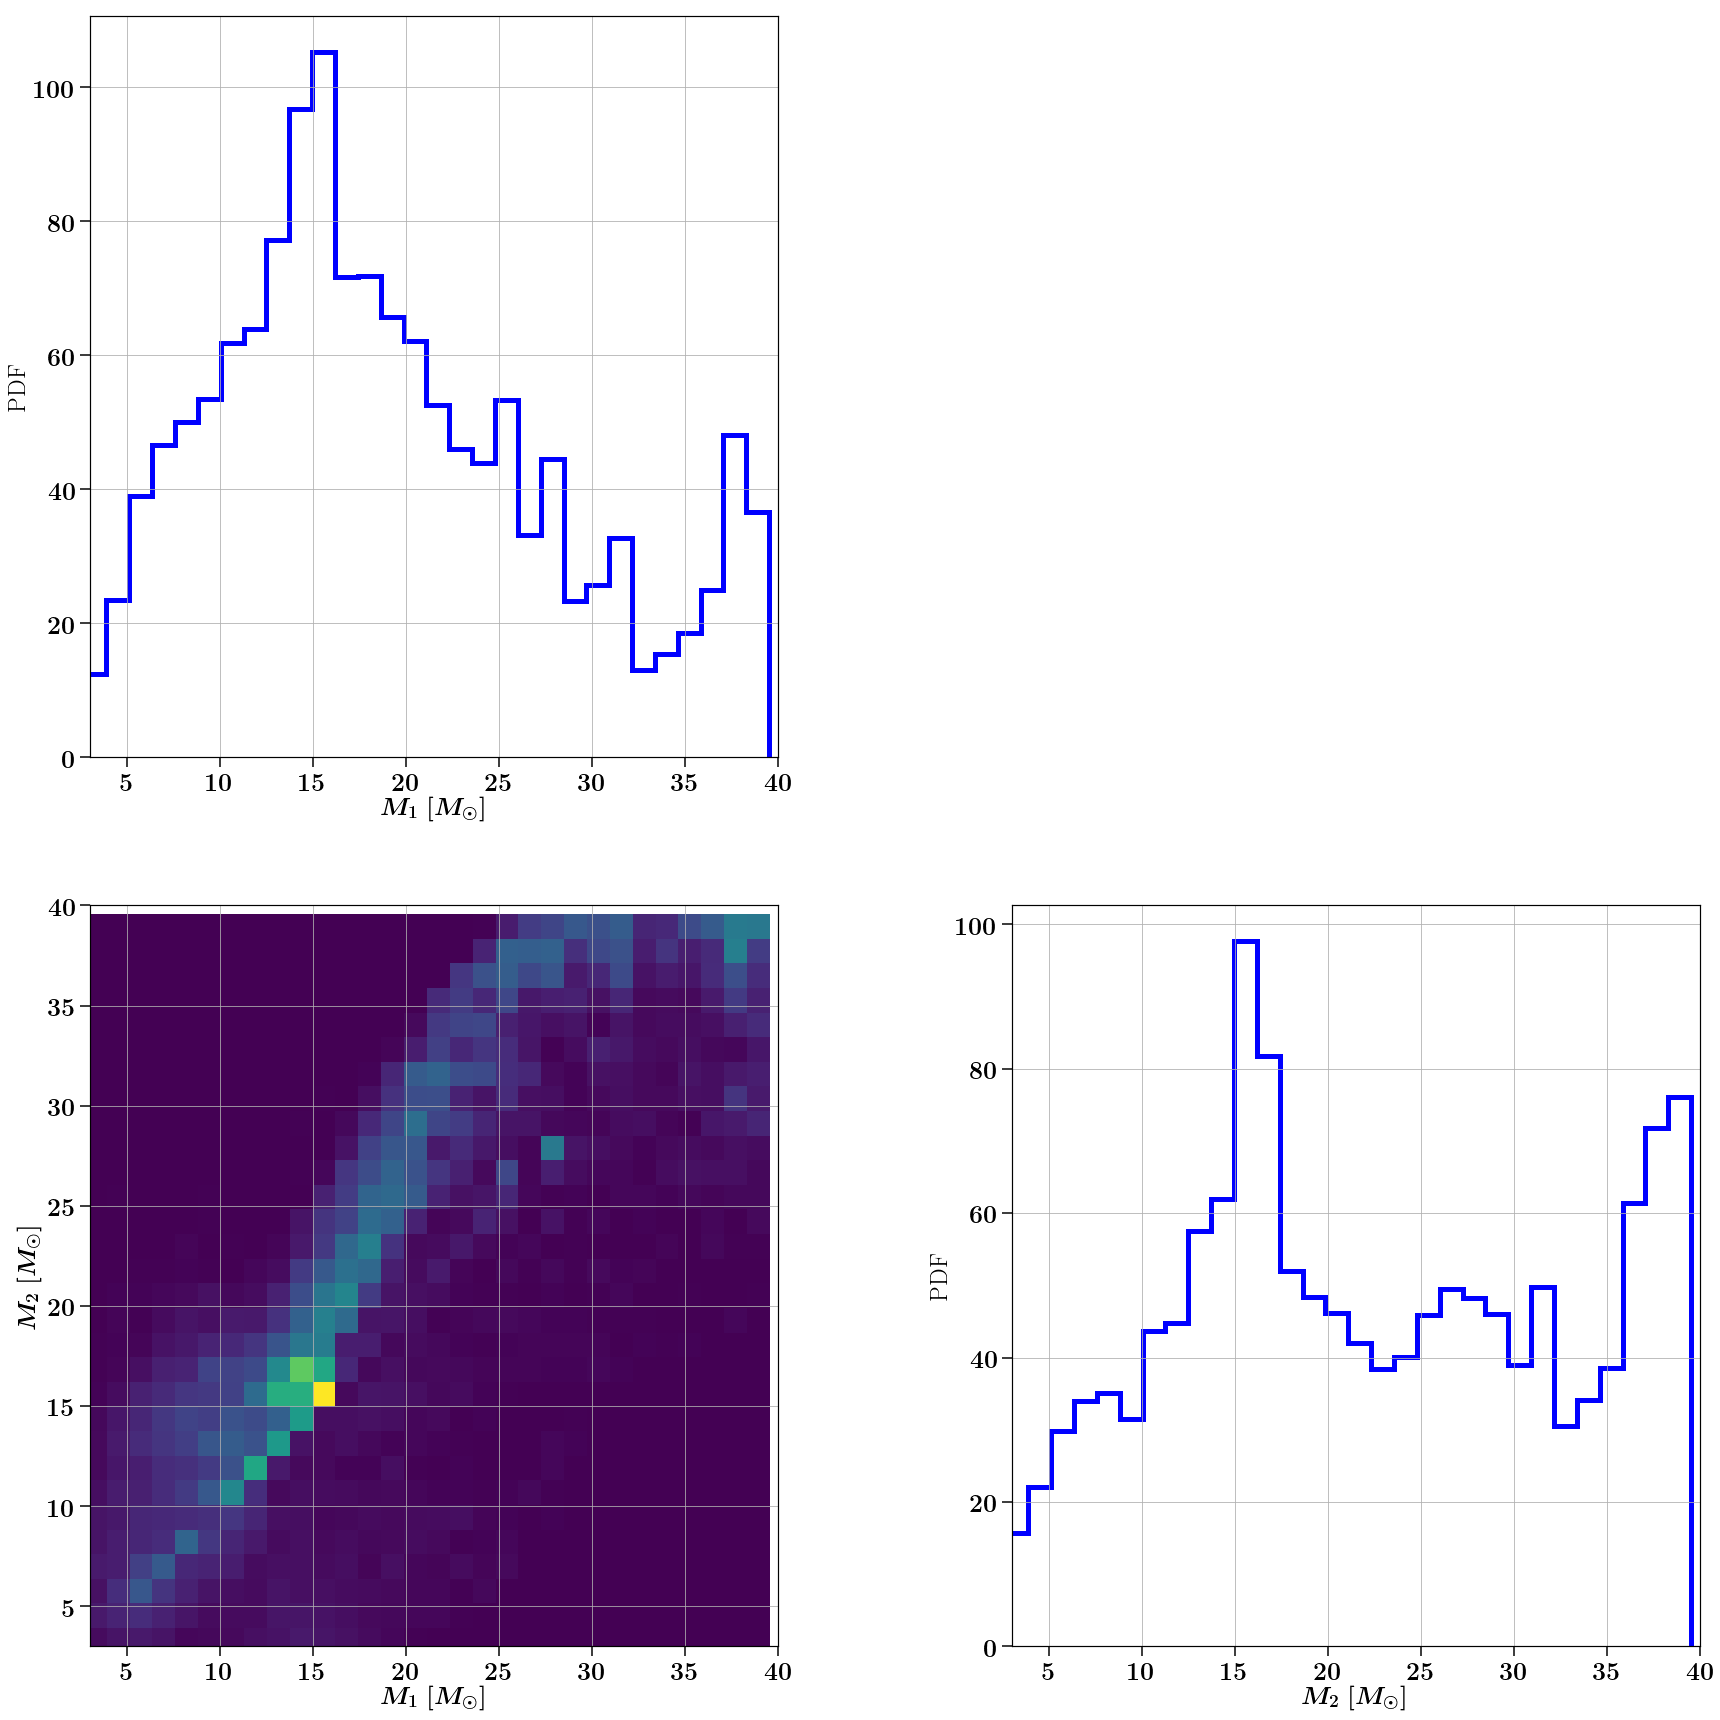

('at model =', 17)
('ii,jj=', 1, 0)


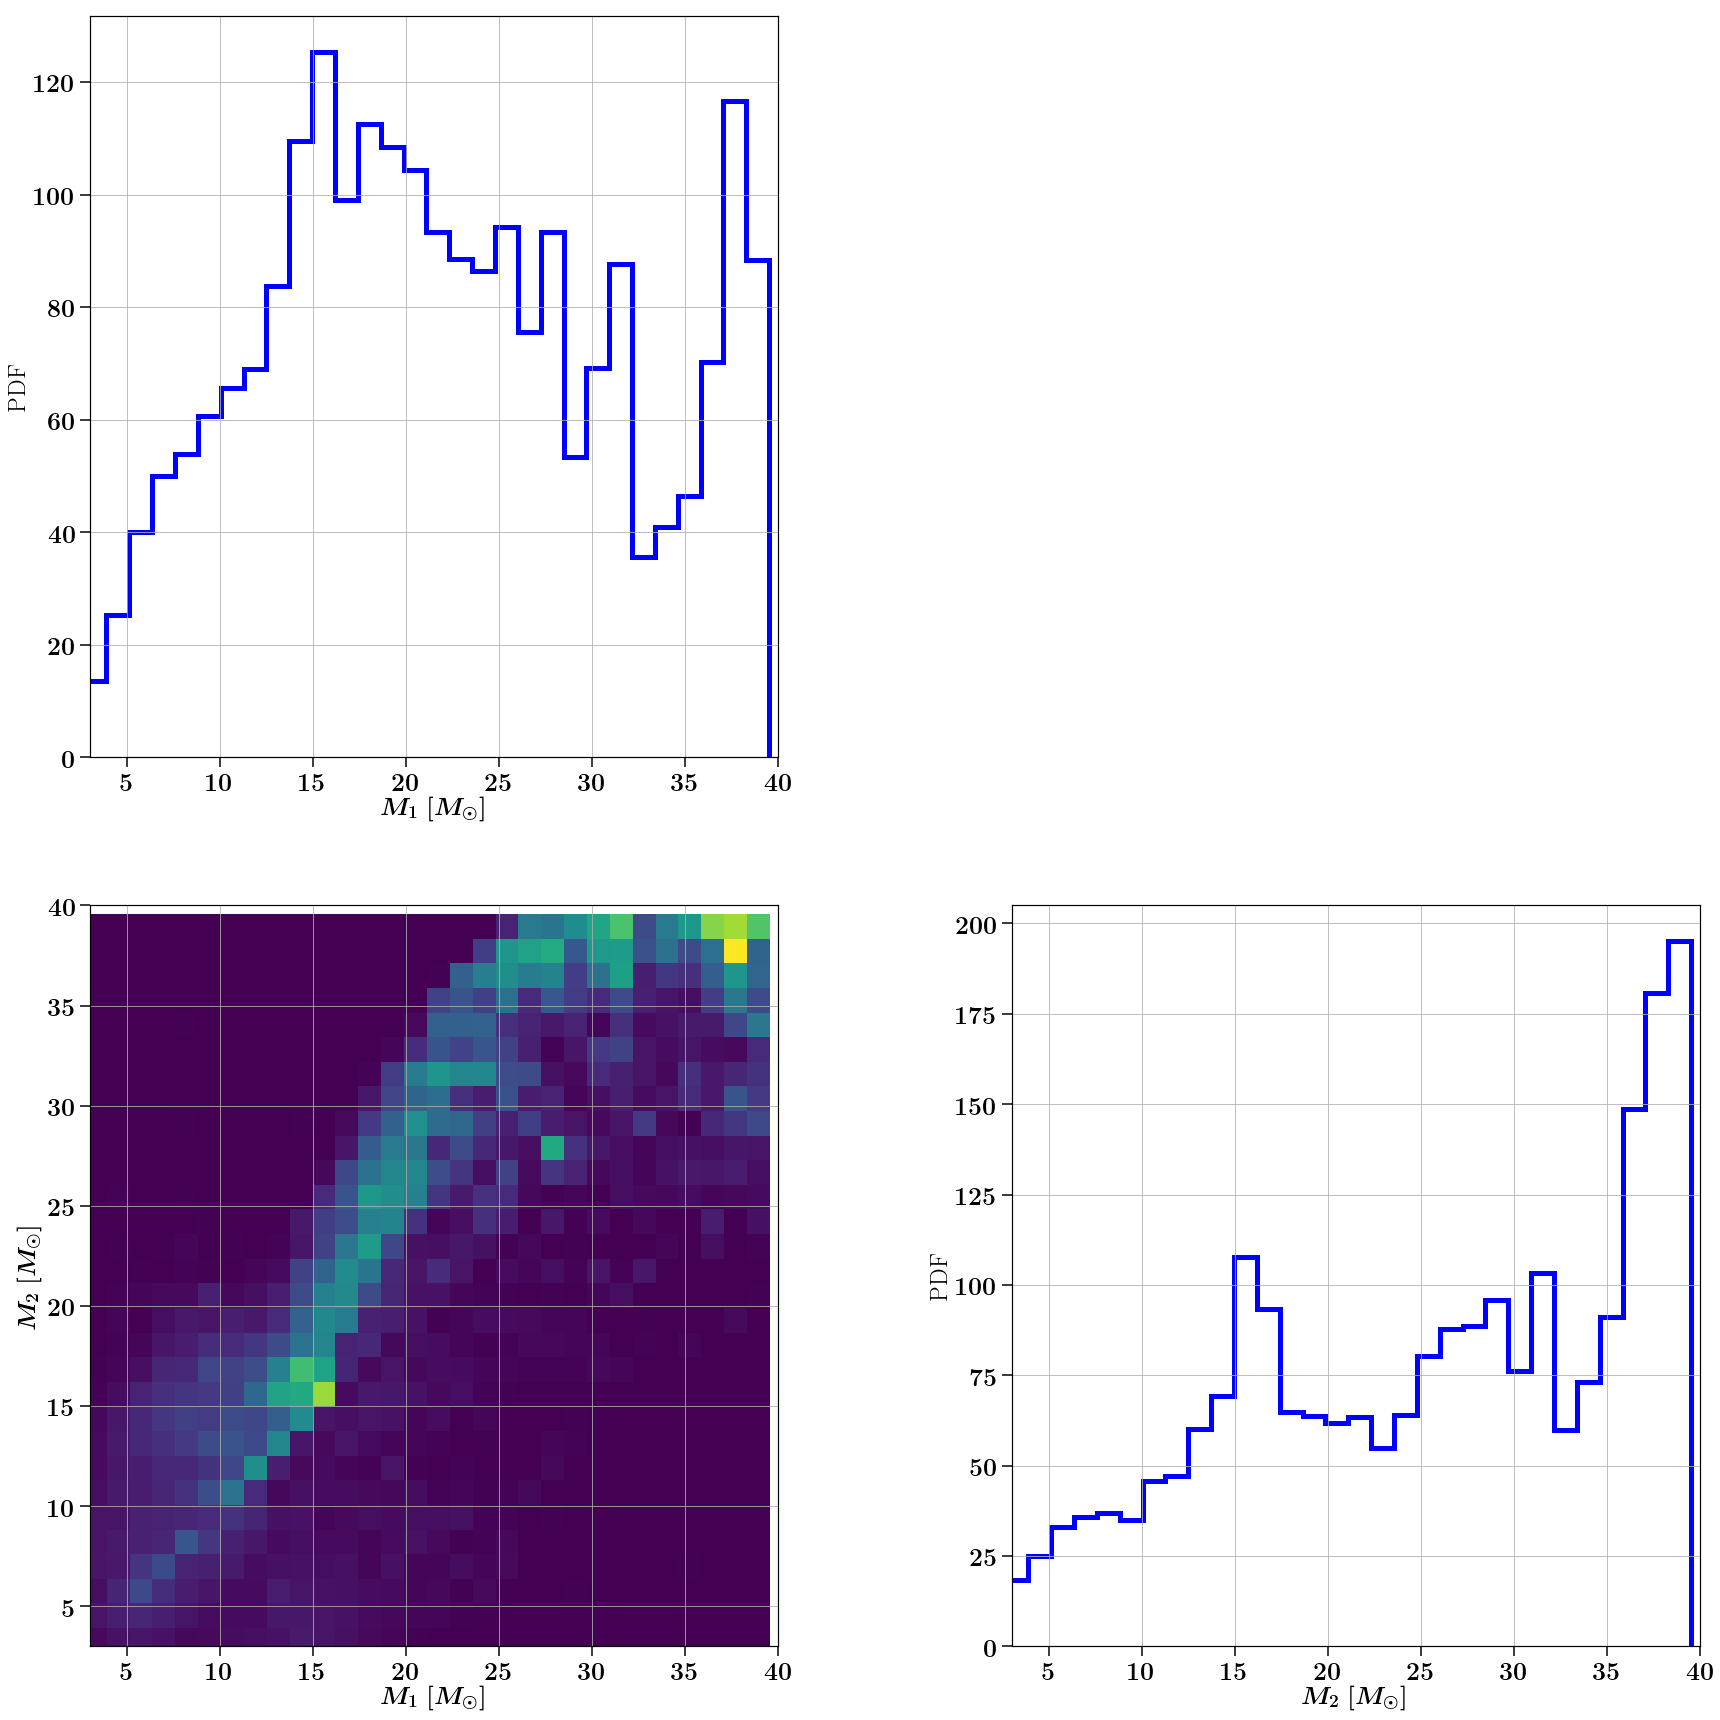

('at model =', 18)
('ii,jj=', 1, 0)


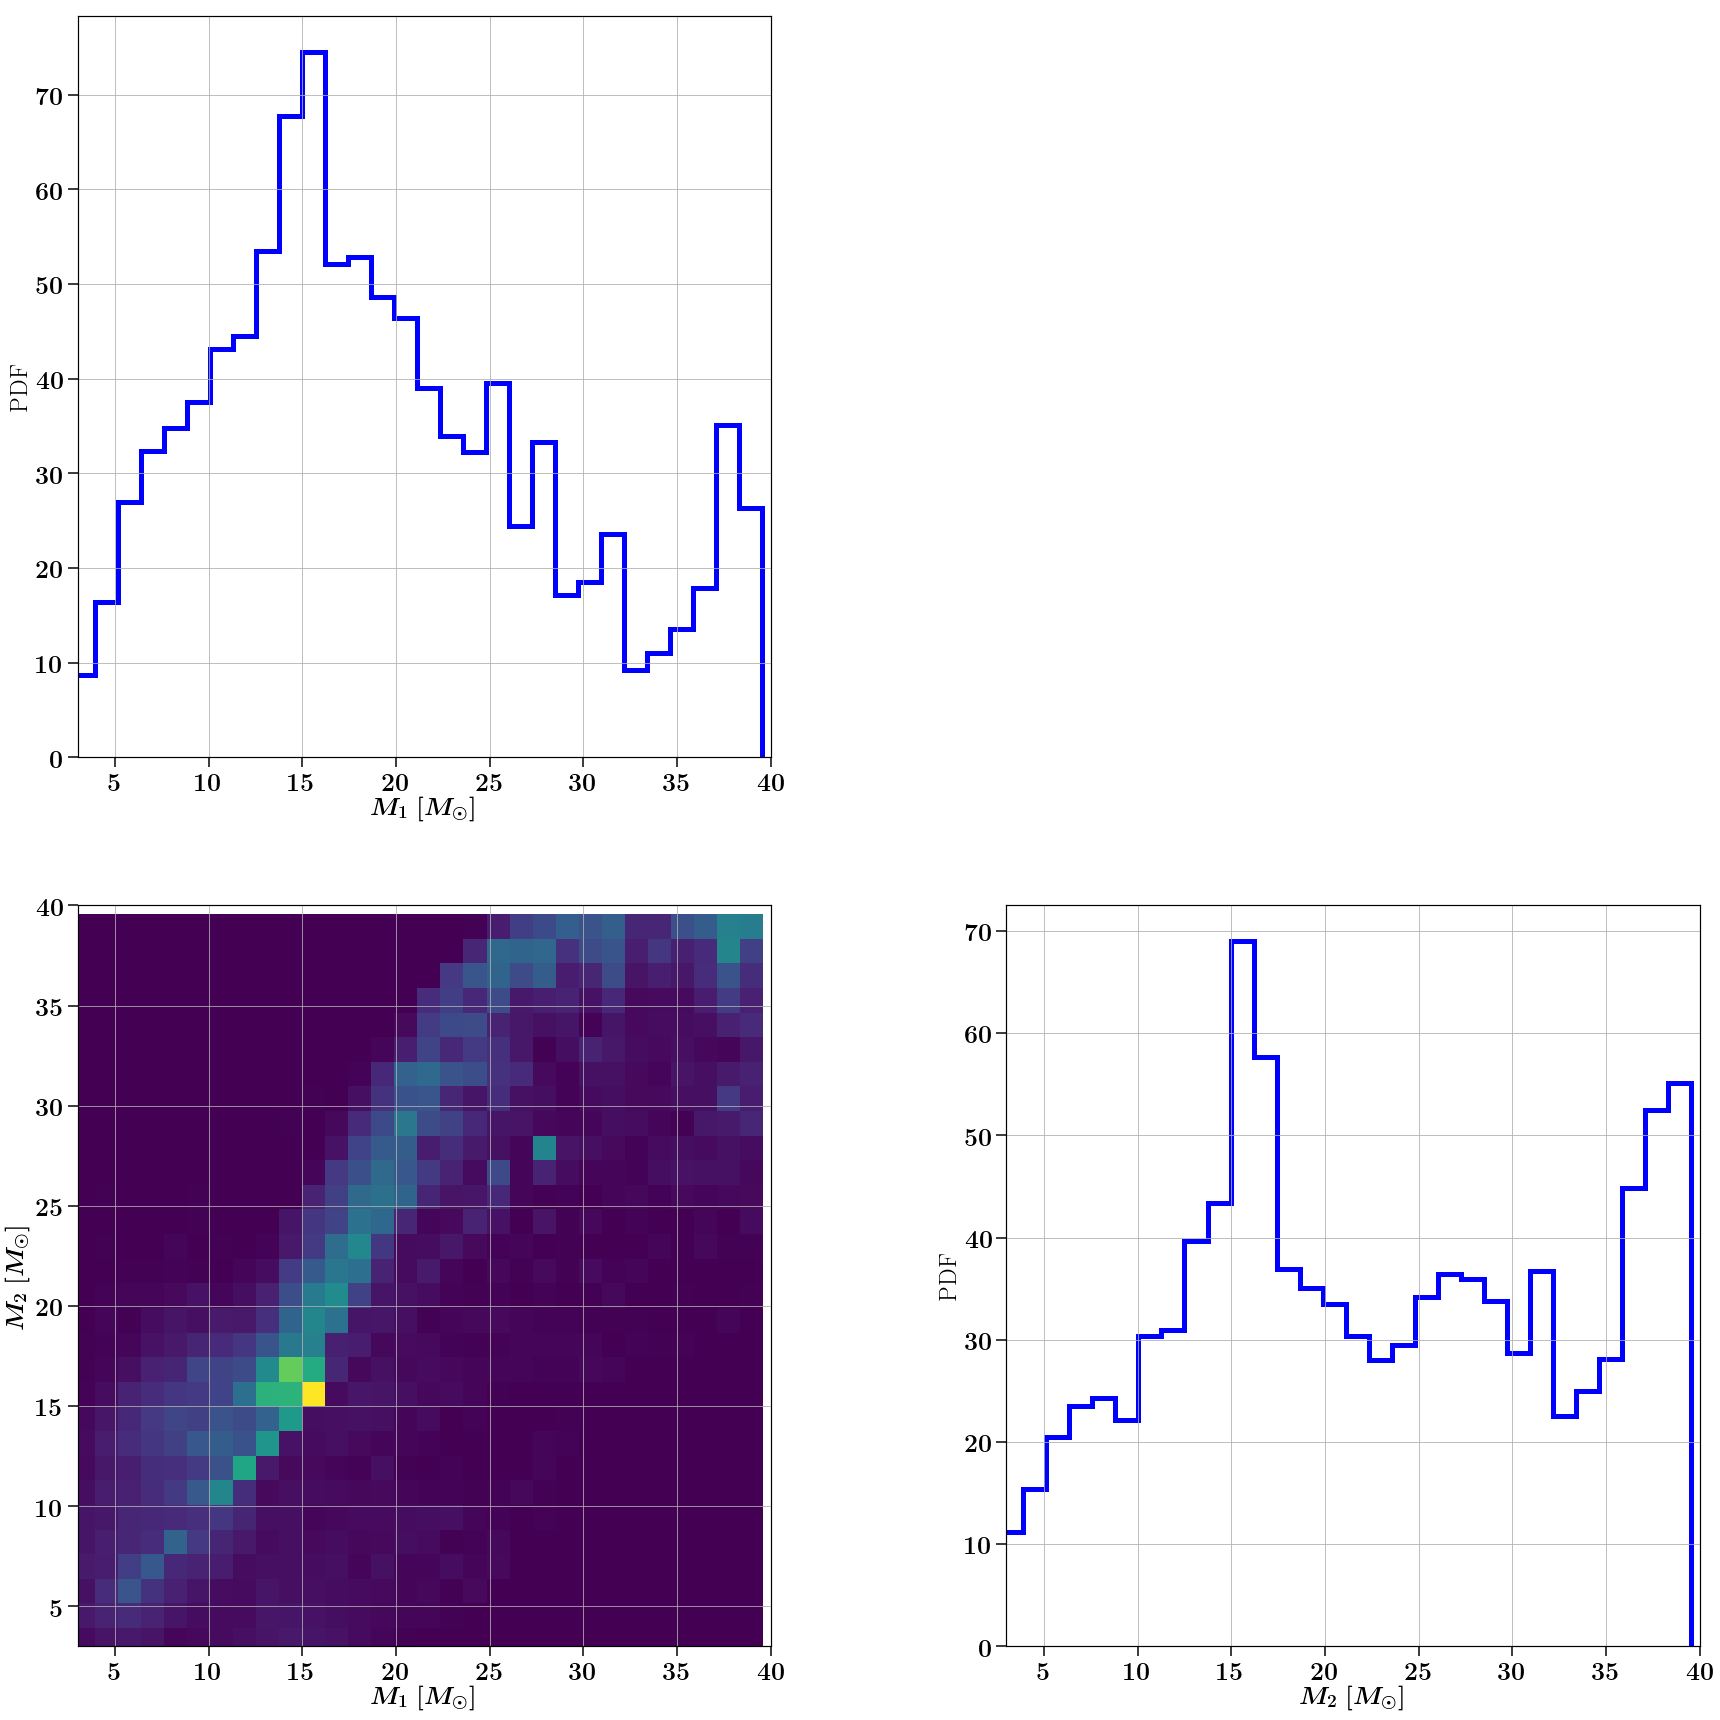

('at model =', 19)
('ii,jj=', 1, 0)


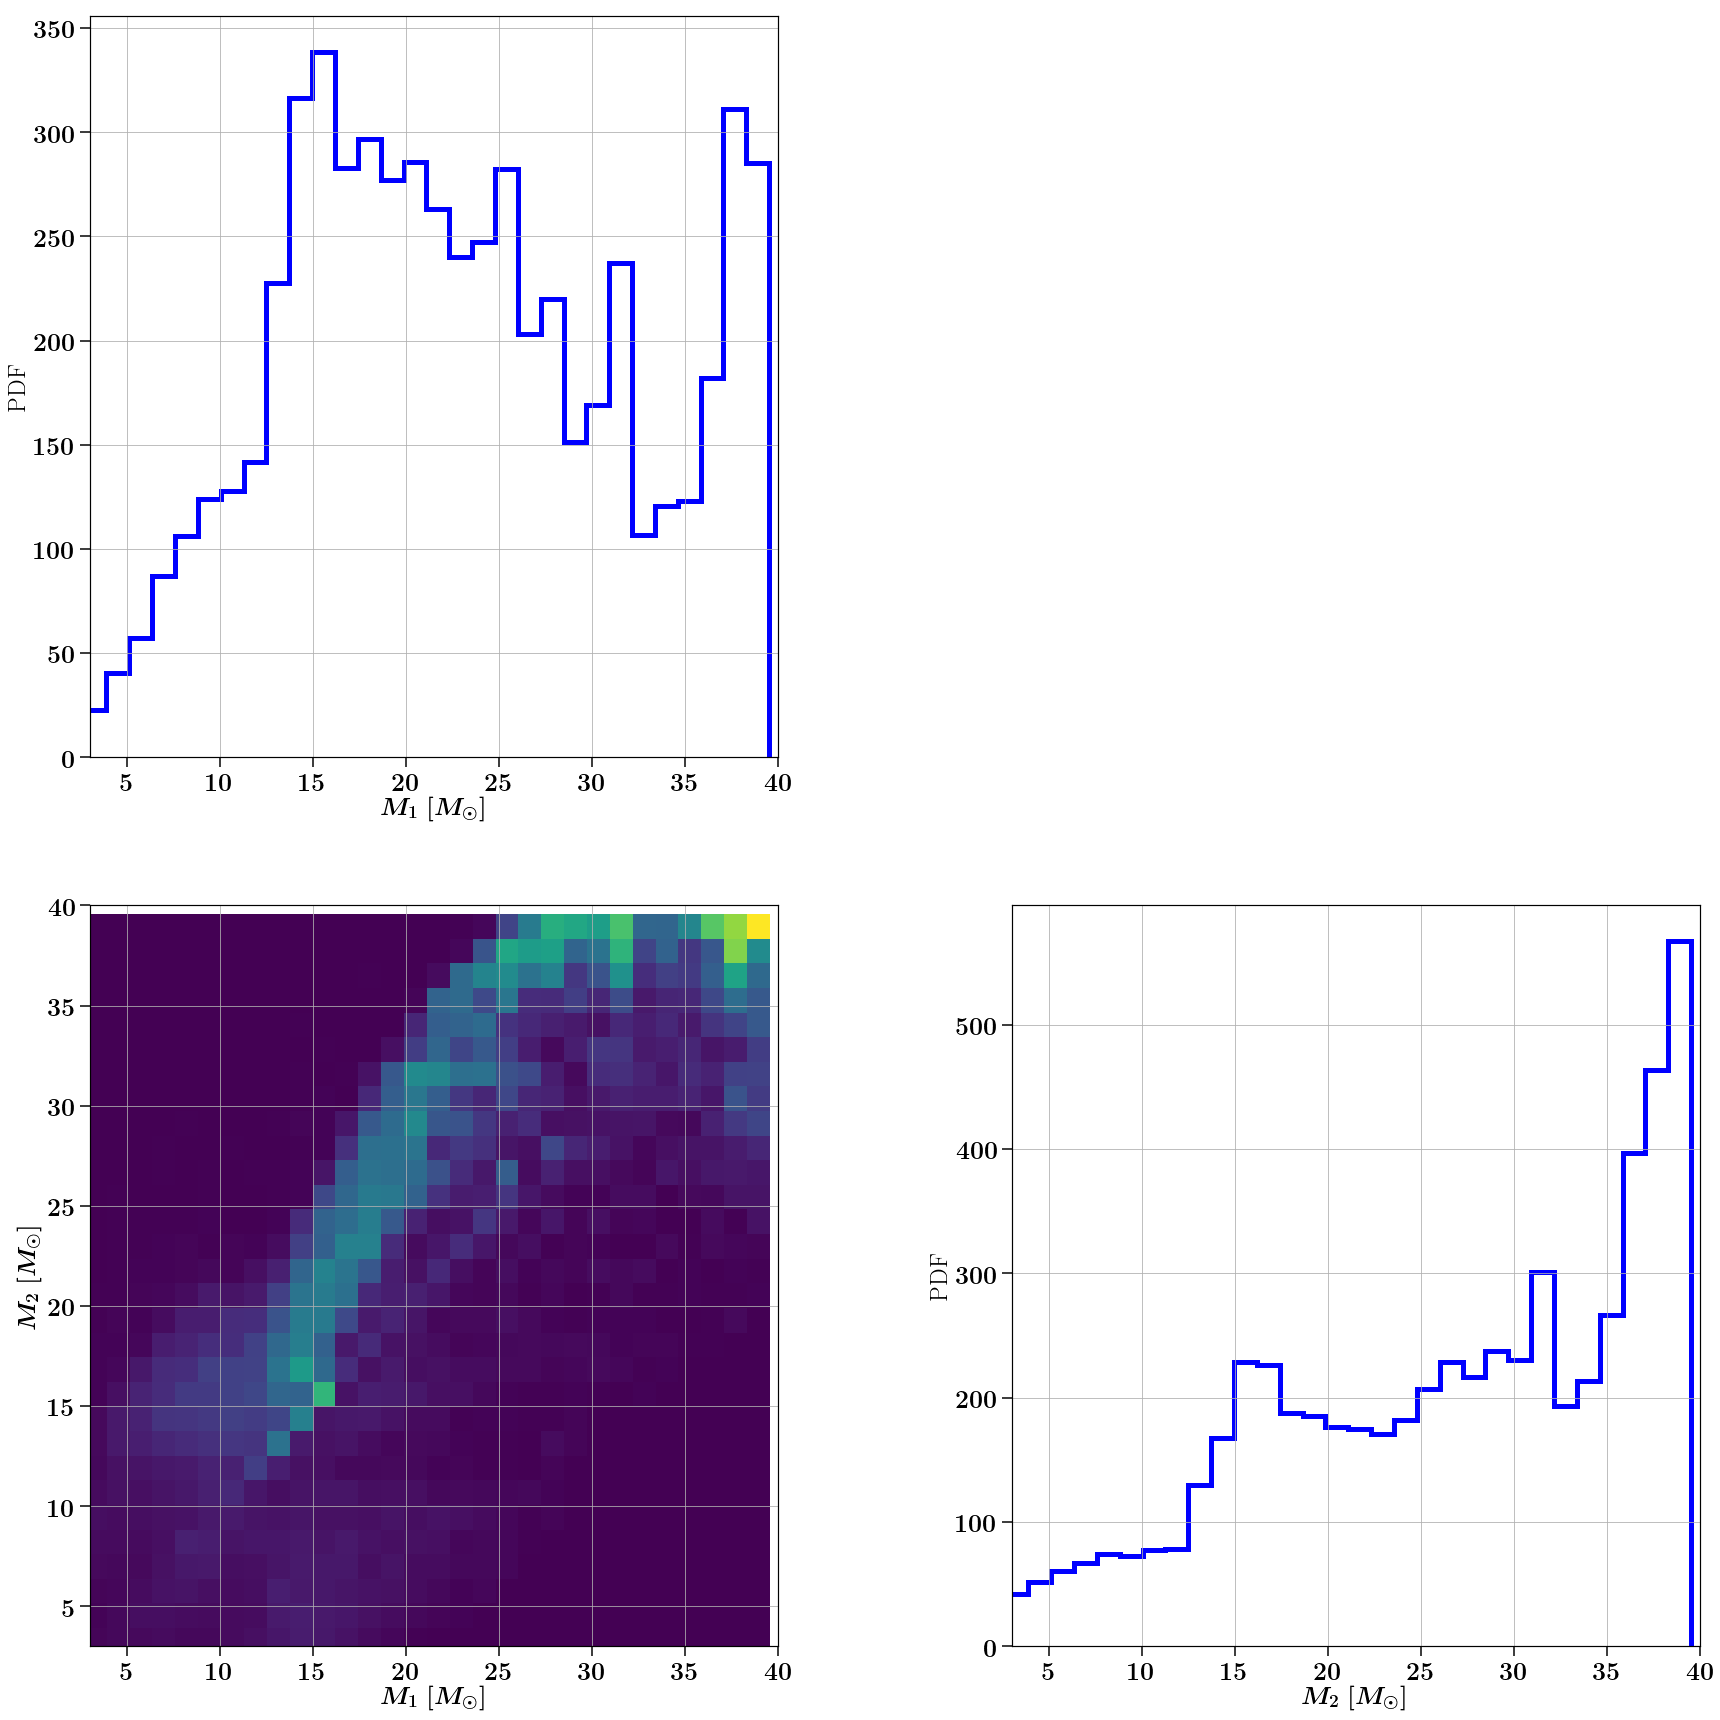

('at model =', 20)
('ii,jj=', 1, 0)


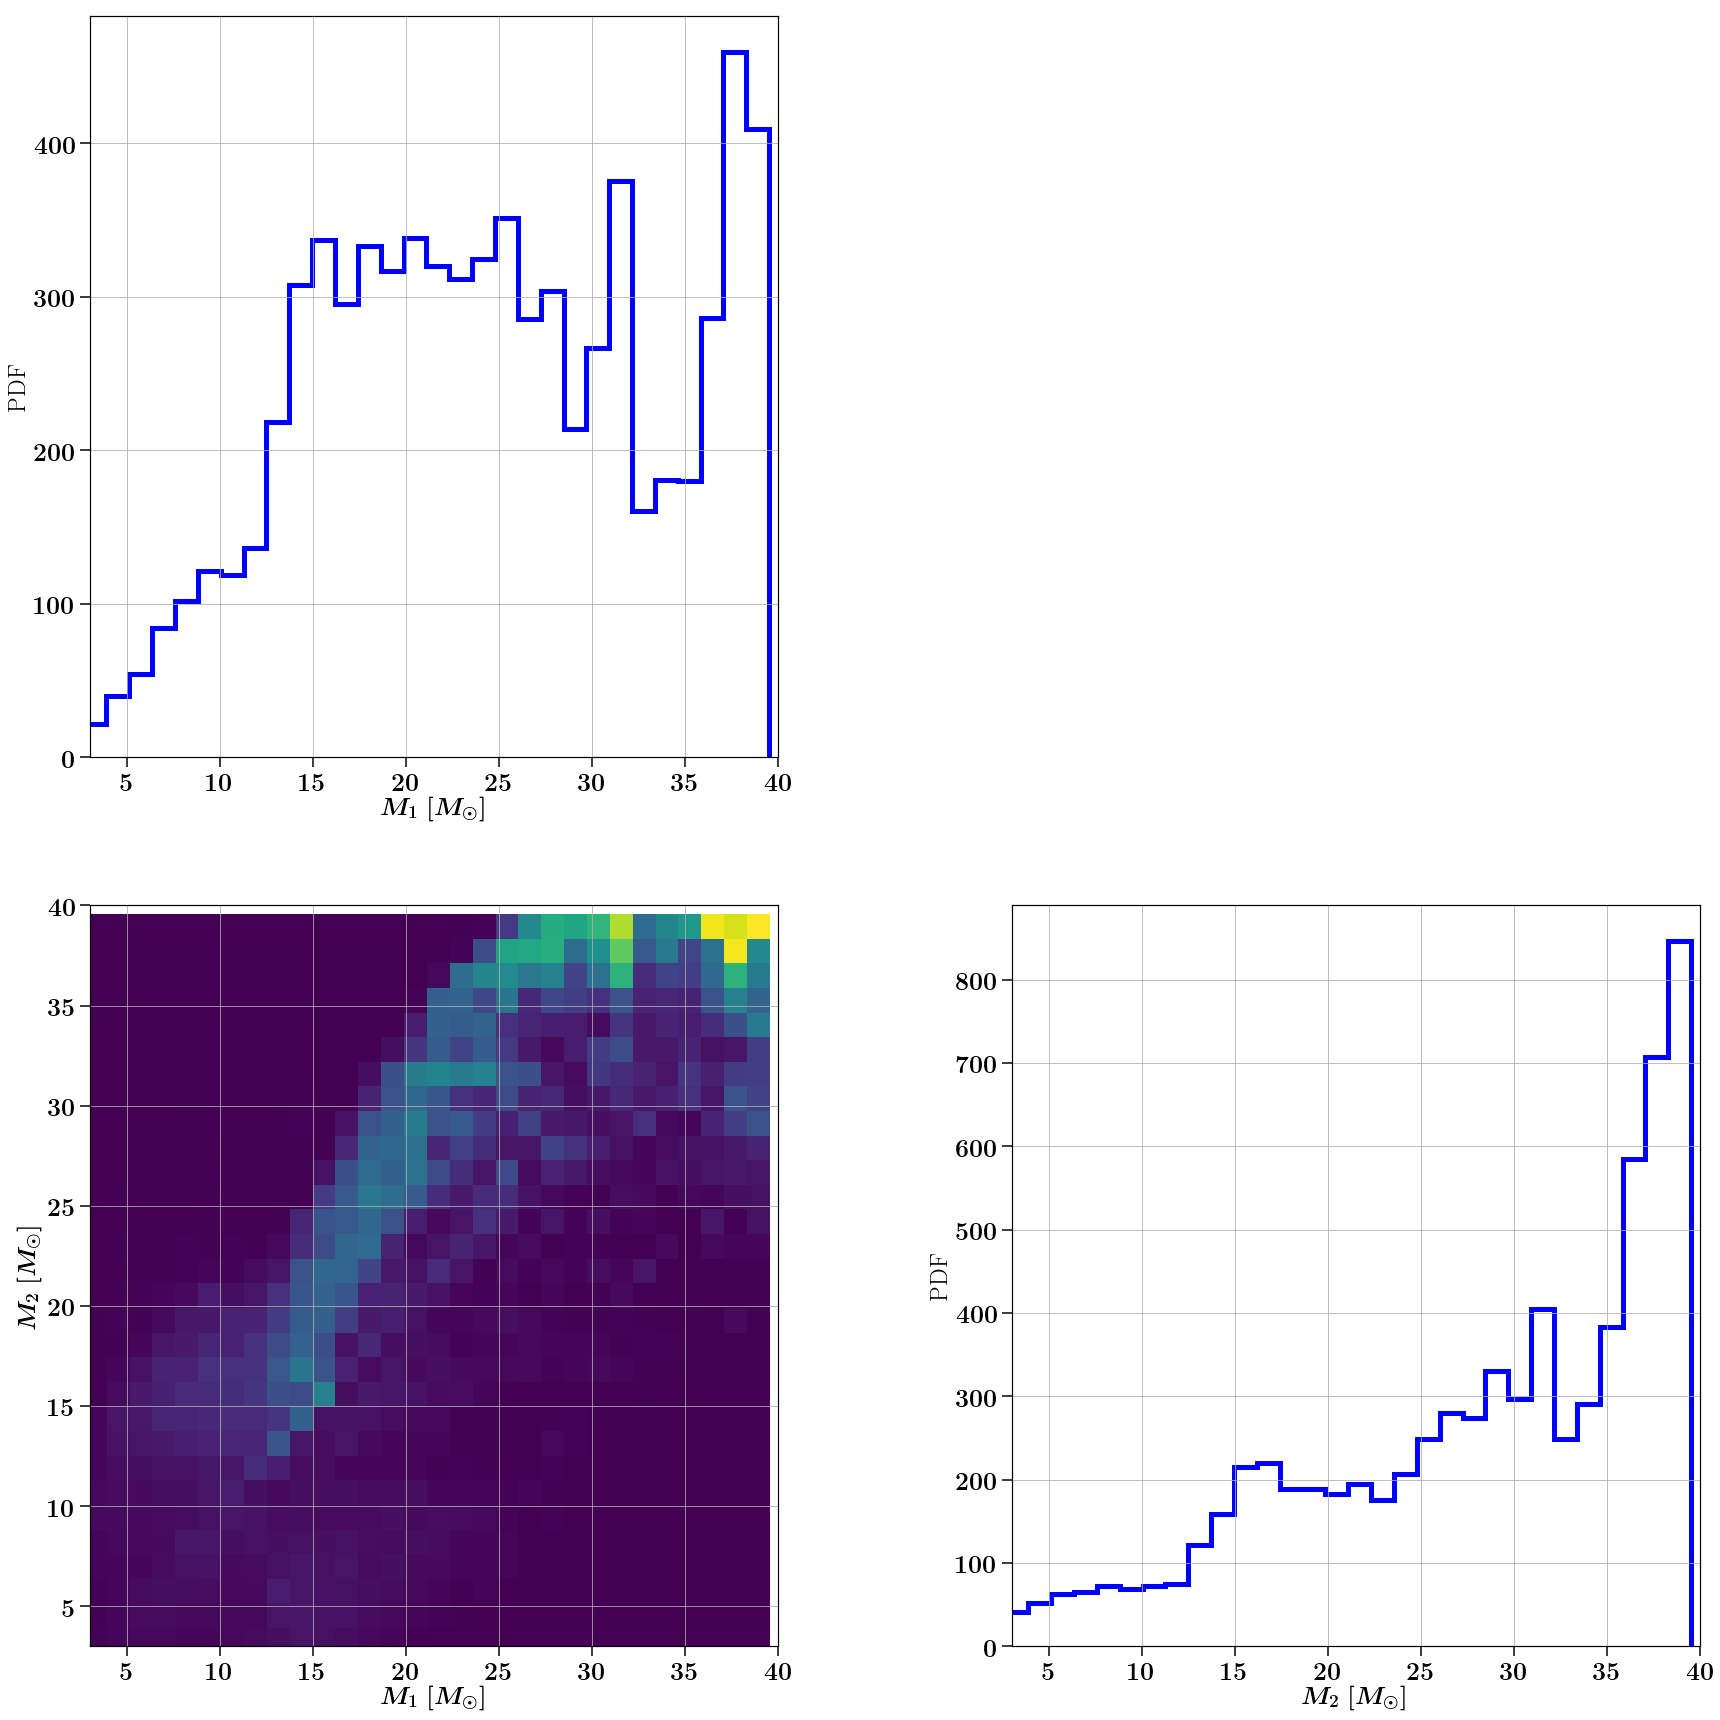

('at model =', 21)
('ii,jj=', 1, 0)


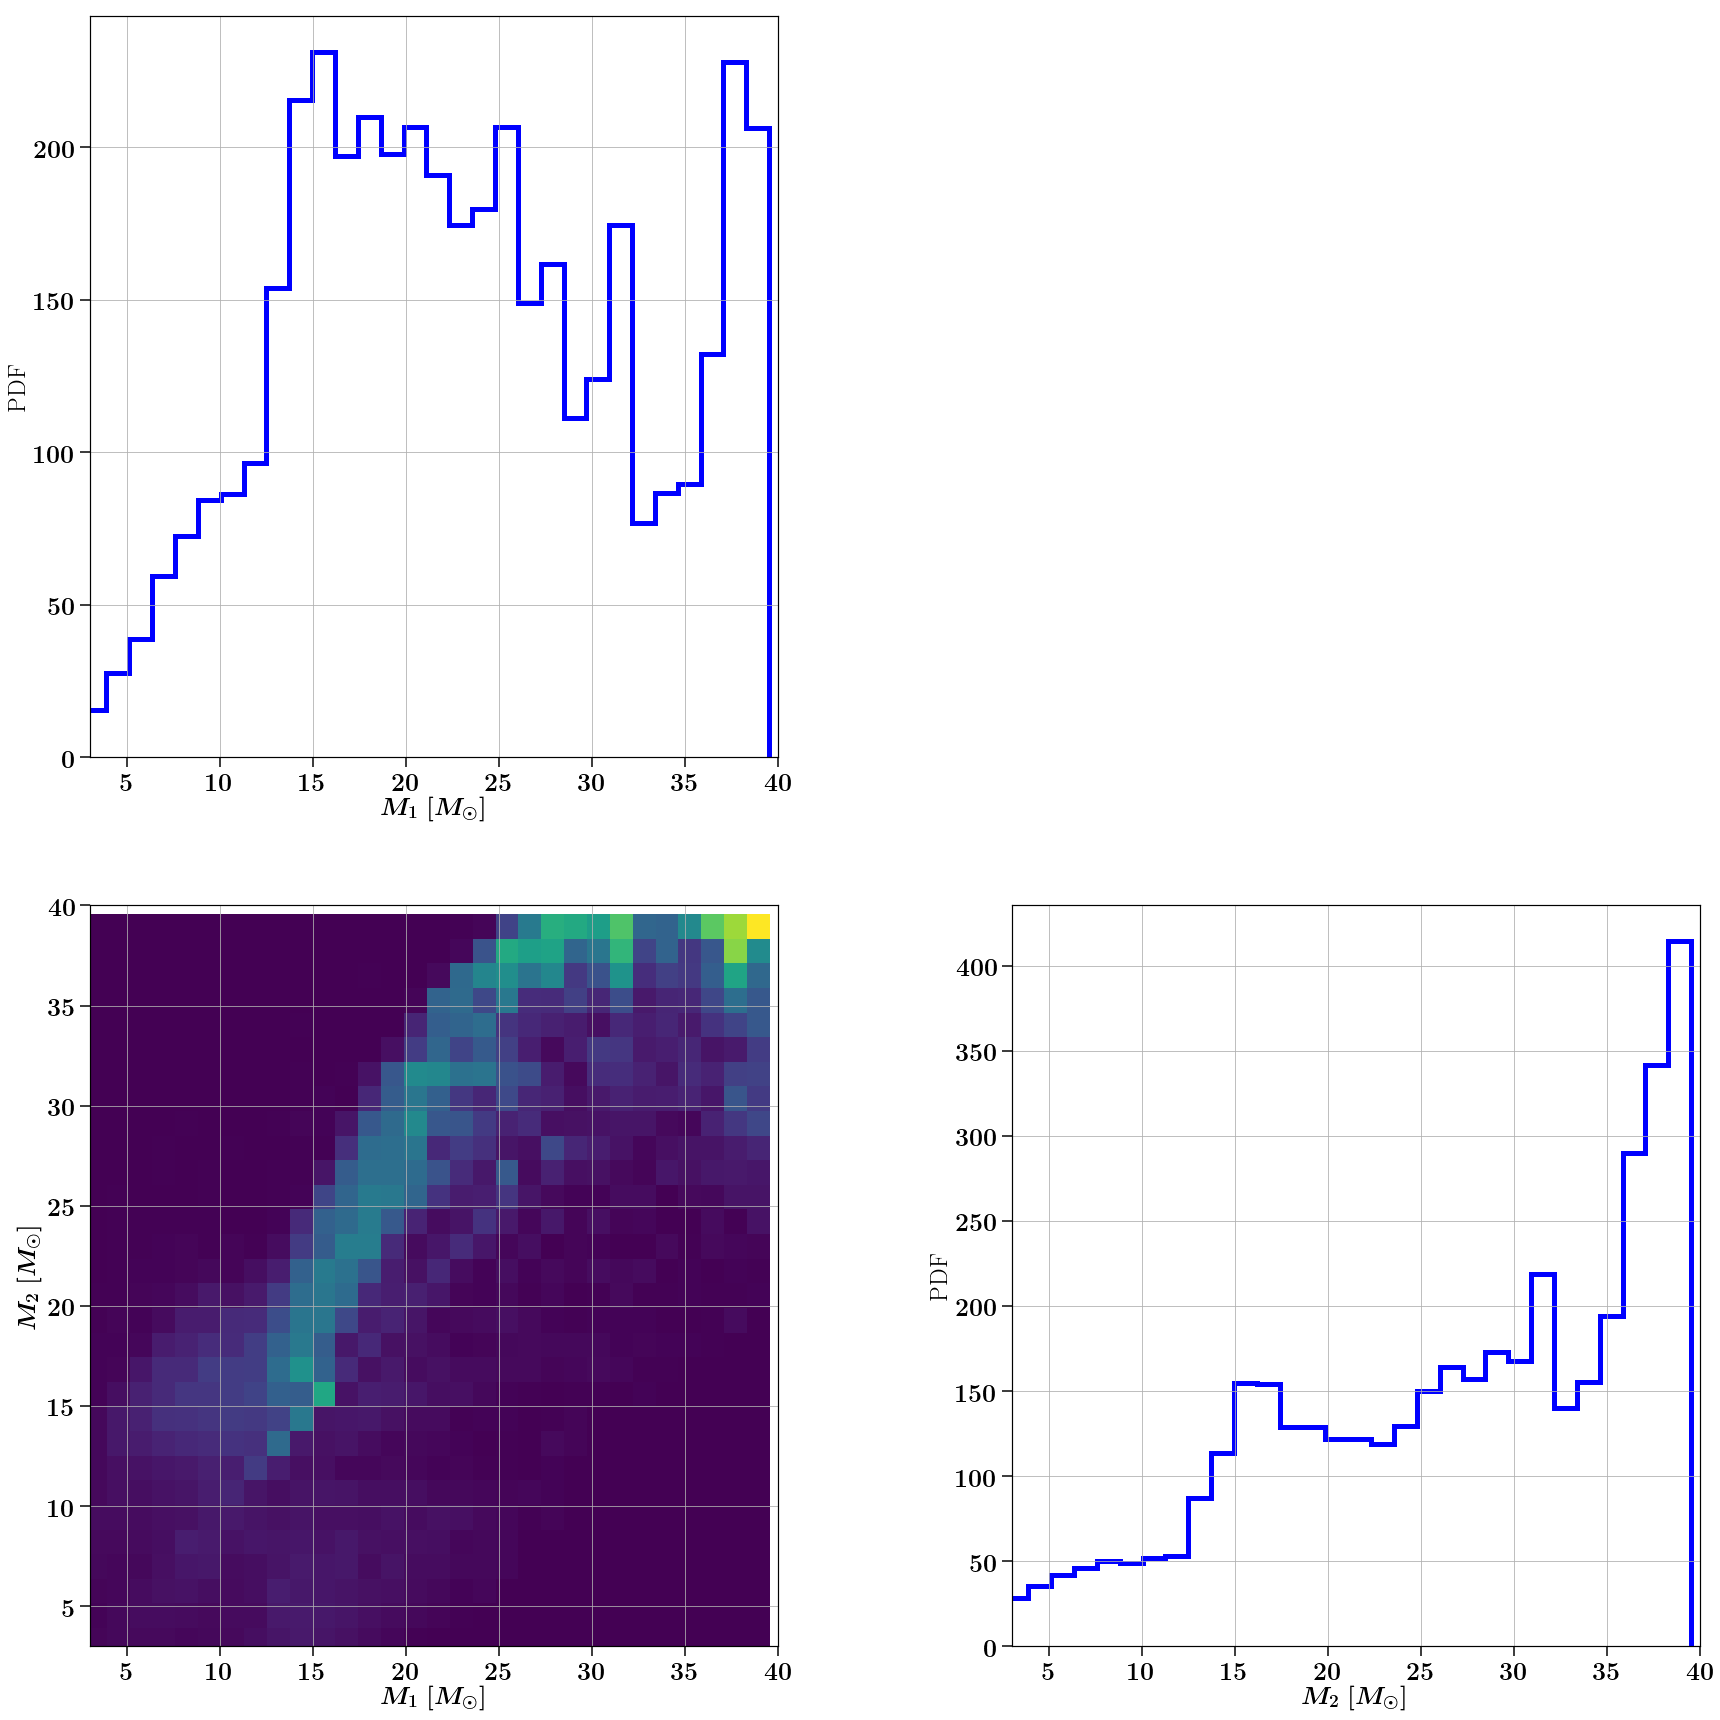

('at model =', 22)
('ii,jj=', 1, 0)


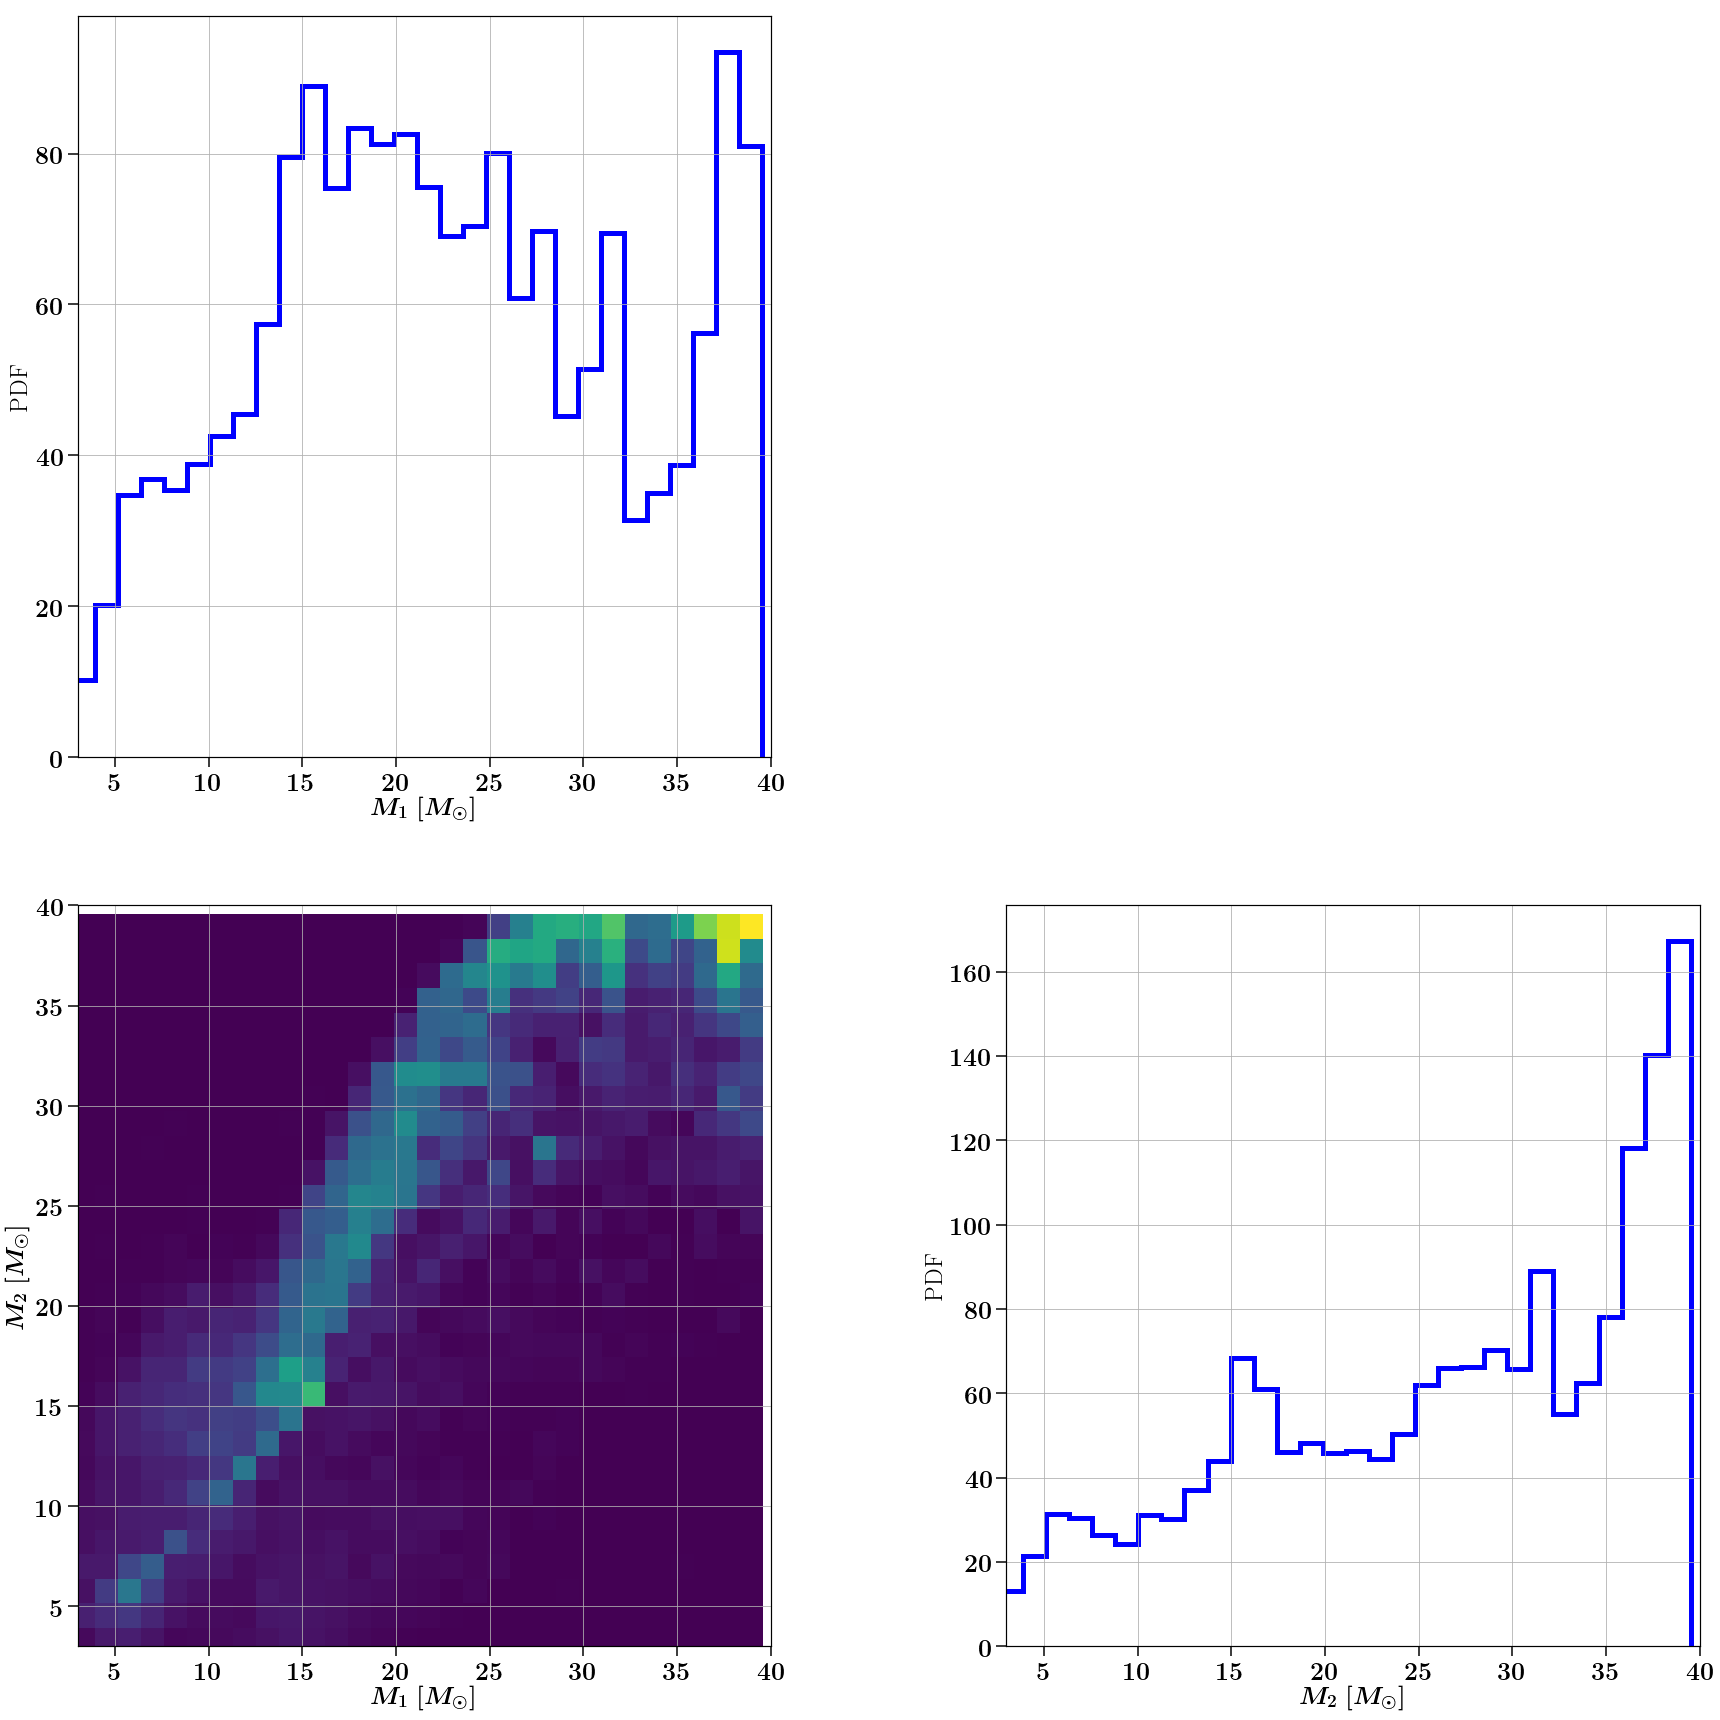

('at model =', 23)
('ii,jj=', 1, 0)


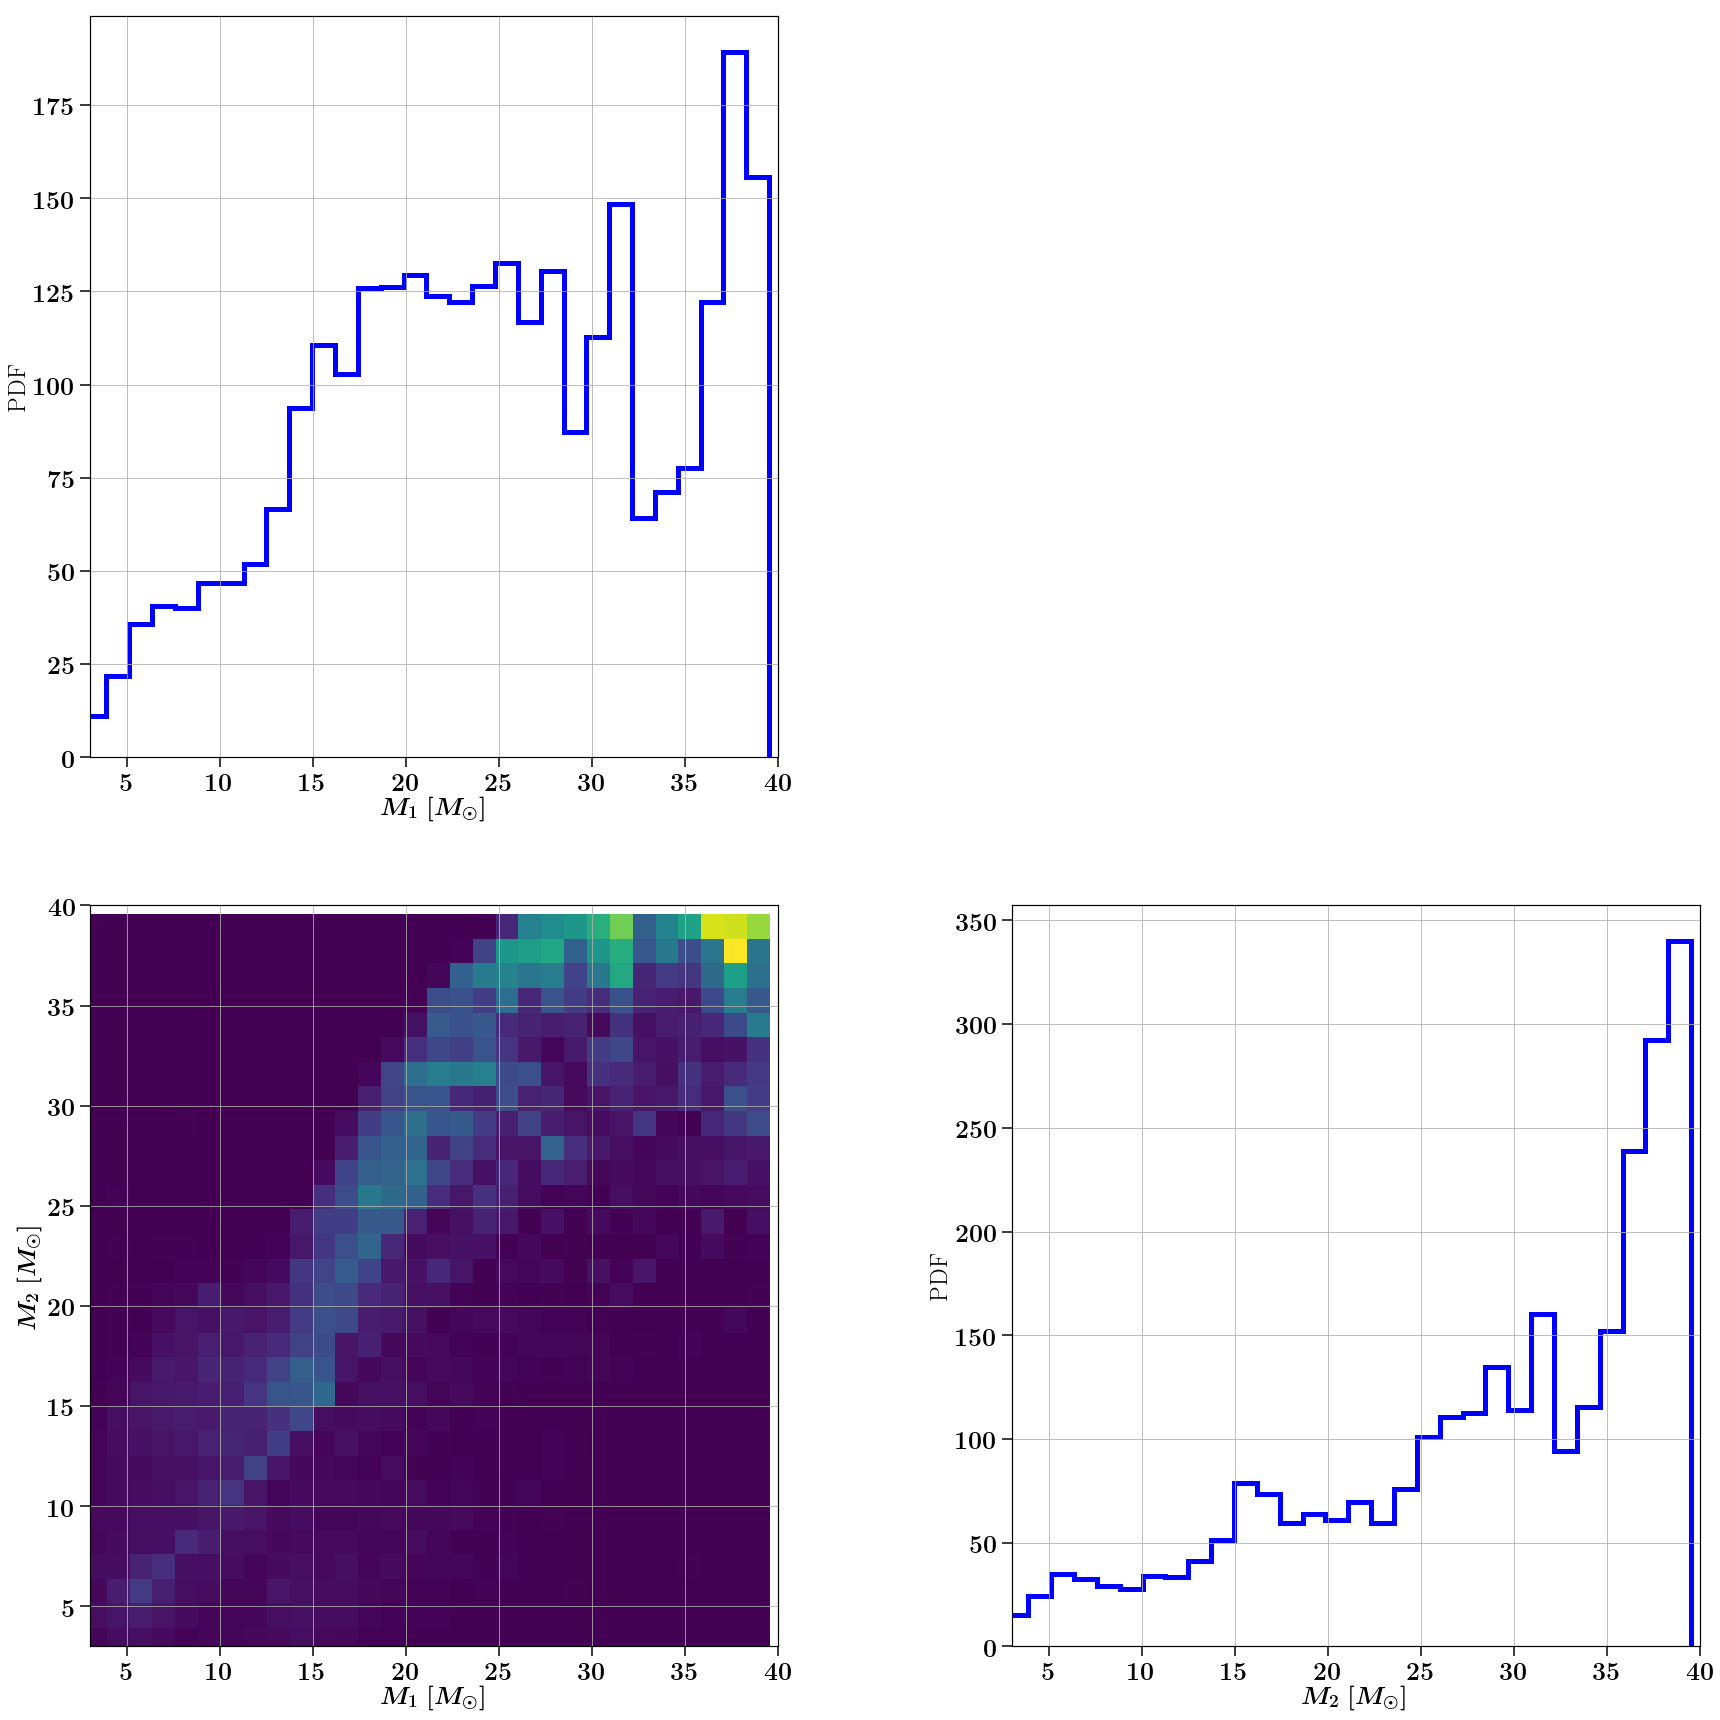

('at model =', 24)
('ii,jj=', 1, 0)


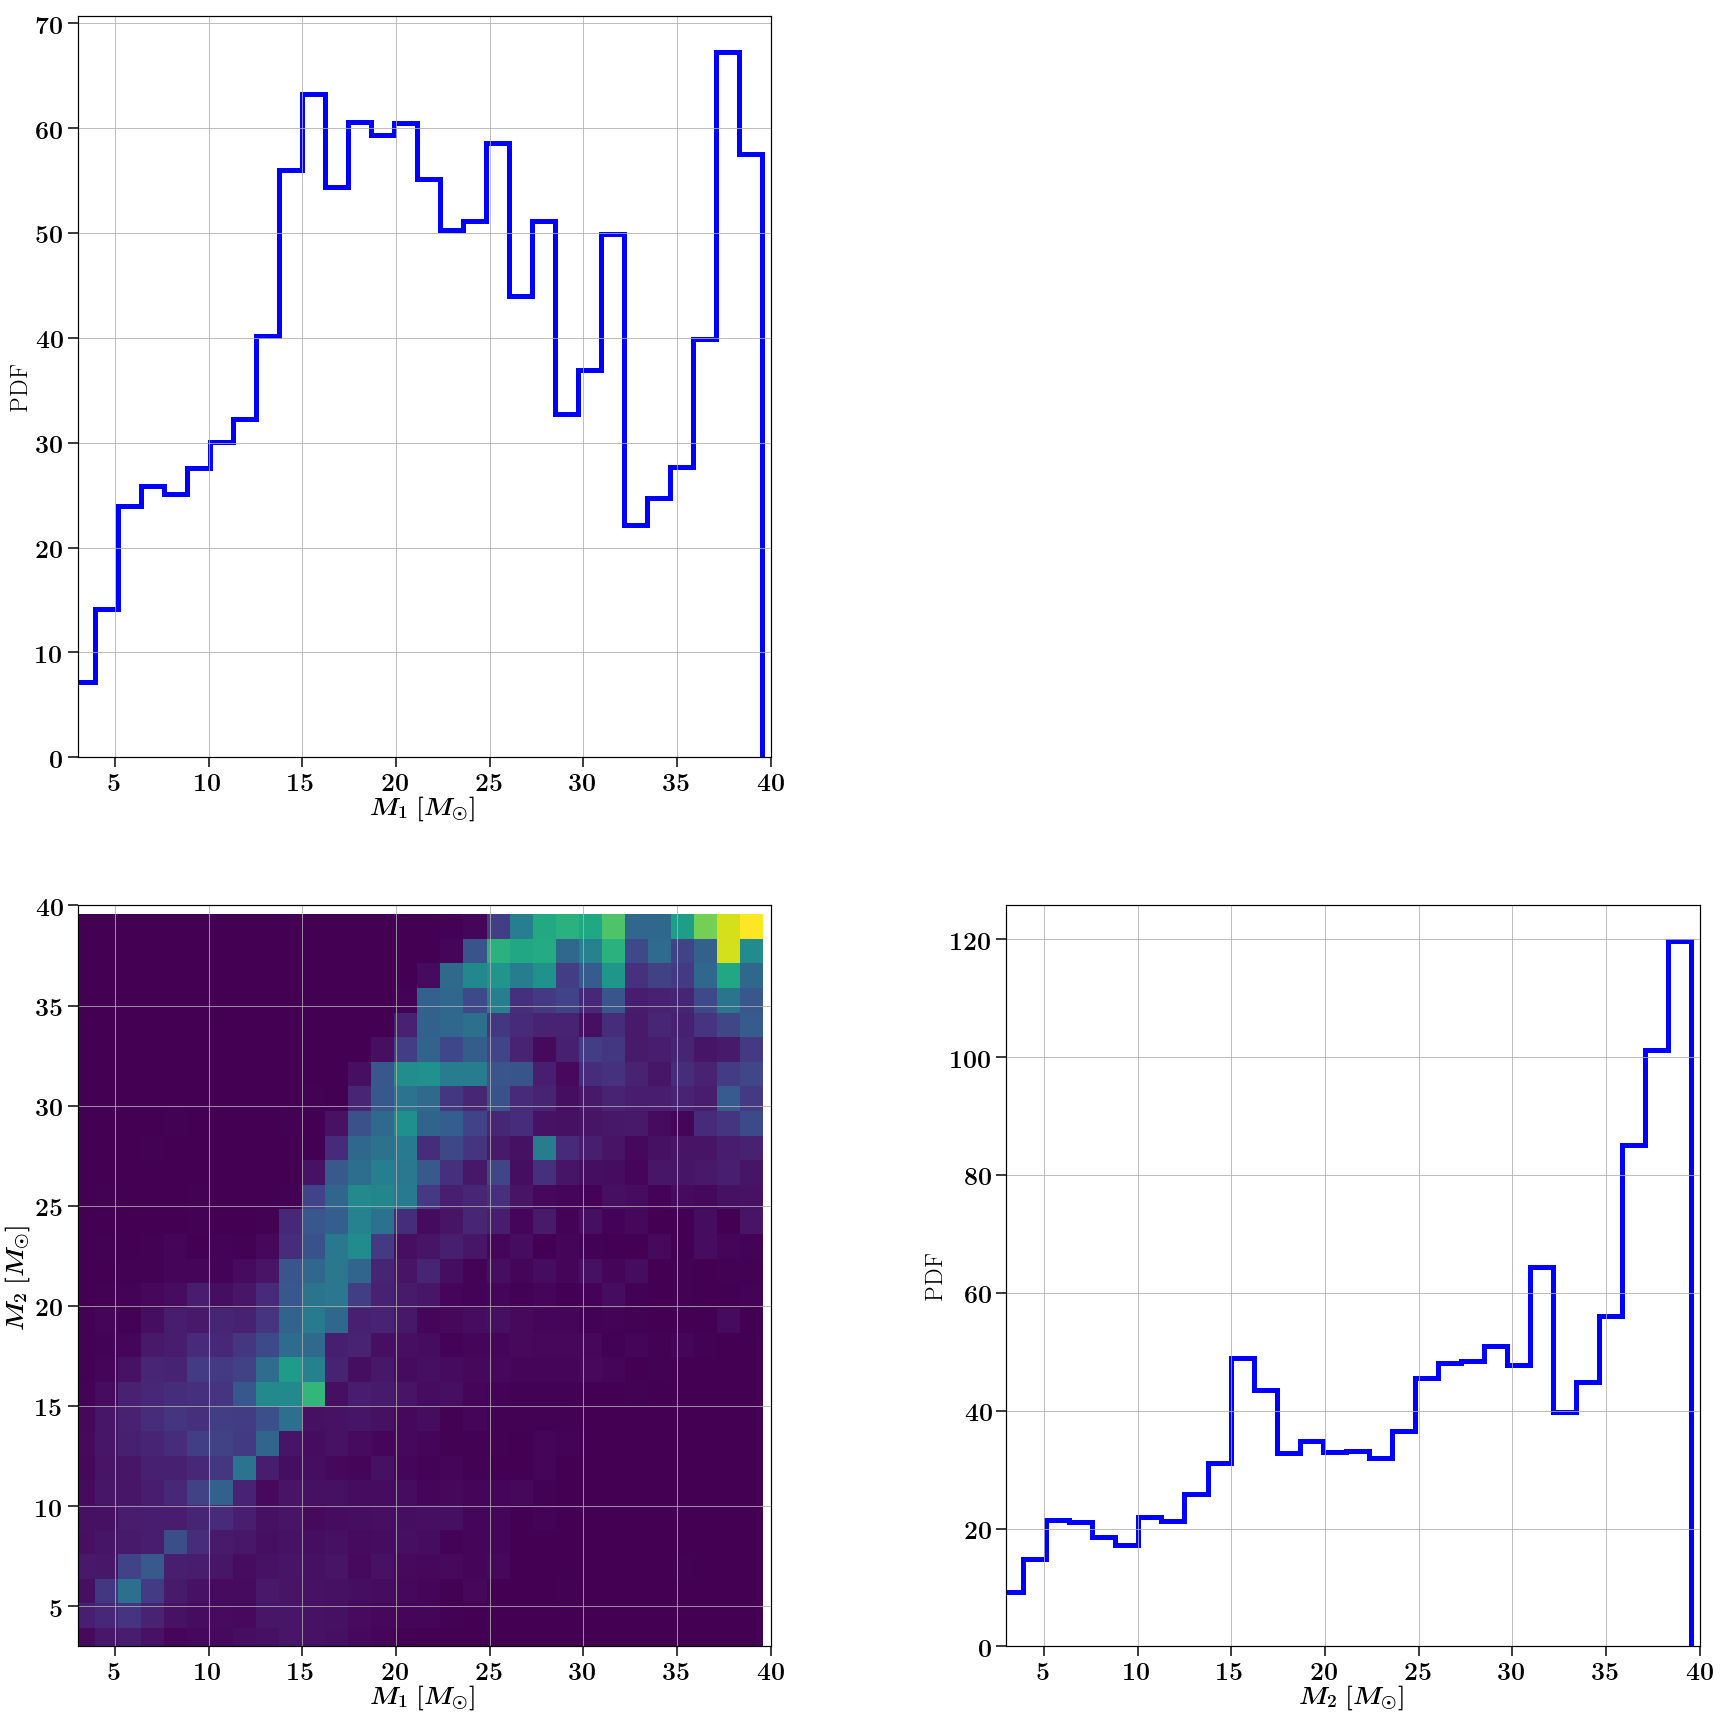

('at model =', 25)
('ii,jj=', 1, 0)


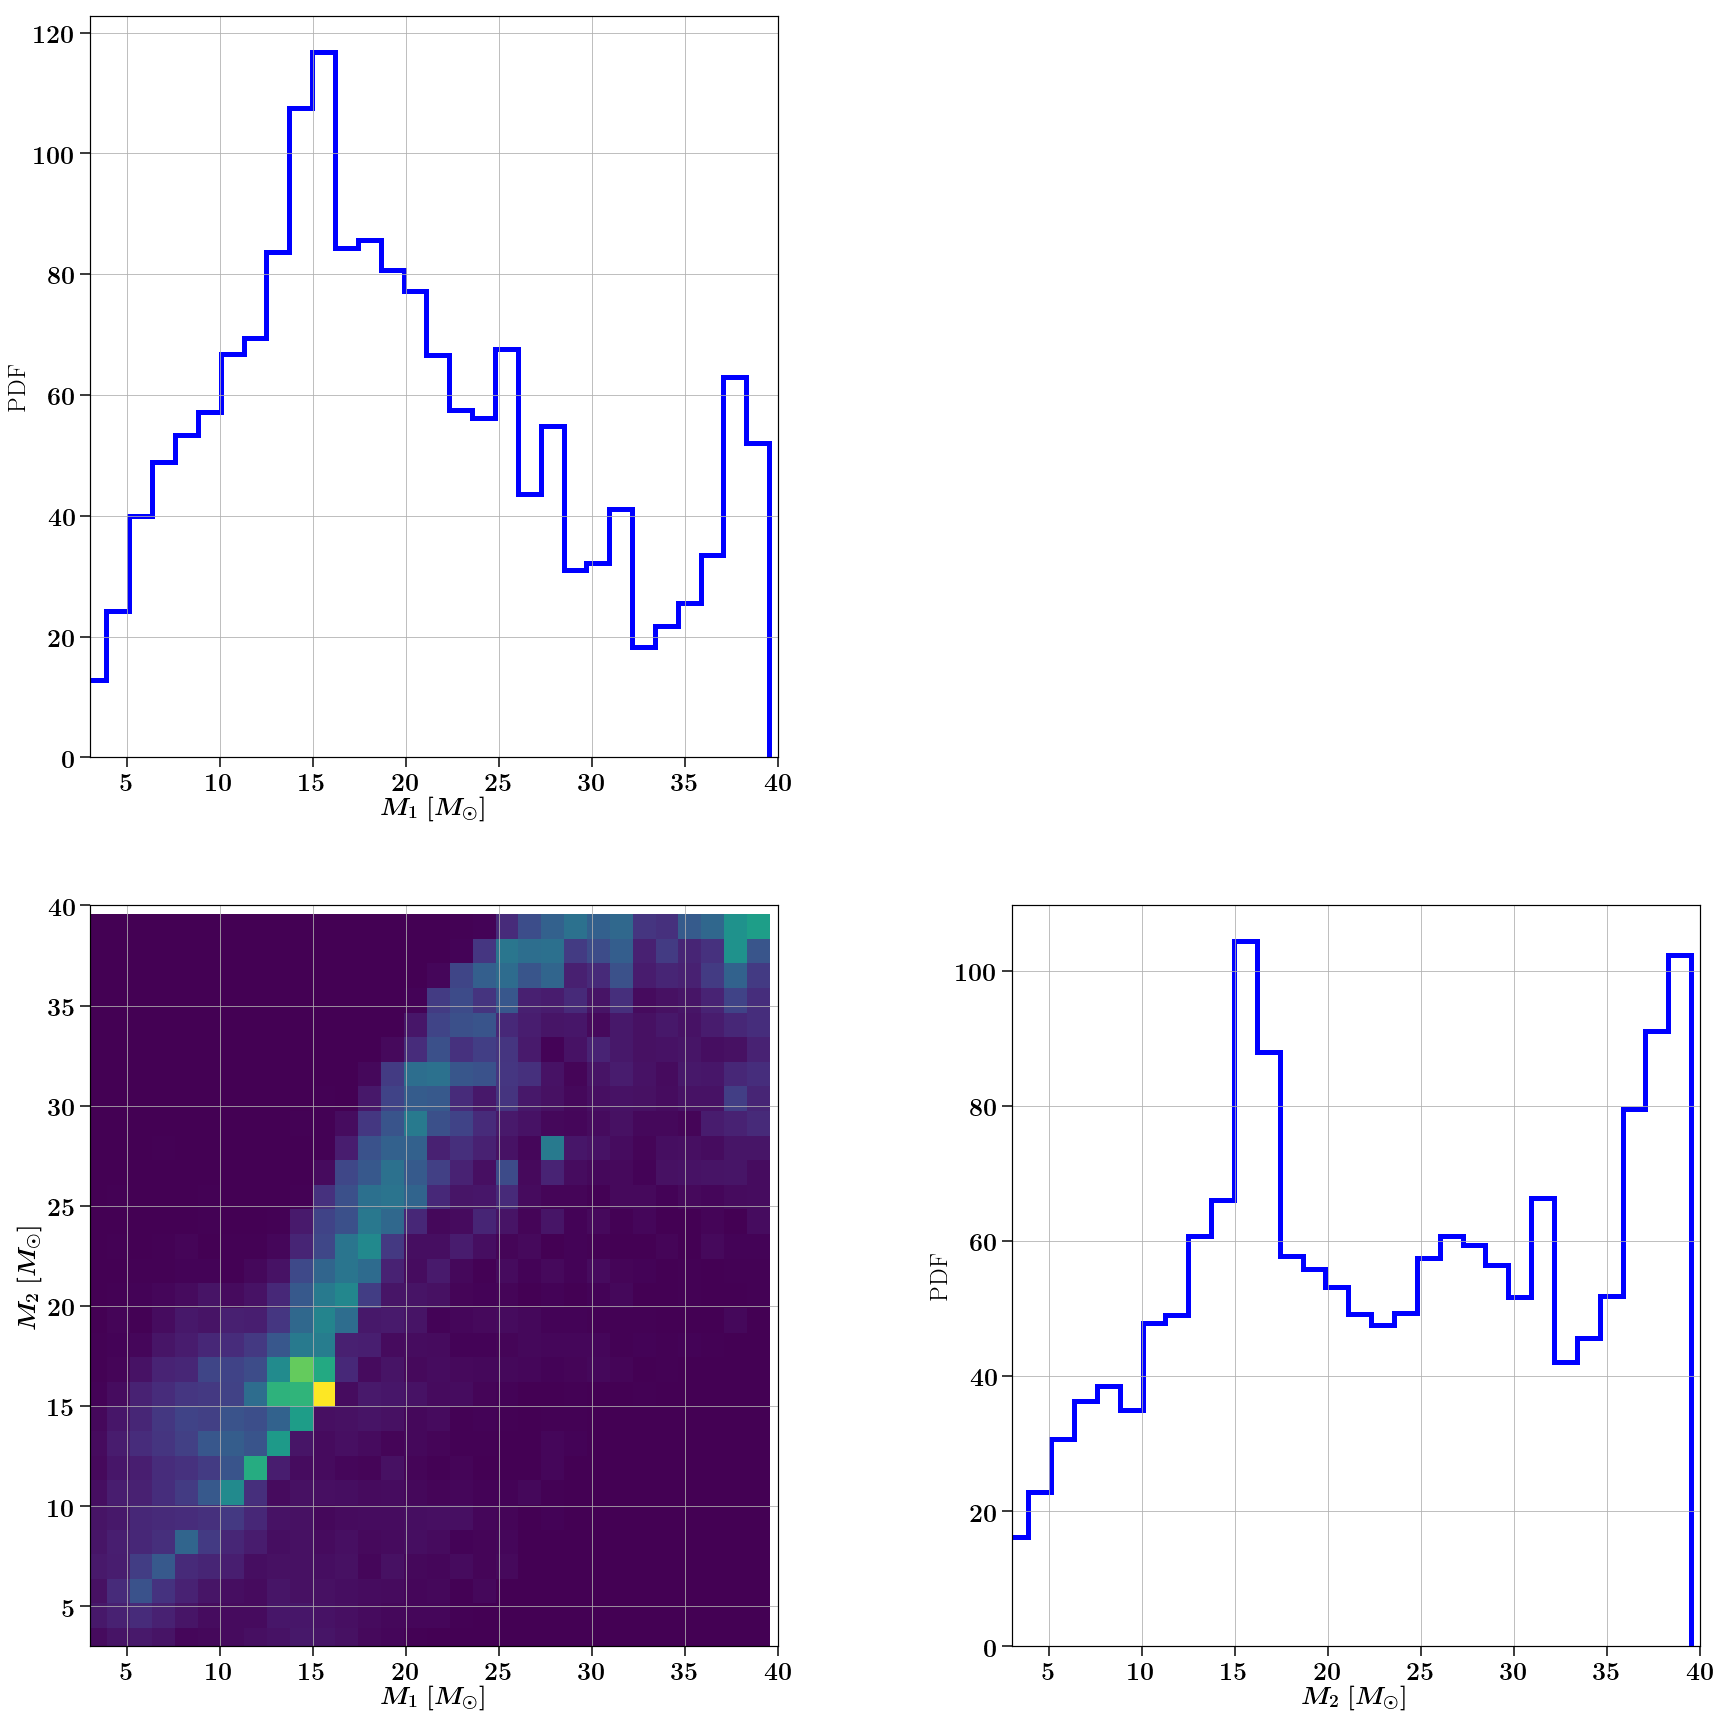

('at model =', 26)
('ii,jj=', 1, 0)


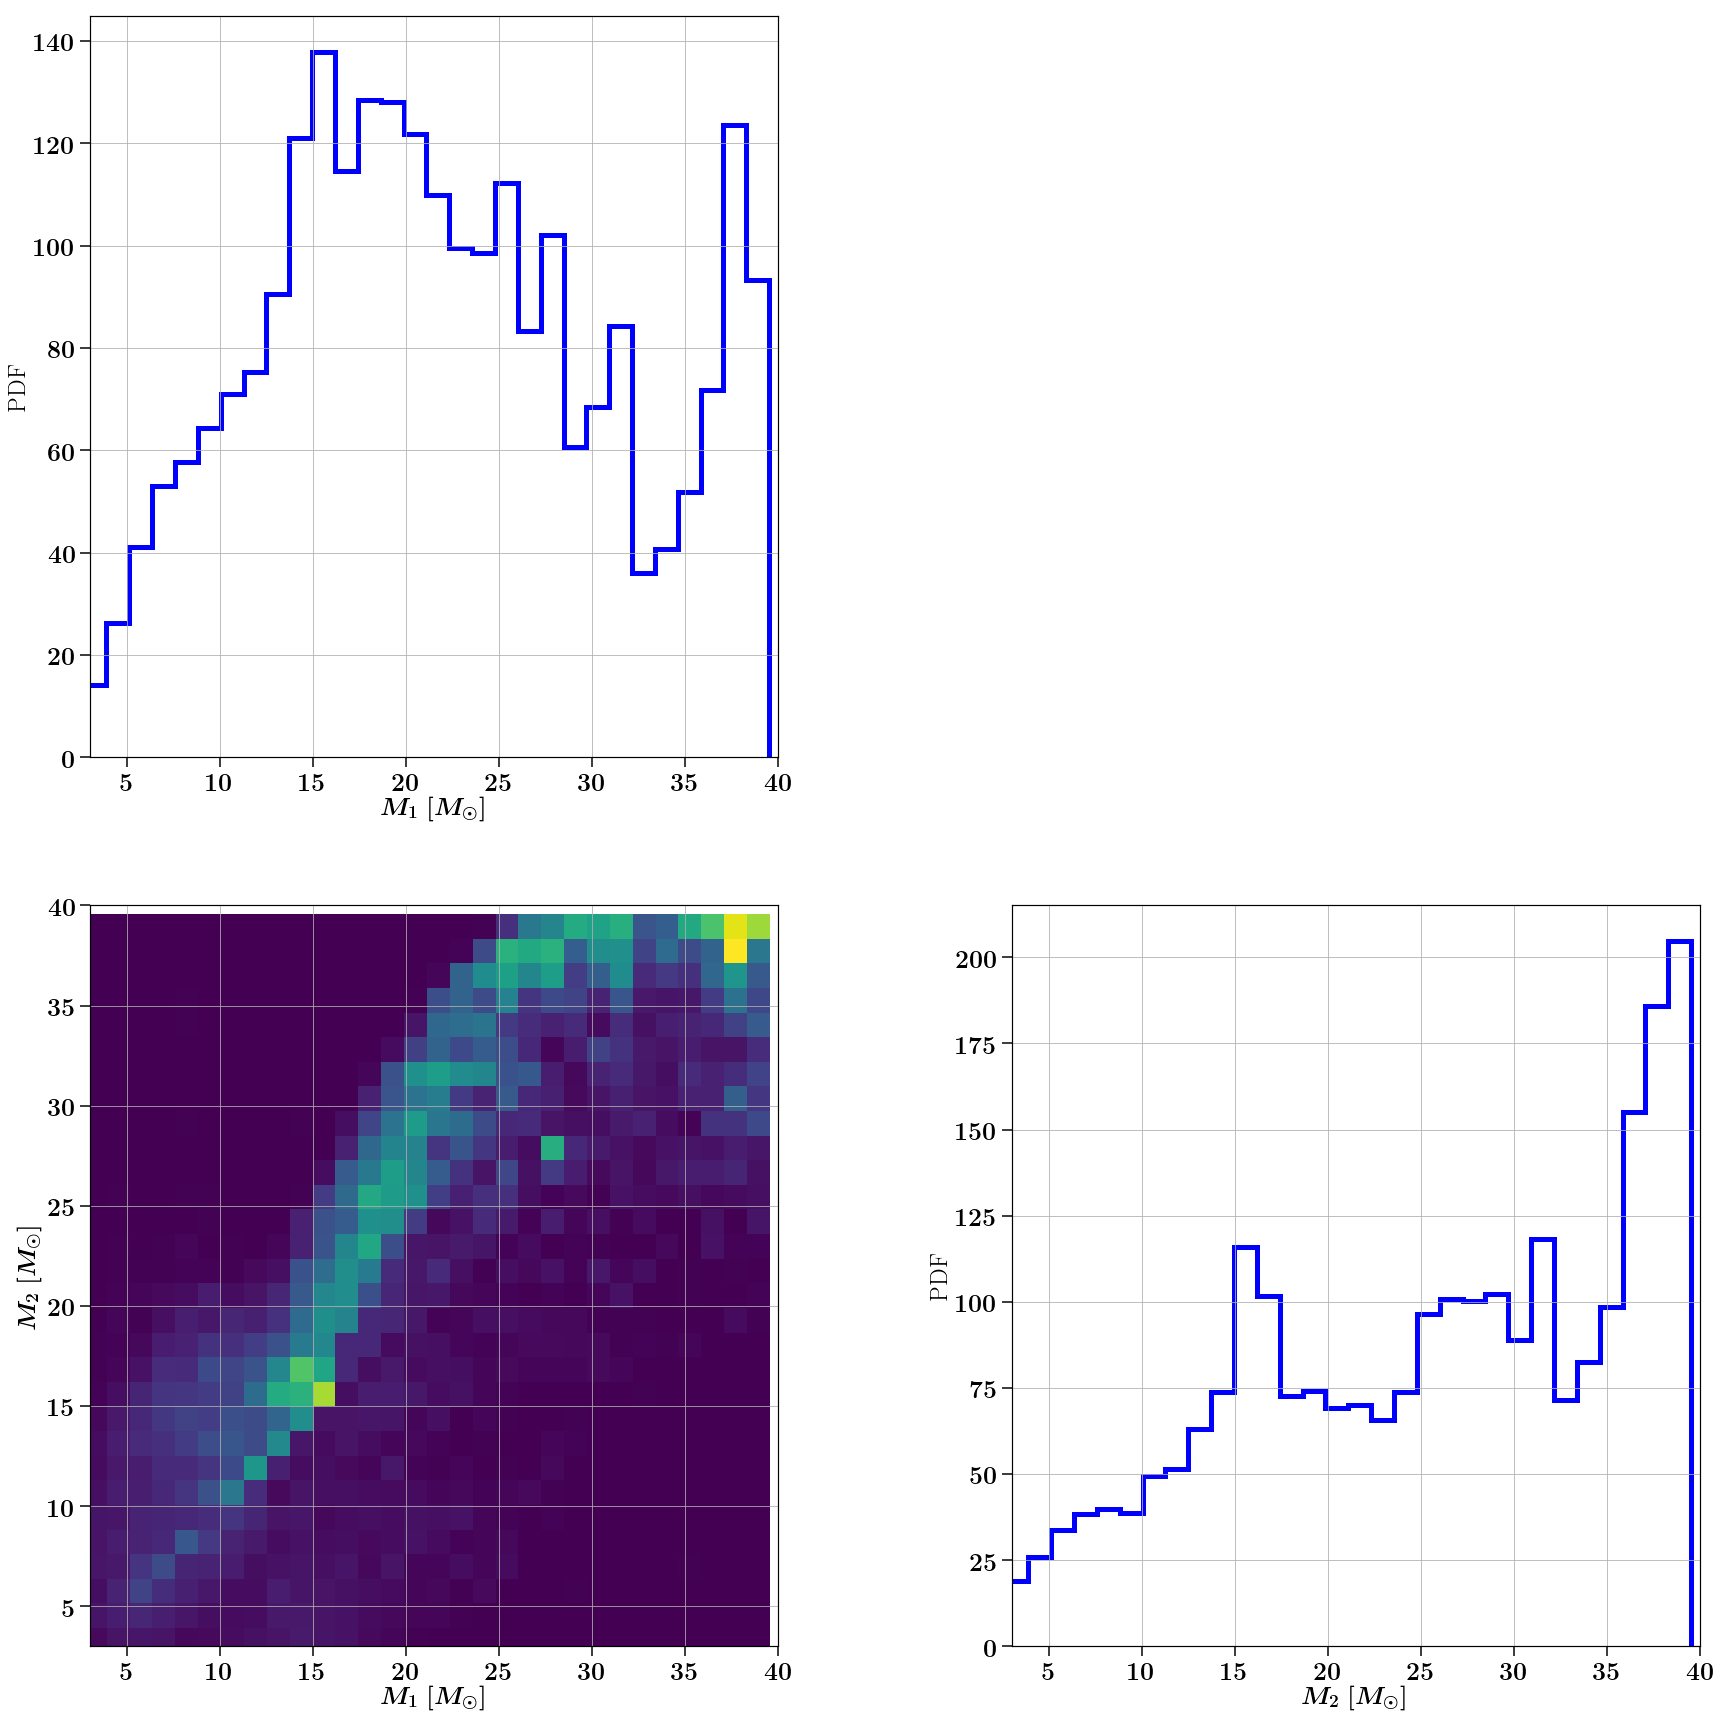

('at model =', 27)
('ii,jj=', 1, 0)


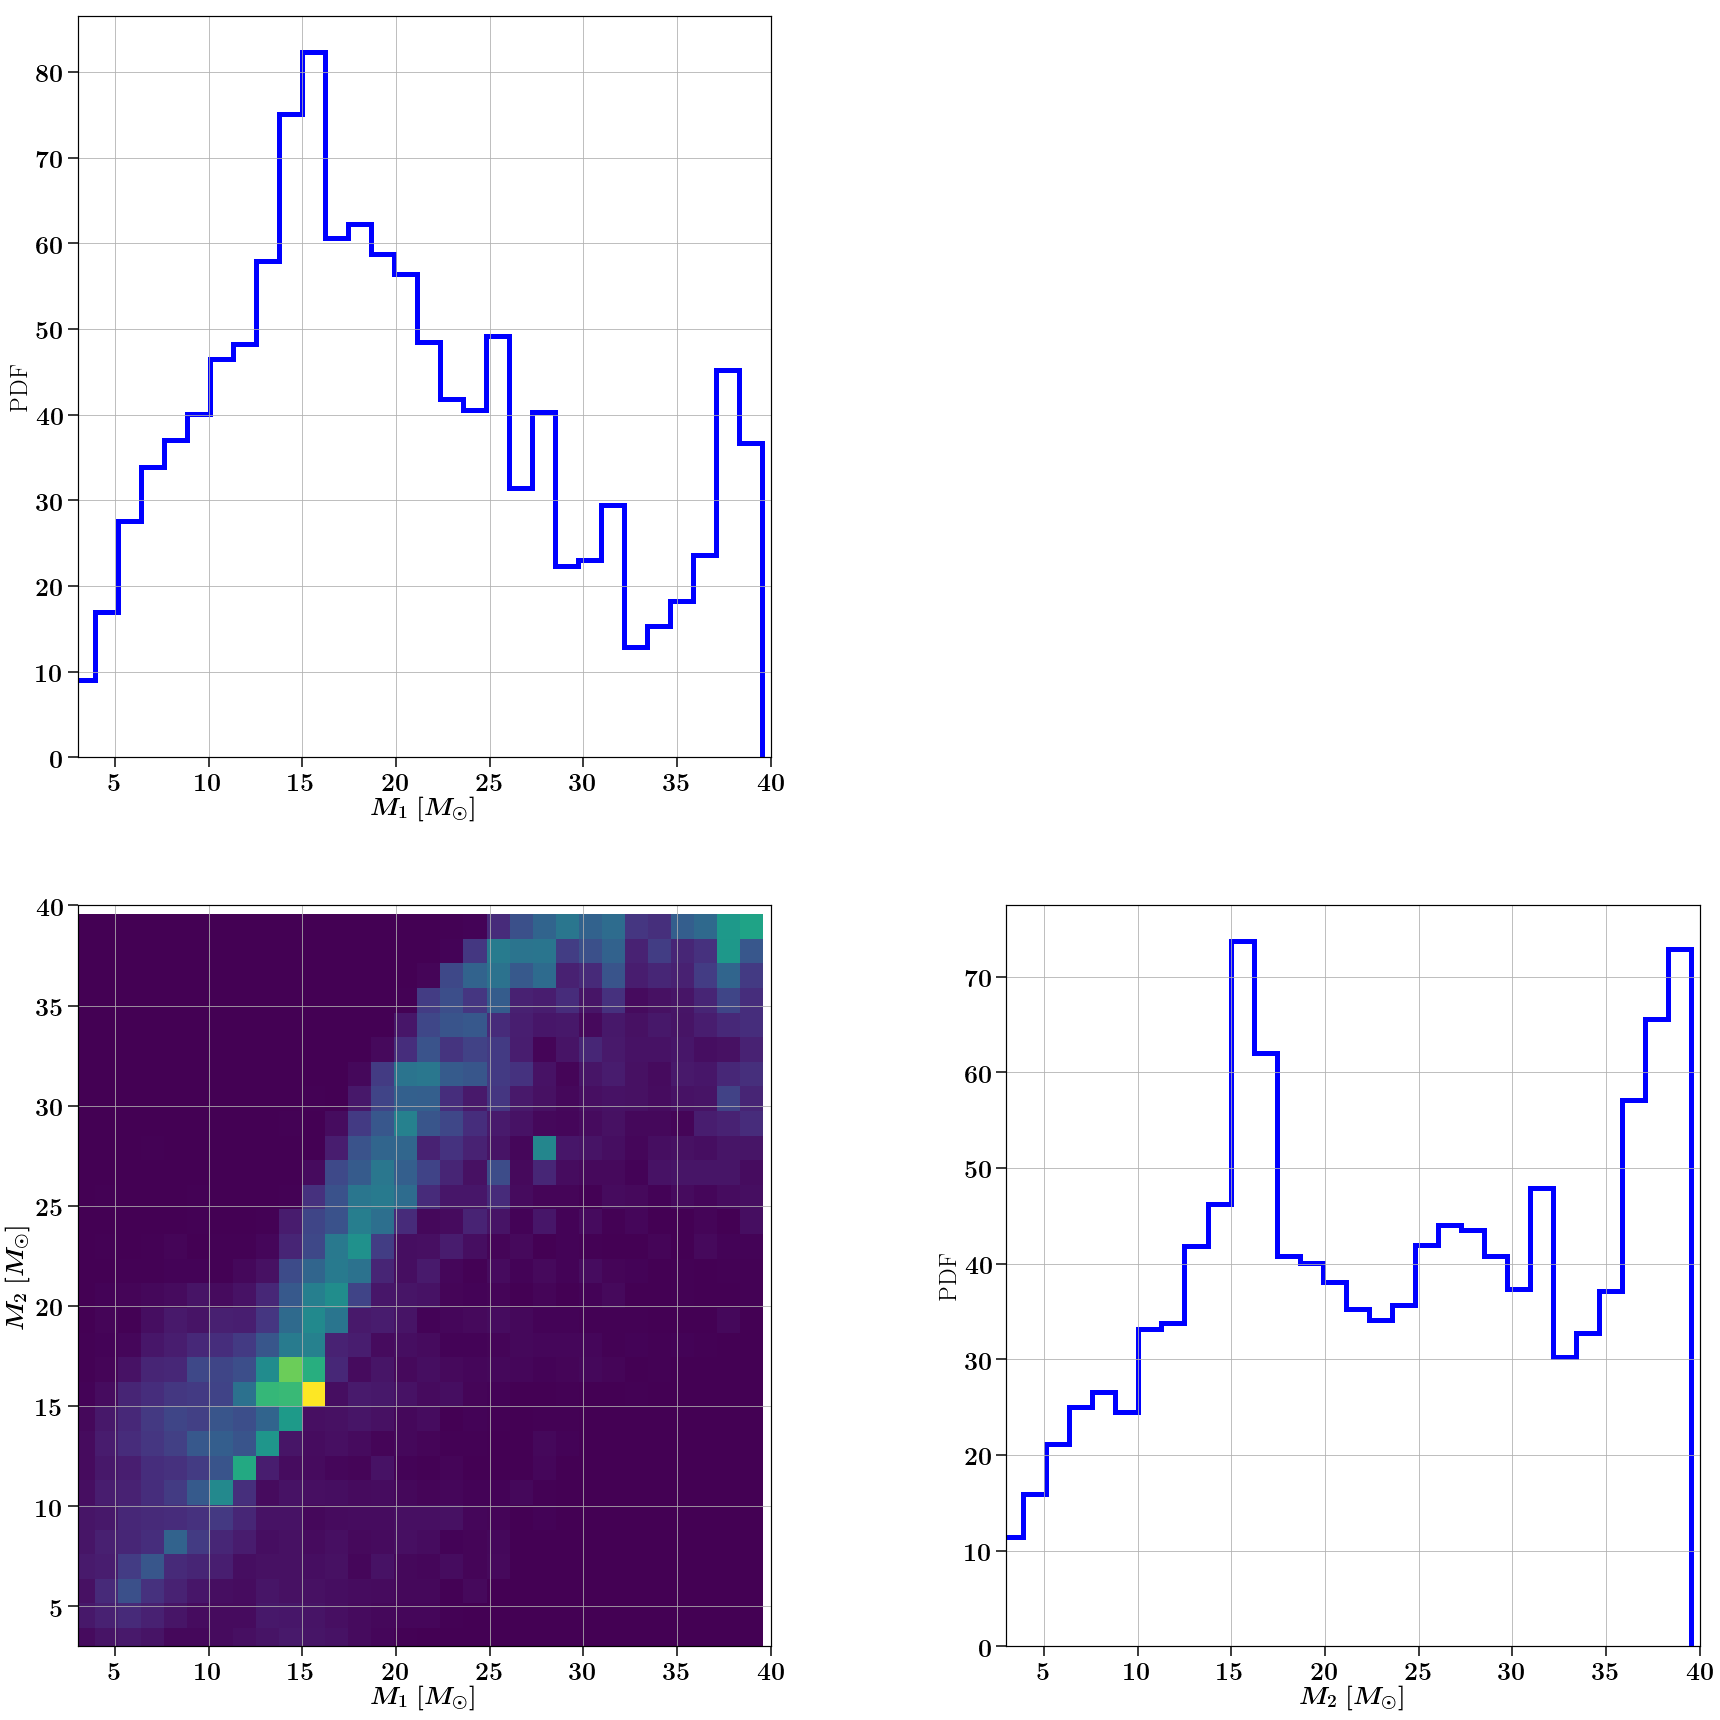

In [98]:

Data = Data_model4_BBH
var = [Data.COMPAS.mass1, Data.COMPAS.mass2]
for ind_MSSFR, MSSFRrate in enumerate(rates_model1):
    
    print('at model =', ind_MSSFR)
    Nbins = 30 

    labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


    f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                      gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


    weights = MSSFRrate


    handles, labels =  plot2Ddistribution(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                          rateslist=None, totalslist=None,\
                                          labellist=labellist,\
                                          xlimlist=[[3,40],[3,40]], indplot=0)



    # plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
    #                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
    #                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




    # # # # LEGEND
    # # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
    # #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




    plt.tight_layout()
    plt.subplots_adjust(wspace=0.34, hspace=0.2)
    plt.savefig('./imagesBBH/BBH_TrianglePlot_scatter_m_'+ str(ind_MSSFR) +'.png', dpi=100, transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()

In [99]:
filenames = []
for ind_MSSFR, MSSFRrate in enumerate(rates_model1):
    filenames.append('BBH_TrianglePlot_scatter_m_'+ str(ind_MSSFR) +'.png')


import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('./imagesBBH/'+filename))
imageio.mimsave('./imagesBBH/MSSFRmovie.gif', images)

In [ ]:

Data = Data_model4_BBH
var = [Data.COMPAS.mass1, Data.COMPAS.mass2]
for ind_MSSFR, MSSFRrate in enumerate(rates_model1):
    
    print('at model =', ind_MSSFR)
    Nbins = 30 

    labellist=[r'$M_1 \ [M_{\odot}]$', r'$M_2 \ [M_{\odot}]$']


    f, ax= plt.subplots(ncols=2,nrows=2,figsize=(24,24), 
                      gridspec_kw={"width_ratios":[1.5, 1.5], "height_ratios":[2,2]})


    weights = MSSFRrate


    handles, labels =  plot2Ddistribution(axe=ax, var=var, weight=weights, nrbins=Nbins,\
                                          rateslist=None, totalslist=None,\
                                          labellist=labellist,\
                                          xlimlist=[[3,40],[3,40]], indplot=0)



    # plot2Ddistribution(axe=ax, var=varname, nrbins=Nbins, modelnameslist=modelnameslist, \
    #                        rateslist=rateslist, totalslist=totalslist, Datalist=Datalist,  \
    #                        xvarrange=[0,1.5], xlabel='q', ylabel='PDF', xlim=[0,1], ylim=[0,5], indplot=0)   




    # # # # LEGEND
    # # lgd = f.legend(handles, labels, fontsize=fs+4, ncol=4,\
    # #          bbox_to_anchor=(.9, 1.06),  markerscale=3., scatterpoints=1) # loc = 'upper center')




    plt.tight_layout()
    plt.subplots_adjust(wspace=0.34, hspace=0.2)
    plt.savefig('./imagesBBH/BBH_TrianglePlot_scatter_m_'+ str(ind_MSSFR) +'.png', dpi=100, transparent=False,\
               bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()
    plt.close()

In [101]:
print(labels)

[]
